In [64]:
import random, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

import tool

In [65]:
asset_index = pd.read_csv("data/aidx_eod_prices.csv")

grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 2000}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)
    
unique_assets = list(asset_dfs.keys())
print(unique_assets)
print(len(unique_assets))

['000001.SH', '000002.SH', '000003.SH', '000004.SH', '000005.SH', '000006.SH', '000007.SH', '000008.SH', '000009.SH', '000010.SH', '000015.SH', '000016.SH', '000017.SH', '000018.SH', '000019.SH', '000020.SH', '000021.SH', '000025.SH', '000026.SH', '000027.SH', '000028.SH', '000029.SH', '000030.SH', '000031.SH', '000032.SH', '000033.SH', '000034.SH', '000035.SH', '000036.SH', '000037.SH', '000038.SH', '000039.SH', '000040.SH', '000041.SH', '000042.SH', '000043.SH', '000044.SH', '000045.SH', '000046.SH', '000047.SH', '000048.SH', '000049.SH', '000050.SH', '000051.SH', '000052.SH', '000053.SH', '000054.SH', '000055.SH', '000056.SH', '000057.SH', '000058.SH', '000059.SH', '000060.SH', '000062.SH', '000063.SH', '000064.SH', '000065.SH', '000066.SH', '000067.SH', '000068.SH', '000069.SH', '000070.SH', '000071.SH', '000072.SH', '000073.SH', '000074.SH', '000075.SH', '000076.SH', '000077.SH', '000078.SH', '000079.SH', '000090.SH', '000091.SH', '000092.SH', '000093.SH', '000094.SH', '000095.SH'

In [66]:
class GAmulti:
    def __init__(self, historical_data, future_data, model_type):
        self.historical_data = historical_data.copy()
        self.future_data = future_data.copy()
        self.model_type = model_type
        
    def evaluate(self, individual):
        ones_count = sum(individual)
        if ones_count > 20:
            ones_indices = [i for i, x in enumerate(individual) if x == 1]
            indices_to_zero = np.random.choice(ones_indices, size=(ones_count - 20), replace=False)
            for index in indices_to_zero:
                individual[index] = 0
        elif ones_count < 20:
            zero_indices = [i for i, x in enumerate(individual) if x == 0]
            indices_to_one = np.random.choice(zero_indices, size=(20 - ones_count), replace=False)
            for index in indices_to_one:
                individual[index] = 1
                
        selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
        
        historical_data = self.historical_data[self.historical_data.columns[self.historical_data.columns.isin(selected_assets)]]
        future_data = self.future_data[self.future_data.columns[self.future_data.columns.isin(selected_assets)]]
        
        n = len(selected_assets)
        index_min_weight = [0 for _ in range(n)]
        index_max_weight = [1 for _ in range(n)]
        weight_constraints = list(zip(index_min_weight, index_max_weight))
        
        predict, _, _ = tool.evaluate(historical_data, future_data, weight_constraints, self.model_type)
        expected_return, volatility, sharpe_ratio = predict
        
        return expected_return, sharpe_ratio, volatility
    
    def create_individual(self):
        n = len(unique_assets)
        individual = [0] * n

        indices = np.random.choice(n, 20, replace=False)
        for index in indices:
            individual[index] = 1

        np.random.shuffle(individual)

        return individual
    
    def main(self):
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0))
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initIterate, creator.Individual, self.create_individual)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        
        toolbox.register("evaluate", self.evaluate)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selNSGA2)
        
        def run_ga(pop_size, num_generations):
            pop = toolbox.population(n=pop_size)
            hof = tools.ParetoFront()
            logbook = tools.Logbook()
            stats = tools.Statistics(lambda ind: ind.fitness.values)

            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0)
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)
            
            pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof,  verbose=True)
            
            return pop, hof, stats, logbook
        
        population, pareto_front, stats, logbook = run_ga(50, 200)

        pareto_front = [ind for ind in pareto_front if not all(x == 0 for x in ind)]
        def get_calculations(individual):
            selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
            
            historical_data = self.historical_data[self.historical_data.columns[self.historical_data.columns.isin(selected_assets)]]
            future_data = self.future_data[self.future_data.columns[self.future_data.columns.isin(selected_assets)]]
            
            n = len(selected_assets)
            index_min_weight = [0 for _ in range(n)]
            index_max_weight = [1 for _ in range(n)]
            weight_constraints = list(zip(index_min_weight, index_max_weight))
            
            predict, actual, weight = tool.evaluate(historical_data, future_data, weight_constraints, self.model_type)
            
            return predict, actual, weight, selected_assets

        individual_predicts = {str(ind): get_calculations(ind)[0] for ind in pareto_front}
        individual_actuals = {str(ind): get_calculations(ind)[1] for ind in pareto_front}
        individual_weights = {str(ind): get_calculations(ind)[2] for ind in pareto_front}
        individual_selects = {str(ind): get_calculations(ind)[3] for ind in pareto_front}

        # Output
        for i, ind in enumerate(pareto_front):
            print(f"Pareto Front {i}")
            print(f"Selects: {individual_selects[str(ind)]}")
            print(f"Predicts: {individual_predicts[str(ind)]}")
            print(f"Actuals: {individual_actuals[str(ind)]}")
            print(f"Weights: {individual_weights[str(ind)]}")
            print("")
        
        return individual_predicts, individual_actuals, individual_weights, individual_selects

In [67]:
# randomly select assets
index_list = unique_assets
asset_index['TRADE_DT'] = pd.to_datetime(asset_index['TRADE_DT'], format='%Y%m%d')
asset_index.sort_values(by='TRADE_DT', inplace=True)
asset_index.set_index('TRADE_DT', inplace=True)
asset_index = asset_index.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list].dropna()

In [68]:
# historical_data = asset_index[:1000]
# future_data = asset_index[1000:]

# test = GAmulti(historical_data, future_data, 'RB-SLSQP')
# predicts, actuals, weights, selects = test.main()

# print(list(predicts.values()))
# print(list(actuals.values()))
# print(list(selects.values()))

In [69]:
def calvsEW(i, asset_index, actuals, selects):
    future_data = asset_index.copy()
    future_data = future_data[future_data.columns[future_data.columns.isin(selects[i])]]
    reality = tool.check([1 / len(future_data.columns) for _ in range(len(future_data.columns))], future_data, 0.02)
    actual = actuals[i]
    return actual[0] - reality[0], actual[1] / reality[1], actual[2] / reality[2]

def rebalance(asset_index, rebalance_day):
    max_return_result = []
    min_volatility_result = []
    custom_result = []
    
    for i in range(rebalance_day, len(asset_index), rebalance_day):
        if i+rebalance_day >= len(asset_index):
            break
        
        historical_data = asset_index[i-rebalance_day:i]
        future_data = asset_index[i:i+rebalance_day]
        
        test = GAmulti(historical_data, future_data, 'RB-SLSQP')
        predicts, actuals, weights, selects = test.main()
        predicts = list(predicts.values())
        actuals = list(actuals.values())
        selects = list(selects.values())
        
        # select max return
        max_return = float('-inf')
        max_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if ret > max_return and ret != np.inf:
                max_return = ret
                max_index = i
        max_ret_res = calvsEW(max_index, future_data, actuals, selects)
        max_return_result.append(max_ret_res)
        
        # select min volatility
        min_volatility = float('inf')
        min_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if vol < min_volatility:
                min_volatility = vol
                min_index = i
        min_vol_res = calvsEW(min_index, future_data, actuals, selects)
        min_volatility_result.append(min_vol_res)
        
        # select custom
        min_volatility = float('inf')
        cs_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if vol < min_volatility and ret >= 0:
                min_volatility = vol
                cs_index = i
        cs_res = calvsEW(cs_index, future_data, actuals, selects)
        custom_result.append(cs_res)
    
    return max_return_result, min_volatility_result, custom_result

In [70]:
ret, vol, cs = rebalance(asset_index, 210)

print(ret)
print(vol)
print(cs)

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


gen	nevals	avg                                              	std                                           	min                                              	max                                           
0  	50    	[-6.25367187e-02 -4.63762747e-04  1.83568398e+02]	[3.18691345e-02 1.81470466e-04 4.15960997e+01]	[-1.46150644e-01 -8.41040470e-04  9.10810279e+01]	[2.07328494e-02 3.96968823e-06 2.98201591e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1  	43    	[-6.22442614e-02 -4.60545149e-04  1.83825165e+02]	[3.14505500e-02 1.88843178e-04 4.18377084e+01]	[-1.46150644e-01 -1.05067078e-03  9.52389467e+01]	[-5.24201674e-03 -1.48244991e-04  3.08610165e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2  	43    	[-6.58292837e-02 -4.79426484e-04  1.85817078e+02]	[3.51162728e-02 2.13611238e-04 4.40844467e+01]	[-1.50078933e-01 -1.28184232e-03  8.75934144e+01]	[ 7.18522495e-03 -7.07510851e-05  3.08610165e+02]
3  	38    	[2.86869630e-01 1.72803926e-03 1.79800141e+02]   	[2.43573269e+00 1.54772321e-02 5.30928881e+01]	[-1.58847361e-01 -1.28184232e-03  8.75934144e+01]	[1.73341675e+01 1.10051944e-01 3.76128976e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4  	36    	[2.39361300e-01 1.57723858e-03 1.84564050e+02]   	[2.14919634e+00 1.45849849e-02 5.61155522e+01]	[-1.58847361e-01 -1.28184232e-03  1.04437969e+02]	[1.52803966e+01 1.03655534e-01 3.61623458e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


5  	41    	[2.28422447e-01 2.06096888e-03 1.85192688e+02]   	[2.08876978e+00 1.80356559e-02 5.38336444e+01]	[-1.58847361e-01 -1.12012856e-03  9.15936460e+01]	[1.48476326e+01 1.28299672e-01 3.73348880e+02]   
6  	42    	[2.26849443e-01 2.11457827e-03 1.84377309e+02]   	[2.05578416e+00 1.81890357e-02 4.44090260e+01]	[-1.57728169e-01 -1.04596524e-03  1.12764140e+02]	[1.46149088e+01 1.29428635e-01 2.89712972e+02]   
7  	37    	[-6.64552383e-02 -4.67343103e-04  1.95609905e+02]	[3.99387474e-02 2.45319268e-04 4.31817712e+01]	[-1.69532040e-01 -1.21292969e-03  1.10710605e+02]	[ 8.15054115e-03 -5.94339230e-05  2.81660341e+02]
8  	36    	[-6.21719872e-02 -4.64403860e-04  1.90069684e+02]	[4.46219997e-02 2.80691611e-04 4.28503421e+01]	[-1.58856292e-01 -1.15049619e-03  1.10710605e+02]	[1.01361496e-01 3.88174144e-04 2.76555140e+02]   
9  	40    	[-6.53819878e-02 -4.72661969e-04  1.89599961e+02]	[4.55752197e-02 2.62066412e-04 4.24292813e+01]	[-1.58758687e-01 -1.08204431e-03  1.04368060e+02]	[1.0934035

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


16 	40    	[4.42329510e-01 2.35806392e-03 1.96979402e+02]   	[3.56409808e+00 1.96992540e-02 5.05369390e+01]	[-1.37155678e-01 -8.49596039e-04  4.87882674e+01]	[2.53896479e+01 1.40245899e-01 3.57436166e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


17 	40    	[4.33157508e-01 3.25116545e-03 1.97765541e+02]   	[3.46363634e+00 2.57062961e-02 4.54158253e+01]	[-1.40618884e-01 -1.02646144e-03  5.28936995e+01]	[2.46767378e+01 1.83187763e-01 3.57436166e+02]   
18 	40    	[4.42495943e-01 3.28842408e-03 1.99734669e+02]   	[3.46233845e+00 2.57012485e-02 4.93735735e+01]	[-1.62493199e-01 -1.02665267e-03  5.28936995e+01]	[2.46767378e+01 1.83187763e-01 3.39945958e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


19 	39    	[4.21840767e-01 2.76515292e-03 1.96034834e+02]   	[3.33113278e+00 2.22075100e-02 5.41752854e+01]	[-1.54110670e-01 -1.01662592e-03  4.30429120e+01]	[2.37376213e+01 1.58206657e-01 3.39945958e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


20 	35    	[4.42377575e-02 1.70586752e-03 1.97587419e+02]   	[6.70576367e-01 1.46298266e-02 5.31619506e+01]	[-1.29133436e-01 -9.28036866e-04  4.52438661e+01]	[4.72994808e+00 1.04101362e-01 3.36423829e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


21 	39    	[3.91114083e-01 2.70001085e-03 2.00013479e+02]   	[3.09707730e+00 2.15779293e-02 6.33055865e+01]	[-1.18596057e-01 -7.79188528e-04  3.39757880e+01]	[2.20688468e+01 1.53738103e-01 3.67058776e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


22 	42    	[3.88242097e-01 2.78552962e-03 1.98415801e+02]   	[3.10475084e+00 2.23383240e-02 6.35370973e+01]	[-1.34247081e-01 -9.20449812e-04  3.63256683e+01]	[2.21198876e+01 1.59145311e-01 3.82842087e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


23 	42    	[3.89964047e-01 2.78889743e-03 1.93278329e+02]   	[3.10451335e+00 2.23378455e-02 6.06984270e+01]	[-1.41981865e-01 -9.85442701e-04  3.51762365e+01]	[2.21198876e+01 1.59145311e-01 3.61874115e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


24 	38    	[-5.51596598e-02 -4.08815357e-04  1.93575398e+02]	[3.62668751e-02 2.15205950e-04 6.12951099e+01]	[-1.34171222e-01 -1.01633163e-03  3.73302875e+01]	[ 1.56379231e-02 -8.53552275e-05  3.58788487e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


25 	39    	[4.22369932e-01 1.73222789e-03 1.92338003e+02]   	[3.36968554e+00 1.52162962e-02 6.22026785e+01]	[-1.14335615e-01 -1.42551859e-03  4.08736530e+01]	[2.40087282e+01 1.08232165e-01 3.63231738e+02]   
26 	38    	[4.24285901e-01 1.74880437e-03 1.94295134e+02]   	[3.36941670e+00 1.52138298e-02 6.82404927e+01]	[-1.53978051e-01 -1.42551859e-03  4.08736530e+01]	[2.40087282e+01 1.08232165e-01 4.99248606e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


27 	45    	[4.38759877e-01 1.84380455e-03 1.89705610e+02]   	[3.46609128e+00 1.58255925e-02 4.78189181e+01]	[-1.49765564e-01 -1.03752118e-03  4.27854106e+01]	[2.47001194e+01 1.12614796e-01 3.25982657e+02]   
28 	37    	[4.41707487e-01 1.86488327e-03 1.93020136e+02]   	[3.46565016e+00 1.58226663e-02 3.91753228e+01]	[-1.53007068e-01 -9.22614996e-04  1.17473574e+02]	[2.47001194e+01 1.12614796e-01 3.08773770e+02]   
29 	45    	[-4.55455916e-02 -3.54070204e-04  1.96999665e+02]	[4.78299680e-02 2.62415794e-04 4.70270103e+01]	[-1.53790934e-01 -8.59920302e-04  1.19892277e+02]	[1.53991606e-01 6.38769830e-04 3.58115510e+02]   
30 	44    	[-4.47185897e-02 -3.60996365e-04  1.95900421e+02]	[4.64091125e-02 2.48872846e-04 5.61824135e+01]	[-1.36591903e-01 -8.85970810e-04  1.06158728e+02]	[1.67361976e-01 6.36517602e-04 3.78008523e+02]   
31 	42    	[-4.75472602e-02 -3.65194984e-04  1.98916081e+02]	[4.30928840e-02 2.72156094e-04 5.28987557e+01]	[-1.21042756e-01 -8.02694246e-04  1.04067167e+02]	[1.4524906

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


35 	43    	[        inf         inf 193.3555176]            	[        nan         nan 50.93219945]         	[-1.37564436e-01 -8.21880626e-04  3.21283676e+01]	[        inf         inf 351.9378103]            


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


36 	37    	[         inf          inf 191.57068124]         	[        nan         nan 50.91079525]         	[-1.23142731e-01 -8.07318448e-04  3.20489081e+01]	[        inf         inf 351.9378103]            
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


37 	39    	[         inf          inf 190.27368375]         	[       nan        nan 43.2867635]            	[-1.26287057e-01 -8.64503738e-04  3.20489081e+01]	[         inf          inf 298.67143131]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


38 	40    	[         inf          inf 191.28318836]         	[        nan         nan 37.08957971]         	[-1.16684687e-01 -8.67706318e-04  1.09675852e+02]	[         inf          inf 313.05928148]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


39 	26    	[         inf          inf 182.46215357]         	[        nan         nan 42.62757631]         	[-1.16684687e-01 -8.67706318e-04  4.20199183e+01]	[        inf         inf 332.1539979]            


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


40 	35    	[        inf         inf 188.2684924]            	[        nan         nan 46.89244127]         	[-1.23923699e-01 -9.42988382e-04  4.19502922e+01]	[         inf          inf 279.84121978]         
41 	43    	[         inf          inf 189.58238126]         	[        nan         nan 42.31476972]         	[-1.16551227e-01 -7.59241089e-04  4.19502922e+01]	[         inf          inf 279.84121978]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


42 	40    	[         inf          inf 181.92700349]         	[        nan         nan 40.36136483]         	[-1.36360726e-01 -8.73386653e-04  4.36271496e+01]	[         inf          inf 275.28382029]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
43 	35    	[         inf          inf 186.55119779]         	[        nan         nan 34.22980347]         	[-1.36360726e-01 -8.88872052e-04  9.59795030e+01]	[         inf          inf 267.46719903]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


44 	40    	[         inf          inf 187.80224102]         	[        nan         nan 47.32860474]         	[-1.41338770e-01 -9.81964122e-04  4.12472102e+01]	[         inf          inf 298.41053261]         
45 	41    	[         inf          inf 182.29892489]         	[        nan         nan 49.87305676]         	[-1.63979512e-01 -1.49510548e-03  4.12472102e+01]	[         inf          inf 288.98440499]         
46 	39    	[-4.63203363e-02 -4.06994899e-04  1.83018834e+02]	[5.36739959e-02 3.32335727e-04 4.84374199e+01]	[-1.63979512e-01 -1.48907532e-03  4.12472102e+01]	[1.73628235e-01 6.61585895e-04 2.88994151e+02]   
47 	43    	[-5.58006602e-02 -4.44946575e-04  1.88748160e+02]	[4.61683563e-02 3.14179075e-04 4.63404040e+01]	[-1.63979512e-01 -1.48907532e-03  9.75291566e+01]	[3.42870637e-02 5.56745134e-05 3.01144847e+02]   
48 	43    	[-6.15191078e-02 -4.71255658e-04  1.86342997e+02]	[4.19269286e-02 2.86075441e-04 4.45644762e+01]	[-1.50856923e-01 -1.48907532e-03  1.09696687e+02]	[ 9.209851

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


69 	36    	[5.91173863e-01 3.70594454e-03 1.92638523e+02]   	[3.12635311e+00 2.02718677e-02 4.50640323e+01]	[-1.15915164e-01 -9.84608883e-04  1.02061854e+02]	[1.65970787e+01 1.19350933e-01 3.39141190e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


70 	41    	[6.04795820e-01 3.69371302e-03 1.94076516e+02]   	[3.18999032e+00 1.98728231e-02 3.46158033e+01]	[-1.30555110e-01 -9.22542932e-04  1.19201113e+02]	[1.62839639e+01 1.06305609e-01 2.73916122e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


71 	37    	[2.74147190e-01 1.54853658e-03 1.99066995e+02]   	[2.27240971e+00 1.34225554e-02 4.13928521e+01]	[-1.67691028e-01 -1.08148592e-03  1.16327087e+02]	[1.61784582e+01 9.54928146e-02 2.87289909e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


72 	39    	[6.39756565e-01 4.36226187e-03 2.00678126e+02]   	[3.40099387e+00 2.34834321e-02 4.47597588e+01]	[-1.67691028e-01 -1.08148592e-03  1.22526126e+02]	[1.80622202e+01 1.34520481e-01 3.45250118e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


73 	38    	[2.80377120e-01 2.31591075e-03 2.00266230e+02]   	[2.31780083e+00 1.88877582e-02 5.05490218e+01]	[-1.44545418e-01 -8.42590614e-04  3.79203806e+01]	[1.65022734e+01 1.34520481e-01 3.45250118e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


74 	33    	[7.64683221e-01 4.42846203e-03 2.00280775e+02]   	[4.04598018e+00 2.35635475e-02 4.79935159e+01]	[-1.44545418e-01 -8.42590614e-04  3.25662892e+01]	[2.33531466e+01 1.21523365e-01 3.24886982e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


75 	38    	[4.88034158e-01 4.38622422e-03 2.00780349e+02]   	[3.34669934e+00 2.34622623e-02 5.16972331e+01]	[-1.27575172e-01 -7.87542279e-04  3.03965950e+01]	[2.36351936e+01 1.20456789e-01 3.72759332e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


76 	42    	[4.90408883e-01 4.40766249e-03 2.03402942e+02]   	[3.34633472e+00 2.34579948e-02 5.39768541e+01]	[-1.53573191e-01 -9.30602789e-04  3.03965950e+01]	[2.36351936e+01 1.20456789e-01 3.70221570e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
77 	40    	[         inf          inf 199.23490747]         	[        nan         nan 45.78447878]         	[-1.33733355e-01 -8.68429470e-04  2.82459576e+01]	[         inf          inf 295.80932292]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


78 	35    	[4.10025865e-01 3.96690527e-03 1.96907226e+02]   	[2.83720631e+00 2.18088126e-02 4.58347921e+01]	[-1.42621583e-01 -8.12189179e-04  2.82459576e+01]	[1.99442902e+01 1.26283167e-01 2.98841495e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


79 	40    	[-5.86337857e-02 -4.07129520e-04  1.98740448e+02]	[3.38533927e-02 1.87249278e-04 4.10909809e+01]	[-1.18028174e-01 -8.04951522e-04  1.23589429e+02]	[ 1.35747410e-02 -4.24120809e-05  3.09828385e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


80 	41    	[-6.25746340e-02 -4.36754118e-04  1.97548977e+02]	[3.61448510e-02 2.16310910e-04 4.26262794e+01]	[-1.21951188e-01 -1.01165872e-03  1.03556756e+02]	[2.13170633e-02 7.07338767e-06 3.04092218e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	36    	[-6.05095090e-02 -4.30803402e-04  1.99414938e+02]	[3.42535467e-02 1.93821465e-04 5.30085101e+01]	[-1.26086323e-01 -1.01165872e-03  1.02846038e+02]	[3.99138381e-02 5.67972346e-05 3.50612812e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


82 	30    	[-5.69640123e-02 -3.94380122e-04  2.09768714e+02]	[3.48675714e-02 1.86396867e-04 5.87751948e+01]	[-1.22126029e-01 -7.10489528e-04  1.06746270e+02]	[3.16686001e-02 2.76128176e-05 4.22579118e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


83 	38    	[-5.09409285e-02 -3.81912084e-04  2.01262555e+02]	[3.40402926e-02 2.03415184e-04 5.48915613e+01]	[-1.18149552e-01 -8.94659131e-04  1.09647406e+02]	[3.34971268e-02 3.31075665e-05 4.07674990e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


84 	35    	[-4.67907192e-02 -3.59570995e-04  1.92642727e+02]	[3.52400997e-02 2.06936947e-04 5.56415365e+01]	[-1.57341167e-01 -9.73024825e-04  1.33423684e+01]	[2.51760237e-02 1.61145350e-04 3.51934589e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


85 	36    	[-5.06889895e-02 -3.74259893e-04  1.90241585e+02]	[3.63688636e-02 2.04742335e-04 4.83622155e+01]	[-1.57341167e-01 -9.73024825e-04  1.33423684e+01]	[2.21500606e-02 1.61145350e-04 3.51934589e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


86 	36    	[-5.53453839e-02 -4.15470719e-04  1.94534072e+02]	[3.73577638e-02 2.14726116e-04 5.12850263e+01]	[-1.20590395e-01 -8.22532546e-04  1.09647406e+02]	[3.71286313e-02 4.55866623e-05 3.75737780e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


87 	45    	[3.07081202e-01 1.46902323e-03 1.96479028e+02]   	[2.54270071e+00 1.31970979e-02 5.34994917e+01]	[-1.31101465e-01 -9.74180553e-04  1.06264779e+02]	[1.81038892e+01 9.38349539e-02 3.62647885e+02]   
88 	33    	[2.95054858e-01 1.41033032e-03 1.99143968e+02]   	[2.45597529e+00 1.27234849e-02 5.27016474e+01]	[-1.60485327e-01 -9.72058072e-04  1.15421378e+02]	[1.74847790e+01 9.04613385e-02 3.68058748e+02]   
89 	40    	[-5.49859828e-02 -4.08827323e-04  1.97990159e+02]	[3.60193605e-02 2.14317639e-04 5.24794943e+01]	[-1.31101465e-01 -8.61507483e-04  1.15694462e+02]	[3.43319997e-02 3.89394350e-05 3.68058748e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


90 	26    	[-6.31957926e-02 -4.65463107e-04  1.91551936e+02]	[3.57601800e-02 2.38862326e-04 4.61941580e+01]	[-1.31101465e-01 -9.34698301e-04  1.14681553e+02]	[ 6.97773731e-03 -9.09527119e-05  3.20018480e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
91 	45    	[         inf          inf 191.43370028]         	[       nan        nan 43.3800619]            	[-1.26347488e-01 -8.23435146e-04  1.10703170e+02]	[         inf          inf 320.19578424]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
92 	41    	[         inf          inf 185.25385386]         	[        nan         nan 47.48621246]         	[-1.26347488e-01 -8.58806163e-04  1.17550497e+01]	[         inf          inf 320.19578424]         
93 	38    	[        inf         inf 189.6683446]            	[        nan         nan 49.72773424]         	[-1.32172333e-01 -8.54354424e-04  1.17550497e+01]	[         inf          inf 320.19578424]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


94 	32    	[-5.35979517e-02 -3.96459017e-04  1.85116349e+02]	[4.73175819e-02 2.77627220e-04 4.52766678e+01]	[-1.35104835e-01 -9.06429695e-04  1.20033838e+01]	[1.57978625e-01 7.74719079e-04 2.91148293e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


95 	42    	[-4.91608743e-02 -3.72232222e-04  1.93433719e+02]	[4.38181323e-02 2.69209108e-04 4.97049792e+01]	[-1.35104835e-01 -8.63323679e-04  1.28981106e+02]	[1.42716409e-01 7.80059076e-04 3.82920201e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


96 	38    	[-5.05617879e-02 -3.72161596e-04  1.96008202e+02]	[5.56126177e-02 3.27640083e-04 4.09005538e+01]	[-1.56937820e-01 -1.18820862e-03  1.32624290e+02]	[1.55066014e-01 9.00394624e-04 2.78803956e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


97 	37    	[-5.43376110e-02 -4.10397565e-04  1.92687769e+02]	[4.81267549e-02 2.86595544e-04 4.26270093e+01]	[-1.53790479e-01 -1.18820862e-03  1.22445160e+02]	[1.27137569e-01 5.27182251e-04 2.94107252e+02]   
98 	29    	[-5.28348792e-02 -4.13707526e-04  1.89635507e+02]	[4.72084724e-02 2.87495754e-04 4.54217859e+01]	[-1.53790479e-01 -1.18820862e-03  1.22445160e+02]	[1.36754434e-01 5.63807815e-04 3.13770805e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


99 	38    	[-5.22317979e-02 -4.14194988e-04  1.88931819e+02]	[4.90412633e-02 2.67954745e-04 4.31444277e+01]	[-1.42322067e-01 -1.18820862e-03  1.22312614e+02]	[1.81930167e-01 5.44970513e-04 2.97135649e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


100	38    	[-4.43925590e-02 -3.69073993e-04  1.89357579e+02]	[4.69979896e-02 2.55493494e-04 4.44902409e+01]	[-1.43041423e-01 -1.31616156e-03  1.19385669e+02]	[1.81930167e-01 5.44970513e-04 3.48664965e+02]   
101	37    	[-4.32437087e-02 -3.53705044e-04  1.87273364e+02]	[4.33644290e-02 2.43745376e-04 3.80858600e+01]	[-1.46338303e-01 -8.02965075e-04  1.29255249e+02]	[1.44023498e-01 6.71016118e-04 3.48664965e+02]   
102	42    	[-4.98488249e-02 -3.85914526e-04  1.91388885e+02]	[4.42069885e-02 2.66124348e-04 4.14897906e+01]	[-1.11090784e-01 -1.10850708e-03  1.17877599e+02]	[1.44023498e-01 6.71016118e-04 2.96158659e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


103	37    	[-5.15357116e-02 -3.98441383e-04  1.95750762e+02]	[4.66906663e-02 2.94634136e-04 5.30792710e+01]	[-1.35621021e-01 -1.10850708e-03  1.17877599e+02]	[1.44023498e-01 6.71016118e-04 3.48174297e+02]   
104	34    	[-5.27611952e-02 -3.96333262e-04  2.01042395e+02]	[4.67931830e-02 2.94086471e-04 5.48732349e+01]	[-1.20384376e-01 -1.14030624e-03  1.16526554e+02]	[1.44023498e-01 6.71016118e-04 3.48174297e+02]   
105	37    	[-4.62820528e-02 -3.50729030e-04  1.96416831e+02]	[5.86246254e-02 3.36071504e-04 4.68161026e+01]	[-1.46623137e-01 -9.34233189e-04  1.15080334e+02]	[1.48574618e-01 7.50721803e-04 3.30420196e+02]   
106	43    	[-5.51569228e-02 -3.92804657e-04  1.95854240e+02]	[4.58777179e-02 2.62696219e-04 4.45723292e+01]	[-1.31833749e-01 -9.16349400e-04  1.10887458e+02]	[1.29016637e-01 6.67066026e-04 2.97523546e+02]   
107	43    	[-4.62919069e-02 -3.47628156e-04  1.96594346e+02]	[5.38748802e-02 3.07901068e-04 4.77582066e+01]	[-1.37935555e-01 -9.30074794e-04  1.12581978e+02]	[1.5424955

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


125	40    	[-4.43479031e-02 -3.63029313e-04  1.90637839e+02]	[3.40514299e-02 2.26300761e-04 5.29352923e+01]	[-1.26952385e-01 -1.13297235e-03  3.94539121e+01]	[2.95755745e-02 3.23580769e-05 3.57867367e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


126	41    	[4.56881507e-01 2.34323707e-03 1.91751849e+02]   	[3.52234613e+00 1.90330200e-02 5.65854987e+01]	[-1.04373618e-01 -1.24553941e-03  4.41976673e+01]	[2.51123113e+01 1.35563824e-01 3.57867367e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


127	36    	[4.06387643e-01 2.10373798e-03 1.88960362e+02]   	[3.18431811e+00 1.74771906e-02 5.54148539e+01]	[-1.09948771e-01 -1.24553941e-03  5.27018957e+01]	[2.26954903e+01 1.24433302e-01 3.17335657e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


128	30    	[4.05804509e-01 2.10668163e-03 1.89048241e+02]   	[3.18437143e+00 1.74763324e-02 5.22325000e+01]	[-9.89728050e-02 -8.19750623e-04  5.27018957e+01]	[2.26954903e+01 1.24433302e-01 3.26009804e+02]   
129	36    	[4.03597914e-01 2.09549607e-03 1.90879061e+02]   	[3.18471104e+00 1.74779238e-02 6.05626814e+01]	[-1.03373108e-01 -8.34686018e-04  5.27018957e+01]	[2.26954903e+01 1.24433302e-01 4.16919285e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


130	43    	[3.27300410e-01 1.73554683e-03 1.93999350e+02]   	[2.59527414e+00 1.46306401e-02 5.90467803e+01]	[-1.46562758e-01 -8.34686018e-04  4.40111265e+01]	[1.84914086e+01 1.04135918e-01 4.36257781e+02]   
131	37    	[-4.08628598e-02 -3.32089081e-04  1.94655192e+02]	[5.01357430e-02 2.60658667e-04 5.83156287e+01]	[-1.63257312e-01 -8.71288277e-04  4.40111265e+01]	[1.47482454e-01 5.24505802e-04 4.36257781e+02]   
132	32    	[-3.96878299e-02 -3.21076072e-04  1.94080717e+02]	[4.57122778e-02 2.58705351e-04 4.12256130e+01]	[-1.49733847e-01 -8.65282732e-04  1.12114999e+02]	[1.16982114e-01 4.45494132e-04 3.04842762e+02]   
133	39    	[-4.43019475e-02 -3.51289205e-04  1.93694139e+02]	[4.92352455e-02 2.89694416e-04 4.15489570e+01]	[-1.46499221e-01 -8.82307339e-04  1.07287175e+02]	[1.76953317e-01 8.33081534e-04 3.04842762e+02]   
134	35    	[-4.37710382e-02 -3.42687839e-04  2.02437029e+02]	[6.60577421e-02 3.79541295e-04 4.61561596e+01]	[-1.46499221e-01 -9.13525358e-04  1.07287175e+02]	[1.7695331

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


135	41    	[-4.36665152e-02 -3.27006525e-04  2.01287565e+02]	[6.45244875e-02 3.75294988e-04 4.95711558e+01]	[-1.48405685e-01 -1.10153876e-03  3.79223979e+01]	[1.67922064e-01 9.57353253e-04 3.23417862e+02]   
136	41    	[-4.80024447e-02 -3.53757008e-04  1.99048788e+02]	[5.56937503e-02 3.35078797e-04 5.02717264e+01]	[-1.45664748e-01 -9.74257148e-04  3.79223979e+01]	[1.67922064e-01 9.57353253e-04 3.10271417e+02]   
137	44    	[-5.40463169e-02 -3.81984179e-04  2.05428780e+02]	[4.68017601e-02 2.74851768e-04 5.19092320e+01]	[-1.50822677e-01 -9.55952755e-04  1.23839919e+02]	[1.37244098e-01 8.51277221e-04 3.55528282e+02]   
138	41    	[-5.42421472e-02 -3.76442908e-04  2.03344164e+02]	[4.53245158e-02 2.62213562e-04 4.59879807e+01]	[-1.54291644e-01 -9.63735441e-04  1.15587312e+02]	[1.41684846e-01 8.51498477e-04 3.47434285e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


139	43    	[-5.69002920e-02 -3.94885869e-04  1.99470291e+02]	[4.46386918e-02 2.56305491e-04 4.75137685e+01]	[-1.93473653e-01 -8.42709657e-04  1.09601754e+02]	[1.03605869e-01 6.88763743e-04 3.47434285e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


140	34    	[-4.79867929e-02 -3.50504557e-04  2.05460065e+02]	[5.37276800e-02 3.08278367e-04 5.18506413e+01]	[-1.42282238e-01 -8.79000066e-04  1.09601754e+02]	[1.54623906e-01 9.66217246e-04 3.47434285e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


141	39    	[-5.15899627e-02 -3.82506214e-04  2.01415065e+02]	[4.92753444e-02 2.77643757e-04 5.04133772e+01]	[-1.34469441e-01 -9.59983314e-04  9.05208647e+01]	[1.61505380e-01 6.77059531e-04 3.48979041e+02]   
142	36    	[6.23612553e-01 3.03238895e-03 2.00668441e+02]   	[3.31057350e+00 1.74156733e-02 4.78549732e+01]	[-1.29900160e-01 -9.59983314e-04  1.30701541e+02]	[1.69723928e+01 1.09131796e-01 3.48979041e+02]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


143	38    	[         inf          inf 195.30125407]         	[        nan         nan 45.19536598]         	[-1.27735009e-01 -9.59983314e-04  1.14756214e+02]	[         inf          inf 289.28237506]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


144	38    	[         inf          inf 195.22871228]         	[        nan         nan 46.05572243]         	[-1.31551979e-01 -9.50164669e-04  1.14756214e+02]	[         inf          inf 316.66258319]         


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


145	33    	[         inf          inf 196.98525145]         	[        nan         nan 48.61226095]         	[-1.32249774e-01 -1.02568180e-03  1.15682065e+02]	[         inf          inf 330.56830918]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
146	35    	[         inf          inf 194.88872576]         	[        nan         nan 41.47564716]         	[-1.30713079e-01 -1.08059826e-03  1.15682065e+02]	[         inf          inf 319.61561476]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


147	37    	[         inf          inf 197.87494172]         	[        nan         nan 41.89632459]         	[-1.21756306e-01 -8.62841534e-04  1.22784267e+02]	[         inf          inf 364.71437415]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


148	39    	[        inf         inf 199.6930623]            	[        nan         nan 37.86884685]         	[-1.26551394e-01 -8.69049626e-04  1.30620084e+02]	[         inf          inf 336.79773388]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
149	38    	[         inf          inf 194.21819317]         	[        nan         nan 41.59560118]         	[-1.32019050e-01 -1.02387802e-03  1.17172207e+02]	[         inf          inf 333.79043817]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


150	45    	[         inf          inf 197.49698291]         	[        nan         nan 44.78010926]         	[-1.24296852e-01 -9.04956189e-04  1.21039021e+02]	[         inf          inf 350.90951078]         
151	34    	[         inf          inf 198.55640449]         	[        nan         nan 51.84040128]         	[-1.11305361e-01 -9.04956189e-04  1.21039021e+02]	[        inf         inf 353.1421276]            
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
152	38    	[         inf          inf 197.86262465]         	[        nan         nan 52.34707292]         	[-1.34134979e-01 -1.11570552e-03  1.21039021e+02]	[         inf          inf 376.47174048]         
153	43    	[-3.70125232e-02 -2.97533172e-04  2.02498932e+02]	[5.90311431e-02 3.06970633e-04 4.85896670e+01]	[-1.23236760e-01 -7.95952773e-04  1.13827126e+02]	[1.57500666e-01 6.85705017e-04 3.76471740e+02]   
154	40    	[-4.17102610e-02 -3.30671895e-04  1.95291105e+02]	[5.82325491e-02 3.0

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


172	40    	[         inf          inf 185.59479428]         	[        nan         nan 42.92820039]         	[-1.70904852e-01 -1.40670295e-03  1.16737667e+02]	[         inf          inf 296.20187542]         
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


173	39    	[         inf          inf 181.84901538]         	[        nan         nan 41.66397982]         	[-1.44517620e-01 -1.40670295e-03  1.03099469e+02]	[         inf          inf 313.07098829]         
174	36    	[-5.92969736e-02 -4.46931628e-04  1.88954673e+02]	[3.44135544e-02 2.39767769e-04 4.60245324e+01]	[-1.44215221e-01 -1.40670295e-03  1.11161243e+02]	[ 1.72842832e-02 -1.44779184e-05  3.36094719e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


175	33    	[-5.95319160e-02 -4.48187155e-04  1.90668517e+02]	[3.49925100e-02 2.28870350e-04 5.05357375e+01]	[-1.44215221e-01 -1.40670295e-03  4.02803970e+01]	[ 3.55270186e-03 -6.07073497e-05  3.01577761e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


176	32    	[2.74904732e-01 2.04737013e-03 1.86239556e+02]   	[2.35351651e+00 1.75983820e-02 4.83899099e+01]	[-1.42692023e-01 -1.22029678e-03  3.15974396e+01]	[1.67480971e+01 1.25226825e-01 3.01577761e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


177	32    	[2.56161567e-01 1.69730673e-03 1.90171506e+02]   	[2.22694464e+00 1.50693190e-02 3.84432804e+01]	[-1.16424962e-01 -1.03879766e-03  1.21712084e+02]	[1.58432879e+01 1.07172167e-01 3.02125274e+02]   
178	32    	[2.50840235e-01 1.68942341e-03 1.93569875e+02]   	[2.19810915e+00 1.50456421e-02 4.41018854e+01]	[-1.12959236e-01 -1.07191865e-03  1.15676096e+02]	[1.56358673e+01 1.06996510e-01 3.44761274e+02]   
179	38    	[2.54302807e-01 1.38525688e-03 1.98535007e+02]   	[2.21979616e+00 1.28582070e-02 4.44395605e+01]	[-1.16941617e-01 -1.11598236e-03  1.19057412e+02]	[1.57911532e+01 9.13785366e-02 3.08398554e+02]   
180	37    	[2.58778100e-01 1.60172913e-03 1.92920600e+02]   	[2.24002789e+00 1.44092748e-02 4.19361962e+01]	[-1.32000801e-01 -9.22378249e-04  1.17724587e+02]	[1.59369234e+01 1.02452358e-01 3.08398554e+02]   
181	42    	[2.72986694e-01 2.23993410e-03 1.89512481e+02]   	[2.34616866e+00 1.89067242e-02 3.99667586e+01]	[-1.39217684e-01 -1.05898036e-03  1.05558501e+02]	[1.6694414

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Pareto Front 0
Selects: ['480047.CNI', '899001.CSI', '931077.CSI', '931383.CSI', '931581.CSI', '931596CNY01.CSI', '987013.CNI', 'CES280.CSI', 'CN2438.CNI', 'CN2685.CNI', 'L11231.CSI', 'h01181.CSI', 'h11110.CSI', 'h20875.CSI', 'h20901.CSI', 'h20905.CSI', 'h30004.CSI', 'h30115.CSI', 'h30402.CSI', 'h50045.CSI']
Predicts: (inf, 97.85190415693187, inf)
Actuals: (0.10659071870583581, 47.562713786589, 0.001820558833004422)
Weights: [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

Pareto Front 1
Selects: ['399101.SZ', '399658.SZ', '483086.CNI', '931014.CSI', '931050.CSI', '931084.CSI', '931530.CSI', '983021.CNI', 'CN5062.CNI', 'CN6036.CNI', 'CN6124.CNI', 'L11167.CSI', 'h00113.SH', 'h11151.CSI', 'h11178.CSI', 'h21149.CSI', 'h30273.CSI', 'h30332.CSI', 'h30401.CSI', 'h30440.CSI']
Predicts: (4.729948084874272, 45.24386609415351, 0.1041013620514384)
Actuals: (0.07244947385461772, 39.92031951466072, 0.0013138540595937784)
Weigh

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	50    	[1.15516195e-01 8.15032650e-04 1.30620503e+02]	[4.89446486e-02 4.34711294e-04 7.43870402e+01]	[-1.19469533e-02 -3.14560880e-04  4.83145690e+01]	[2.66925761e-01 1.93951862e-03 3.88786536e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1  	31    	[1.18493282e-01 8.52292411e-04 1.24019974e+02]	[4.74663131e-02 4.25897856e-04 5.28797804e+01]	[-1.19469533e-02 -3.14560880e-04  4.98110435e+01]	[2.37393266e-01 1.93928340e-03 3.02781841e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2  	31    	[1.28381337e-01 9.01250245e-04 1.30985265e+02]	[4.60928796e-02 4.46390555e-04 5.71941283e+01]	[-1.19469533e-02 -3.14560880e-04  4.98110435e+01]	[2.18115712e-01 2.27613422e-03 3.09591846e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


3  	43    	[1.34670956e-01 9.55697844e-04 1.32007638e+02]	[4.52354677e-02 4.58384902e-04 5.68834822e+01]	[4.98232463e-02 3.24037413e-04 5.30267974e+01]   	[2.30876787e-01 2.56358400e-03 3.09591846e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4  	36    	[1.27017357e-01 8.79905706e-04 1.30747188e+02]	[4.86207489e-02 4.55369603e-04 5.47470764e+01]	[ 1.56744058e-02 -4.29452771e-05  5.30267974e+01]	[2.42502107e-01 2.60258992e-03 3.09591846e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


5  	34    	[1.26988248e-01 8.78548400e-04 1.28519392e+02]	[4.90593180e-02 4.19141976e-04 4.91442111e+01]	[ 1.56744058e-02 -4.29452771e-05  4.66318498e+01]	[2.42502107e-01 2.25791580e-03 3.09032393e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


6  	42    	[1.28741862e-01 9.40823088e-04 1.25365350e+02]	[4.90814286e-02 4.53290119e-04 5.50386772e+01]	[2.02853469e-02 2.89461467e-06 4.60777301e+01]   	[2.14794962e-01 2.25791580e-03 3.17227583e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

7  	40    	[1.35354269e-01 9.55339074e-04 1.29166098e+02]	[5.40830449e-02 4.52389821e-04 4.95729988e+01]	[4.34398272e-02 1.73292058e-04 5.24283574e+01]   	[2.66142363e-01 2.25791580e-03 2.73493643e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


8  	30    	[1.28863961e-01 9.77746590e-04 1.21489484e+02]	[4.62046466e-02 3.94182556e-04 5.04578946e+01]	[3.73008166e-02 1.39818220e-04 5.23269208e+01]   	[2.19951960e-01 2.25791580e-03 2.82381041e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


9  	41    	[1.30443142e-01 1.00529408e-03 1.25459936e+02]	[4.75522739e-02 5.13951452e-04 5.66046784e+01]	[4.92751863e-02 1.64812500e-04 5.47905867e+01]   	[2.42327166e-01 2.52140048e-03 2.75538082e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


10 	37    	[1.26796014e-01 1.01412731e-03 1.18789777e+02]	[4.79539357e-02 5.23760088e-04 5.73195665e+01]	[2.55854879e-02 5.30388584e-05 4.56487886e+01]   	[2.42327166e-01 2.52140048e-03 3.77191865e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

11 	39    	[1.27342111e-01 9.90130374e-04 1.18452873e+02]	[5.00355257e-02 4.89404814e-04 5.21252330e+01]	[3.71178572e-02 1.66017984e-04 4.56487886e+01]   	[2.37851622e-01 2.23191543e-03 3.71977648e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

12 	37    	[1.25925408e-01 9.42742537e-04 1.21635665e+02]	[4.95626673e-02 4.75252859e-04 5.17499495e+01]	[3.24861201e-02 1.27009827e-04 4.56487886e+01]   	[2.45431131e-01 2.17683675e-03 3.27576472e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
13 	41    	[1.27886110e-01 9.97165478e-04 1.15830942e+02]	[4.98147417e-02 4.93455339e-04 5.07191490e+01]	[3.24861201e-02 1.27009827e-04 5.54386500e+01]   	[2.45431131e-01 2.36748243e-03 3.27576472e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

14 	44    	[1.17970607e-01 9.51342777e-04 1.10938214e+02]	[4.66155010e-02 5.02122674e-04 4.26546663e+01]	[2.25558291e-02 1.79724431e-05 5.03859025e+01]   	[2.31971446e-01 2.56173204e-03 2.61092733e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


15 	38    	[1.16991913e-01 9.23924630e-04 1.12218895e+02]	[4.73686857e-02 4.87276388e-04 4.31283653e+01]	[2.25558291e-02 1.79724431e-05 5.30692009e+01]   	[2.31971446e-01 2.37154369e-03 2.61092733e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

16 	36    	[1.17304765e-01 8.95005894e-04 1.11878451e+02]	[5.24846657e-02 4.49620721e-04 4.56830493e+01]	[ 8.12684632e-03 -1.41367444e-04  4.95854844e+01]	[2.38195466e-01 2.33769998e-03 2.92206022e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

17 	42    	[1.26706097e-01 9.80217075e-04 1.15411784e+02]	[4.94338145e-02 4.61212682e-04 5.36219234e+01]	[ 8.12684632e-03 -1.41367444e-04  4.03090940e+01]	[2.38195466e-01 2.39452615e-03 3.11384730e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

18 	39    	[1.27245957e-01 9.75947778e-04 1.15083060e+02]	[5.27695385e-02 4.62001677e-04 4.91258748e+01]	[2.78022950e-02 9.26259128e-05 4.53625303e+01]   	[2.39122843e-01 2.26201124e-03 2.92258134e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
19 	38    	[1.28806865e-01 9.79002128e-04 1.18375284e+02]	[5.25703555e-02 4.43018057e-04 5.51651068e+01]	[3.04754216e-02 1.54086545e-04 4.48412567e+01]   	[2.49062067e-01 1.99813078e-03 3.28009361e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
20 	36    	[1.32171688e-01 1.00922071e-03 1.21036285e+02]	[4.94574424e-02 4.39799414e-04 4.73046185e+01]	[3.80828819e-02 1.87654498e-04 5.53263018e+01]   	[2.61137378e-01 1.83398478e-03 2.47239960e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

21 	36    	[1.37087914e-01 1.03101511e-03 1.24669482e+02]	[4.58506209e-02 4.47661090e-04 5.24252637e+01]	[2.43394233e-02 4.80506240e-05 5.53263018e+01]   	[2.49062067e-01 2.02559124e-03 3.45324664e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

22 	40    	[1.39613379e-01 1.09380387e-03 1.14663139e+02]	[4.81841023e-02 4.52382002e-04 3.55124664e+01]	[2.81520856e-02 8.33059145e-05 5.67313364e+01]   	[2.41821807e-01 2.02559124e-03 1.95711149e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

23 	37    	[1.32800426e-01 9.94672114e-04 1.20262591e+02]	[4.75465448e-02 4.67042491e-04 3.63603455e+01]	[2.81520856e-02 8.33059145e-05 6.60838617e+01]   	[2.32703291e-01 2.02509305e-03 1.95711149e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


24 	34    	[1.31381047e-01 9.75114153e-04 1.19697755e+02]	[5.22927413e-02 4.84497576e-04 3.90646513e+01]	[ 1.39047771e-02 -6.20979223e-05  5.09121490e+01]	[2.39051034e-01 2.02509305e-03 2.27078176e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


25 	38    	[1.27626806e-01 9.87437477e-04 1.15010906e+02]	[4.87317707e-02 4.77654548e-04 4.10334467e+01]	[ 1.74200369e-02 -2.49777559e-05  4.89521060e+01]	[2.32703291e-01 2.01169296e-03 2.73730832e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


26 	36    	[1.31582850e-01 1.03852115e-03 1.15708529e+02]	[3.76803455e-02 4.15164527e-04 4.03065816e+01]	[5.31787386e-02 3.12178536e-04 6.24862858e+01]   	[2.32539240e-01 2.00046637e-03 2.42785700e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

27 	36    	[1.23759132e-01 9.83422972e-04 1.11324141e+02]	[3.79225696e-02 3.93803258e-04 3.83812229e+01]	[4.68916060e-02 3.12178536e-04 4.66672856e+01]   	[2.36544485e-01 2.11625156e-03 2.42785700e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


28 	36    	[1.16709035e-01 9.41260452e-04 1.08864790e+02]	[4.19959142e-02 4.61614881e-04 4.06594438e+01]	[ 1.11423941e-02 -1.16063391e-04  4.60404636e+01]	[2.15964230e-01 2.37791062e-03 2.93375394e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


29 	32    	[1.21439958e-01 9.71125135e-04 1.09911393e+02]	[4.38663948e-02 4.32327179e-04 4.15348938e+01]	[3.31572720e-02 1.38015469e-04 5.76112262e+01]   	[2.32908783e-01 2.37791062e-03 2.97503799e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

30 	33    	[1.14355478e-01 9.64924360e-04 1.07268432e+02]	[4.29356748e-02 5.17973155e-04 4.63407424e+01]	[ 2.01117494e-03 -1.91386323e-04  5.80307081e+01]	[2.13591938e-01 2.46352842e-03 2.97503799e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

31 	41    	[1.20439086e-01 9.82505567e-04 1.15516800e+02]	[4.59299203e-02 5.52396934e-04 5.42667129e+01]	[3.48967677e-02 1.01241852e-04 5.85921727e+01]   	[2.27782468e-01 2.62619079e-03 2.91515973e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

32 	42    	[1.12595773e-01 9.10007761e-04 1.12093759e+02]	[4.40697092e-02 4.61993515e-04 4.54787683e+01]	[2.23424689e-02 1.62972917e-05 5.46229549e+01]   	[1.96502659e-01 2.15308011e-03 2.68507081e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

33 	39    	[1.18819837e-01 9.56003454e-04 1.11609261e+02]	[4.64158122e-02 4.55846112e-04 4.64767683e+01]	[2.23424689e-02 1.62972917e-05 5.46229549e+01]   	[2.26756429e-01 2.15308011e-03 2.82561996e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

34 	41    	[1.18888480e-01 9.30271100e-04 1.17481593e+02]	[4.88213880e-02 4.77554902e-04 5.34248547e+01]	[-2.29405943e-03 -1.32534280e-04  5.26901807e+01]	[2.38308371e-01 2.31452063e-03 2.94934707e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


35 	41    	[1.24271556e-01 9.29445720e-04 1.23108288e+02]	[5.60715623e-02 5.03941703e-04 5.34616352e+01]	[-2.29405943e-03 -1.32534280e-04  6.04579489e+01]	[2.72060319e-01 2.12311834e-03 2.92643807e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


36 	47    	[1.31668950e-01 1.04338896e-03 1.22015068e+02]	[4.72529592e-02 5.19176161e-04 5.57832221e+01]	[-1.32283062e-02 -2.13523002e-04  6.39913730e+01]	[2.24032700e-01 2.40354598e-03 2.90902194e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

37 	40    	[1.32555325e-01 1.00660574e-03 1.22348954e+02]	[4.40444936e-02 4.40880488e-04 4.88600108e+01]	[2.14104169e-02 1.14032142e-05 6.71378922e+01]   	[2.23870636e-01 2.27841472e-03 2.89608739e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


38 	40    	[1.29331768e-01 9.40653828e-04 1.25192869e+02]	[4.67234593e-02 4.14842759e-04 4.72078536e+01]	[-1.12759141e-02 -2.58571995e-04  6.43338141e+01]	[2.24263216e-01 1.99416633e-03 2.93517153e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


39 	41    	[1.28822572e-01 9.45749447e-04 1.26380014e+02]	[3.81833543e-02 3.86998010e-04 5.05787329e+01]	[5.28367611e-02 2.13819201e-04 6.05858342e+01]   	[2.24263216e-01 1.96949141e-03 2.91019674e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


40 	39    	[1.31006209e-01 1.01742434e-03 1.21787726e+02]	[3.57563286e-02 4.14941442e-04 4.98667066e+01]	[5.50105943e-02 2.17993369e-04 4.12414500e+01]   	[2.04694467e-01 2.17588029e-03 2.89389160e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

41 	35    	[1.30113970e-01 9.69006098e-04 1.28580905e+02]	[3.93371935e-02 4.29748261e-04 5.72799143e+01]	[ 9.98295946e-03 -1.04435576e-04  4.12414500e+01]	[1.93255497e-01 1.87829980e-03 2.93934652e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


42 	40    	[1.22608159e-01 8.95026745e-04 1.27275566e+02]	[4.45042744e-02 4.18232897e-04 5.70270704e+01]	[-5.62464568e-03 -2.49099024e-04  4.53910484e+01]	[2.23864286e-01 1.70677687e-03 3.34416983e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


43 	32    	[1.17638156e-01 8.93097254e-04 1.22531094e+02]	[4.39847390e-02 4.55767138e-04 6.03319868e+01]	[-5.62464568e-03 -2.49099024e-04  4.53910484e+01]	[1.99450766e-01 1.95610729e-03 3.56718215e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
44 	35    	[1.20826821e-01 8.84710203e-04 1.28303284e+02]	[4.75009575e-02 4.68208931e-04 6.52203590e+01]	[2.36666854e-02 4.20942508e-05 4.65747967e+01]   	[2.14779975e-01 2.02914266e-03 3.59547135e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


45 	37    	[1.24422707e-01 9.81090676e-04 1.14332646e+02]	[4.36726617e-02 4.40683305e-04 4.63674925e+01]	[3.49719167e-02 1.78147329e-04 4.93610100e+01]   	[2.07508075e-01 2.08528062e-03 2.83065442e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


46 	44    	[1.21104725e-01 9.29826930e-04 1.14907813e+02]	[4.32082205e-02 3.95880286e-04 4.77299539e+01]	[4.05103727e-02 2.13161882e-04 4.93610100e+01]   	[2.05689296e-01 2.08528062e-03 2.95923022e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


47 	33    	[1.19074870e-01 9.75335952e-04 1.09329765e+02]	[3.68221120e-02 4.09843219e-04 4.21518811e+01]	[4.05103727e-02 2.36015414e-04 4.86802020e+01]   	[2.02261029e-01 2.52902811e-03 2.36053793e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\

48 	35    	[1.24977387e-01 1.01998874e-03 1.09273024e+02]	[4.47271692e-02 4.55398315e-04 3.85685541e+01]	[3.99357051e-02 2.14431066e-04 4.59896386e+01]   	[2.35699204e-01 2.52902811e-03 2.36053793e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
49 	37    	[1.26702256e-01 1.00655488e-03 1.10243372e+02]	[4.76939637e-02 4.64239998e-04 4.10501012e+01]	[2.05962847e-02 8.31172376e-06 4.38419799e+01]   	[2.30512499e-01 2.32866119e-03 2.39853897e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766:

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
50 	36    	[1.28665042e-01 1.06230687e-03 1.05889168e+02]	[4.63682738e-02 4.92039415e-04 3.67386589e+01]	[2.18547169e-02 2.61589846e-05 4.38419799e+01]   	[2.40865390e-01 2.83686584e-03 2.19234003e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

51 	40    	[1.24575853e-01 1.02917583e-03 1.06279109e+02]	[4.52916881e-02 4.40517053e-04 3.41056799e+01]	[-2.75827475e-03 -1.98544906e-04  5.69308618e+01]	[2.40865390e-01 2.31178821e-03 2.02256539e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

52 	44    	[1.23396580e-01 1.01854788e-03 1.09275210e+02]	[4.24948408e-02 4.35233507e-04 4.39097221e+01]	[5.09364785e-02 2.26917905e-04 5.19001543e+01]   	[2.47067960e-01 2.00841760e-03 2.92532675e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

53 	33    	[1.25251887e-01 1.00333777e-03 1.14634885e+02]	[4.37258774e-02 4.43190076e-04 5.07378111e+01]	[5.04479480e-02 2.10396573e-04 5.16367938e+01]   	[2.20570018e-01 2.12205286e-03 2.94015970e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

54 	36    	[1.27970102e-01 9.75187696e-04 1.19764928e+02]	[4.52668845e-02 4.42025423e-04 4.90335083e+01]	[5.74429666e-02 2.01462007e-04 5.50160452e+01]   	[2.58497533e-01 2.31258139e-03 2.97623448e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

55 	41    	[1.27981302e-01 9.70687809e-04 1.21739233e+02]	[5.04634958e-02 4.90043212e-04 5.38311914e+01]	[4.12468884e-02 2.04939921e-04 5.50160452e+01]   	[2.37617137e-01 2.75942019e-03 2.94619128e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

56 	33    	[1.20142141e-01 8.88318537e-04 1.26411500e+02]	[4.88968697e-02 4.93336876e-04 6.46677314e+01]	[3.98355094e-02 1.67531215e-04 5.15093987e+01]   	[2.37617137e-01 2.75942019e-03 3.90504398e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

57 	38    	[1.20600173e-01 8.78925913e-04 1.22548503e+02]	[4.75635205e-02 4.43623012e-04 4.94741801e+01]	[3.77238352e-02 1.87716309e-04 4.84302116e+01]   	[2.11197247e-01 2.09348266e-03 2.97120411e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

58 	35    	[1.18763701e-01 8.90719209e-04 1.19991434e+02]	[4.51342639e-02 4.42887944e-04 4.86674064e+01]	[ 1.27243316e-02 -1.24821268e-04  4.84302116e+01]	[2.24331495e-01 2.24657873e-03 2.97120411e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

59 	41    	[1.17648262e-01 9.08305412e-04 1.15417075e+02]	[4.55938438e-02 4.68032560e-04 4.64095292e+01]	[ 1.85958736e-02 -1.74747072e-05  6.02006269e+01]	[2.21238460e-01 2.24018750e-03 3.02002742e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

60 	35    	[1.21547023e-01 9.08325103e-04 1.21219416e+02]	[4.83068161e-02 4.66410673e-04 4.70459786e+01]	[ 1.51941285e-02 -5.84058175e-05  5.97673806e+01]	[2.25649216e-01 2.23620319e-03 2.90304250e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

61 	37    	[1.16948002e-01 9.33241376e-04 1.07315101e+02]	[4.95516244e-02 4.80148535e-04 3.48925377e+01]	[ 1.68432991e-02 -4.74484999e-05  4.18854134e+01]	[2.31321867e-01 2.03739160e-03 2.09754640e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


62 	39    	[1.18034425e-01 9.08957777e-04 1.09394738e+02]	[4.65831579e-02 4.18369694e-04 3.41289617e+01]	[ 1.68432991e-02 -4.74484999e-05  5.63346501e+01]	[2.31321867e-01 2.13029251e-03 2.20810963e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

63 	42    	[1.09438979e-01 8.78801592e-04 1.05263116e+02]	[4.42508033e-02 4.57787925e-04 3.42264695e+01]	[ 1.66171957e-02 -3.73997811e-05  5.63346501e+01]	[2.16004949e-01 2.13029251e-03 2.30507839e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


64 	34    	[1.10397367e-01 8.92293602e-04 1.03695255e+02]	[4.94570047e-02 4.98862545e-04 3.51879730e+01]	[-5.54734014e-03 -3.50247226e-04  5.63346501e+01]	[2.16004949e-01 2.13029251e-03 2.45630727e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


65 	45    	[1.17502814e-01 9.81206525e-04 1.05547675e+02]	[4.44942657e-02 4.91950276e-04 3.87535915e+01]	[ 1.91817114e-02 -9.55435534e-06  5.85829894e+01]	[2.07289691e-01 2.11710753e-03 2.30507839e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


66 	47    	[1.14478185e-01 9.26453892e-04 1.03286903e+02]	[5.20257087e-02 5.08344183e-04 3.37143963e+01]	[ 1.85120746e-02 -2.21425428e-05  5.72841139e+01]	[2.22947551e-01 2.28865825e-03 2.17826226e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

67 	35    	[1.18820342e-01 9.58300190e-04 1.07389801e+02]	[5.46097566e-02 4.87329597e-04 4.56119369e+01]	[ 6.13370336e-03 -1.80620535e-04  6.01412179e+01]	[2.89966204e-01 2.28865825e-03 3.22917652e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

68 	33    	[1.18382155e-01 9.35502274e-04 1.14209805e+02]	[5.69841801e-02 5.48909458e-04 5.02063681e+01]	[-3.01667291e-02 -2.97696892e-04  5.24770887e+01]	[2.89246303e-01 2.33237906e-03 3.19088606e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


69 	38    	[1.20348881e-01 9.71546514e-04 1.09492846e+02]	[5.11171008e-02 4.95495557e-04 5.19006146e+01]	[-2.75379828e-02 -7.70458789e-04  2.80997728e+01]	[2.89246303e-01 2.21691418e-03 3.19088606e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

70 	36    	[1.21152725e-01 9.95931410e-04 1.08222215e+02]	[5.59094684e-02 5.43692756e-04 5.26397178e+01]	[-3.10820954e-02 -7.75768205e-04  2.80997728e+01]	[2.89246303e-01 2.43955628e-03 3.19088606e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


71 	32    	[1.18783814e-01 9.99839760e-04 1.03272446e+02]	[5.11712205e-02 5.36660891e-04 3.83496065e+01]	[-3.10820954e-02 -7.75768205e-04  2.79081802e+01]	[2.40916535e-01 2.43955628e-03 2.24867381e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

72 	41    	[1.15544490e-01 9.84435486e-04 1.06656177e+02]	[4.73595883e-02 5.43672902e-04 3.75036673e+01]	[-1.14378753e-02 -2.03990123e-04  2.79081802e+01]	[2.28582912e-01 2.29995282e-03 2.22145284e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

73 	42    	[1.23310357e-01 9.74709735e-04 1.15033102e+02]	[4.87801106e-02 5.25402869e-04 3.99479911e+01]	[-1.84897690e-02 -2.39936602e-04  4.81953845e+01]	[2.41909002e-01 2.54980505e-03 2.31075477e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

74 	41    	[1.17965506e-01 9.71165681e-04 1.09394132e+02]	[4.85364130e-02 5.37079501e-04 3.84983459e+01]	[ 1.51031888e-02 -2.92035301e-05  1.93285141e+01]	[2.23861878e-01 2.54980505e-03 2.45478272e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


75 	43    	[1.16708470e-01 9.39933876e-04 1.08974326e+02]	[4.83786408e-02 4.85969022e-04 3.61441752e+01]	[2.70960941e-02 4.87182785e-05 2.10118017e+01]   	[2.15166652e-01 2.18002714e-03 2.45478272e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

76 	36    	[1.18286831e-01 9.53162845e-04 1.09921596e+02]	[5.14637834e-02 5.08415977e-04 3.65999066e+01]	[2.70960941e-02 4.87182785e-05 6.06763913e+01]   	[2.29212843e-01 2.04793572e-03 2.47999891e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

77 	43    	[1.09929380e-01 8.82324417e-04 1.12770240e+02]	[5.04987569e-02 5.58570978e-04 4.09102979e+01]	[ 1.12458585e-02 -7.90656433e-05  5.92704716e+01]	[2.31627802e-01 2.23955498e-03 2.46962827e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

78 	40    	[1.13768904e-01 9.18024117e-04 1.07930851e+02]	[5.23286362e-02 5.27966263e-04 3.05022609e+01]	[-1.23535764e-02 -2.94236130e-04  6.25675194e+01]	[2.53480447e-01 2.25316879e-03 1.91175316e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

79 	34    	[1.18620502e-01 9.62414242e-04 1.08885991e+02]	[5.23262981e-02 5.55037183e-04 3.29936486e+01]	[-1.23535764e-02 -2.94236130e-04  6.01104107e+01]	[2.47920833e-01 2.64344022e-03 1.91175316e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


80 	42    	[1.18059858e-01 9.61683894e-04 1.07173571e+02]	[4.82609514e-02 5.04559238e-04 3.34055265e+01]	[ 6.38612049e-03 -1.31302564e-04  6.35603111e+01]	[2.47920833e-01 2.64344022e-03 1.91370540e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	42    	[1.18753788e-01 9.51221095e-04 1.10134532e+02]	[4.67937564e-02 4.89554654e-04 3.54980025e+01]	[2.33931063e-02 4.09070281e-05 6.63057653e+01]   	[2.39141087e-01 2.67969776e-03 2.07484722e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
82 	41    	[1.18664050e-01 9.38092356e-04 1.10615395e+02]	[4.51902659e-02 4.55882962e-04 3.96194159e+01]	[ 1.02801957e-02 -1.13913230e-04  6.06498844e+01]	[2.37405968e-01 2.25815679e-03 2.76110691e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
83 	42    	[1.18098552e-01 8.95312509e-04 1.11252523e+02]	[4.64971567e-02 4.15640528e-04 3.37199071e+01]	[ 6.45868130e-03 -1.72086302e-04  6.66372637e+01]	[2.43524929e-01 2.01092003e-03 2.62451845e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


84 	27    	[1.20096067e-01 8.80595967e-04 1.17877736e+02]	[5.15419142e-02 4.75800046e-04 3.74545158e+01]	[-1.84057573e-03 -2.17082828e-04  6.96170983e+01]	[2.43524929e-01 2.11135133e-03 2.30747809e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
85 	40    	[1.22335615e-01 8.80618609e-04 1.19932259e+02]	[5.50241784e-02 4.62169928e-04 4.15133196e+01]	[-1.84057573e-03 -2.17082828e-04  5.40388913e+01]	[2.43524929e-01 2.25992001e-03 2.30970099e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
86 	34    	[1.22194984e-01 9.23041716e-04 1.16354409e+02]	[4.78524265e-02 4.03981482e-04 4.13409394e+01]	[-1.84057573e-03 -2.17082828e-04  5.40388913e+01]	[2.61385634e-01 2.01092003e-03 2.68947048e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

87 	41    	[1.20271698e-01 9.18115010e-04 1.15753612e+02]	[3.87622498e-02 4.16913534e-04 3.28465661e+01]	[-1.84057573e-03 -2.17082828e-04  5.54181240e+01]	[2.12031247e-01 2.09381358e-03 2.00318796e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


88 	34    	[1.24397159e-01 9.38060740e-04 1.19611006e+02]	[4.41702574e-02 4.92699259e-04 3.81957598e+01]	[-1.84057573e-03 -2.17082828e-04  5.54181240e+01]	[1.98845151e-01 2.64966640e-03 2.26988776e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


89 	45    	[1.34701298e-01 1.05974297e-03 1.15604773e+02]	[4.19635039e-02 4.42792630e-04 4.02553881e+01]	[5.13282995e-02 2.32678406e-04 3.92900991e+01]   	[2.35493867e-01 2.57192132e-03 2.27886100e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

90 	35    	[1.34534665e-01 1.01143610e-03 1.20929010e+02]	[4.58094961e-02 4.40096571e-04 4.34713001e+01]	[5.13282995e-02 2.32678406e-04 6.90624822e+01]   	[2.39225071e-01 2.22661074e-03 2.86850706e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

91 	34    	[1.37575030e-01 9.91678258e-04 1.27189314e+02]	[4.98234837e-02 4.56897590e-04 4.36667487e+01]	[3.60026570e-02 8.87681430e-05 6.59215882e+01]   	[2.41006162e-01 2.22333324e-03 2.86377349e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

92 	47    	[1.36193058e-01 9.85084717e-04 1.26712393e+02]	[4.90532323e-02 4.91642304e-04 3.61596857e+01]	[-2.04874276e-02 -4.10855516e-04  5.93646222e+01]	[2.31429971e-01 2.50042107e-03 1.94201749e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


93 	40    	[1.27348916e-01 9.62585142e-04 1.21320713e+02]	[4.47116198e-02 4.83904897e-04 4.13054564e+01]	[-2.04874276e-02 -4.10855516e-04  5.72097602e+01]	[2.19859852e-01 2.50042107e-03 2.93151331e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


94 	43    	[1.24157506e-01 8.88850199e-04 1.29207825e+02]	[4.97166659e-02 4.78535150e-04 4.69613006e+01]	[-1.00645956e-02 -1.99567296e-04  6.59725516e+01]	[2.46505257e-01 2.33363318e-03 2.93151331e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


95 	37    	[1.24290584e-01 8.65834267e-04 1.24342635e+02]	[4.98857566e-02 3.82745692e-04 3.86631882e+01]	[-1.29991835e-02 -2.17041872e-04  6.85688457e+01]	[2.20806911e-01 2.00000971e-03 2.35224544e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

96 	34    	[1.16321724e-01 8.10298035e-04 1.25423462e+02]	[5.39723297e-02 4.41391062e-04 3.87485605e+01]	[-3.30308142e-02 -3.19388892e-04  6.85688457e+01]	[2.24818669e-01 2.00000971e-03 2.57827925e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

97 	36    	[1.21748275e-01 8.55234416e-04 1.24778527e+02]	[5.21730248e-02 3.98677406e-04 4.59173115e+01]	[-3.30308142e-02 -3.19388892e-04  6.85688457e+01]	[2.47436317e-01 1.78524547e-03 2.95793250e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

98 	42    	[1.24148693e-01 9.11130581e-04 1.20496919e+02]	[5.19699420e-02 4.35713986e-04 4.85665577e+01]	[ 3.35645913e-03 -1.21984610e-04  6.97053300e+01]	[2.47436317e-01 1.71107482e-03 2.84401039e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


99 	32    	[1.40178868e-01 1.00213816e-03 1.24591858e+02]	[5.90745392e-02 4.25631117e-04 5.16177612e+01]	[-2.55879172e-02 -4.61697909e-04  6.49629599e+01]	[2.99406682e-01 1.87152300e-03 2.99991042e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


100	38    	[1.32872141e-01 9.91811051e-04 1.19116819e+02]	[5.00301758e-02 3.98024186e-04 4.73990113e+01]	[-5.73747920e-03 -2.86947696e-04  6.52840551e+01]	[3.07675710e-01 1.93530933e-03 3.35932712e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

101	40    	[1.34069901e-01 1.01039754e-03 1.17385143e+02]	[4.85775055e-02 4.07374292e-04 3.90682462e+01]	[4.42959533e-02 1.68537455e-04 6.72153979e+01]   	[3.07675710e-01 2.55364119e-03 2.35768316e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

102	47    	[1.33057549e-01 9.54017166e-04 1.22517376e+02]	[4.51326325e-02 3.79815986e-04 3.79172895e+01]	[4.89596803e-02 3.18402079e-04 7.35249903e+01]   	[2.34783070e-01 2.39415130e-03 2.34726963e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

103	39    	[1.33494180e-01 9.60065385e-04 1.27638497e+02]	[4.22086695e-02 4.01332970e-04 5.39698652e+01]	[4.08947489e-02 2.51338718e-04 7.35249903e+01]   	[2.33530515e-01 2.26671850e-03 3.52492129e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


104	33    	[1.34766390e-01 9.80422662e-04 1.26533898e+02]	[4.02044289e-02 3.95772852e-04 5.17839395e+01]	[2.07225058e-02 5.65742107e-06 7.34464831e+01]   	[2.17371020e-01 2.40027748e-03 3.52492129e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

105	31    	[1.33413650e-01 9.81395214e-04 1.24681704e+02]	[4.13789590e-02 4.01666414e-04 5.09558424e+01]	[2.07225058e-02 5.65742107e-06 6.46231016e+01]   	[2.35744641e-01 2.40027748e-03 3.26501363e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


106	32    	[1.31872821e-01 9.93197751e-04 1.20857828e+02]	[4.43440973e-02 3.94546656e-04 5.29227145e+01]	[2.39517188e-02 2.98314414e-05 5.76518764e+01]   	[2.35744641e-01 2.40027748e-03 3.26501363e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


107	33    	[1.29251048e-01 9.45559301e-04 1.26067894e+02]	[4.40141029e-02 3.85567253e-04 6.08796789e+01]	[4.33931722e-02 1.59845258e-04 5.32443835e+01]   	[2.31548039e-01 2.06026046e-03 3.58354750e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


108	33    	[1.30693910e-01 9.35340483e-04 1.25142875e+02]	[5.26894766e-02 3.77820132e-04 5.79083493e+01]	[4.33931722e-02 1.59845258e-04 5.68554516e+01]   	[2.58860365e-01 2.20984642e-03 3.58465556e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


109	41    	[1.28084432e-01 9.12102700e-04 1.26826400e+02]	[5.19007799e-02 4.39473701e-04 5.90552825e+01]	[2.75680507e-02 5.95264529e-05 5.96893806e+01]   	[2.58860365e-01 2.20984642e-03 3.54978876e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

110	38    	[1.29463282e-01 9.30853974e-04 1.23810845e+02]	[5.28202144e-02 4.12621214e-04 5.71521458e+01]	[2.17906495e-02 1.94704587e-05 6.14990618e+01]   	[2.57628415e-01 1.62687297e-03 3.54978876e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

111	39    	[1.33619809e-01 9.53819077e-04 1.27163240e+02]	[5.19671096e-02 4.15891817e-04 5.13276416e+01]	[2.75680507e-02 5.95264529e-05 6.77960205e+01]   	[2.68995734e-01 1.90648618e-03 2.81574317e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


112	32    	[1.27245869e-01 8.83264407e-04 1.29800519e+02]	[4.97462909e-02 4.06348453e-04 5.35694654e+01]	[2.74995298e-02 7.37457325e-05 6.57837683e+01]   	[2.31503468e-01 1.71484906e-03 2.85836278e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


113	34    	[1.26909514e-01 8.79953043e-04 1.24995039e+02]	[5.43063422e-02 4.19487230e-04 5.20306920e+01]	[ 1.97538522e-02 -3.19757992e-06  5.94063150e+01]	[2.53478099e-01 1.74276970e-03 2.86145241e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

114	39    	[1.37174373e-01 9.91391905e-04 1.30696851e+02]	[5.23208805e-02 4.61671158e-04 6.50192031e+01]	[3.30542374e-02 1.77616987e-04 5.70675252e+01]   	[2.77959339e-01 2.02169208e-03 3.26239113e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

115	45    	[1.32597115e-01 8.89539379e-04 1.34008968e+02]	[5.69182382e-02 4.13228083e-04 5.92389050e+01]	[-2.10230388e-02 -4.21012112e-04  5.70675252e+01]	[2.77959339e-01 1.94099501e-03 2.95742115e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


116	38    	[1.38639586e-01 9.80373693e-04 1.30983424e+02]	[5.01908428e-02 4.03581423e-04 5.83607862e+01]	[5.93475628e-02 2.38580443e-04 5.70675252e+01]   	[2.77959339e-01 2.02349856e-03 3.23082168e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

117	47    	[1.41557542e-01 1.04262381e-03 1.33504918e+02]	[4.46030219e-02 4.56577077e-04 6.13833950e+01]	[4.12932582e-02 1.22594018e-04 5.48147741e+01]   	[2.59806389e-01 2.18368097e-03 2.93038813e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


118	38    	[1.42791359e-01 1.01399533e-03 1.35057595e+02]	[4.69010455e-02 3.98090664e-04 6.11248867e+01]	[7.57545177e-02 2.08718866e-04 5.55172166e+01]   	[2.77985695e-01 2.16120782e-03 2.93038813e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

119	37    	[1.40953012e-01 9.90310994e-04 1.32784040e+02]	[5.54311132e-02 4.52412729e-04 5.99510155e+01]	[3.06158700e-02 2.00409583e-04 4.39336317e+01]   	[2.77985695e-01 2.16120782e-03 2.93038813e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

120	41    	[1.35132386e-01 9.83564989e-04 1.28380691e+02]	[4.83945953e-02 4.18231061e-04 5.82778405e+01]	[5.59122977e-02 2.30676164e-04 6.64098853e+01]   	[2.80029623e-01 1.98895350e-03 2.94399710e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

121	43    	[1.25521339e-01 9.04072459e-04 1.25654820e+02]	[4.66801893e-02 3.89391064e-04 5.29961037e+01]	[4.39734888e-02 1.94240112e-04 6.63857979e+01]   	[2.64721238e-01 2.24095621e-03 2.94399710e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

122	44    	[1.26076680e-01 9.37990437e-04 1.22464467e+02]	[4.62155717e-02 4.36213797e-04 5.05245200e+01]	[3.89360140e-02 1.50964292e-04 6.21054428e+01]   	[2.09914727e-01 2.41725931e-03 2.95965463e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


123	38    	[1.32181823e-01 1.00879716e-03 1.20941765e+02]	[3.98837690e-02 4.00931435e-04 4.61465656e+01]	[5.49484634e-02 2.38750649e-04 6.13589302e+01]   	[2.22082017e-01 1.92047357e-03 2.85883372e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

124	38    	[1.23221746e-01 9.50422222e-04 1.17180002e+02]	[4.99189492e-02 5.01265717e-04 4.62598810e+01]	[-1.05591134e-02 -3.42144642e-04  5.74864259e+01]	[2.18612337e-01 2.25672919e-03 2.91106511e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

125	38    	[1.24716607e-01 1.01366261e-03 1.12228617e+02]	[4.41782682e-02 4.78380167e-04 4.64183890e+01]	[2.07910326e-02 1.02711859e-05 5.74864259e+01]   	[2.13089798e-01 2.25672919e-03 3.09871790e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

126	34    	[1.25279477e-01 9.55897744e-04 1.17617923e+02]	[4.56115696e-02 4.17139319e-04 4.75754689e+01]	[2.02141838e-02 1.69141938e-06 5.79318968e+01]   	[2.22480732e-01 2.11849275e-03 3.09871790e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

127	41    	[1.28789097e-01 9.71362494e-04 1.20492876e+02]	[4.42361806e-02 4.23007363e-04 4.64670770e+01]	[2.02141838e-02 1.69141938e-06 6.17608164e+01]   	[2.23596187e-01 1.94902354e-03 3.09871790e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

128	38    	[1.23196097e-01 9.99613065e-04 1.13018565e+02]	[4.32331778e-02 4.75666157e-04 4.56400044e+01]	[ 7.12146292e-03 -9.90835557e-05  5.30013348e+01]	[2.23361707e-01 2.13943241e-03 3.13251341e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

129	42    	[1.28056019e-01 1.04461154e-03 1.15400940e+02]	[4.44079200e-02 4.65335267e-04 5.00452740e+01]	[ 7.12146292e-03 -9.90835557e-05  5.30013348e+01]	[2.23361707e-01 2.12629834e-03 2.99877952e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

130	29    	[1.28812245e-01 1.04764576e-03 1.15152316e+02]	[4.33100656e-02 4.47564688e-04 5.02417896e+01]	[4.63716500e-02 2.08464393e-04 5.80948707e+01]   	[2.23361707e-01 2.05850201e-03 3.00338129e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

131	37    	[1.24840780e-01 9.46535508e-04 1.26369952e+02]	[4.92788009e-02 4.70639113e-04 6.05486319e+01]	[-2.32143187e-03 -1.76397638e-04  5.80948707e+01]	[2.54058973e-01 2.09713248e-03 2.99554299e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

132	44    	[1.28003130e-01 9.48470961e-04 1.27971994e+02]	[4.57353269e-02 4.01667784e-04 6.26940233e+01]	[6.55940300e-02 1.97781246e-04 5.80948707e+01]   	[2.54058973e-01 1.83891106e-03 3.28365978e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

133	41    	[1.29701304e-01 9.42775560e-04 1.31549070e+02]	[4.42676553e-02 4.61470647e-04 5.78913084e+01]	[6.01190787e-02 1.77854392e-04 5.59033026e+01]   	[2.33737235e-01 2.44854284e-03 2.96790162e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer 

134	37    	[1.30397779e-01 9.41551339e-04 1.32961177e+02]	[4.86096146e-02 4.68869159e-04 6.20613723e+01]	[5.31539449e-02 1.80087512e-04 5.59033026e+01]   	[2.33737235e-01 2.44854284e-03 3.29858107e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

135	40    	[1.35180852e-01 9.32618326e-04 1.31858606e+02]	[5.13324104e-02 3.49551266e-04 5.60651005e+01]	[5.63281843e-02 1.82303683e-04 5.73638849e+01]   	[2.52411235e-01 1.72527514e-03 2.99633196e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

136	39    	[1.32897575e-01 9.01705793e-04 1.26125948e+02]	[5.35557281e-02 3.33342383e-04 4.69577272e+01]	[4.33392493e-02 2.15419564e-04 5.73638849e+01]   	[2.27845412e-01 1.72527514e-03 3.18800681e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

137	38    	[1.34432685e-01 9.20730159e-04 1.25488332e+02]	[5.68789565e-02 3.87032162e-04 4.67372155e+01]	[3.23994656e-02 1.49049392e-04 6.93408787e+01]   	[2.50167362e-01 1.98219575e-03 3.18335501e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


138	36    	[1.30440439e-01 9.67367442e-04 1.15246795e+02]	[5.11290683e-02 3.64743698e-04 3.72136641e+01]	[3.75071807e-02 2.07929657e-04 6.70711878e+01]   	[2.50167362e-01 1.98219575e-03 2.09665342e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

139	40    	[1.30973543e-01 9.55362453e-04 1.20754948e+02]	[5.24559104e-02 4.62395131e-04 3.84139576e+01]	[3.73795799e-02 1.42517764e-04 7.44157707e+01]   	[2.40938472e-01 2.40232760e-03 2.09665342e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

140	39    	[1.32918996e-01 9.55873017e-04 1.19768535e+02]	[5.26323295e-02 4.12356630e-04 3.65076073e+01]	[2.87833684e-02 1.07795882e-04 6.32672185e+01]   	[2.40938472e-01 2.00688710e-03 2.00895135e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

141	41    	[1.21465777e-01 9.05170512e-04 1.18317628e+02]	[5.07632411e-02 4.79426335e-04 4.12952321e+01]	[-1.44946908e-02 -2.20477663e-04  5.52305691e+01]	[2.37753922e-01 2.27111181e-03 2.54395539e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

142	39    	[1.20560179e-01 8.74596165e-04 1.21814989e+02]	[5.27534576e-02 4.65280447e-04 4.51960903e+01]	[-1.44946908e-02 -2.20477663e-04  6.25583663e+01]	[2.70376664e-01 2.48935836e-03 2.75533187e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

143	37    	[1.18249132e-01 8.99730904e-04 1.20791358e+02]	[6.07310022e-02 6.08580183e-04 4.90041115e+01]	[-2.37849065e-02 -2.60244874e-04  4.39621176e+01]	[2.36794017e-01 2.48935836e-03 2.86750235e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

144	35    	[1.21519636e-01 9.34382694e-04 1.23058631e+02]	[5.68674452e-02 5.78675176e-04 5.85470209e+01]	[-1.96077976e-02 -2.37007457e-04  6.17595903e+01]	[2.47318513e-01 2.54967191e-03 3.07729168e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


145	40    	[1.26449257e-01 9.47028595e-04 1.23950582e+02]	[5.24824620e-02 4.68721716e-04 5.61437880e+01]	[-1.96077976e-02 -2.37007457e-04  4.36643887e+01]	[2.42719290e-01 2.35265256e-03 3.07729168e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

146	39    	[1.25020443e-01 9.22807603e-04 1.21841925e+02]	[5.35682210e-02 4.64191020e-04 5.77193903e+01]	[-5.43039342e-03 -1.59104660e-04  4.32839267e+01]	[2.51894015e-01 2.53437882e-03 3.57466027e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


147	36    	[1.24828200e-01 9.39462881e-04 1.21619487e+02]	[5.89712331e-02 5.22932352e-04 6.50667516e+01]	[-1.93142616e-02 -2.47799539e-04  4.32839267e+01]	[2.62004425e-01 2.87256720e-03 3.94513197e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

148	31    	[1.29353020e-01 1.00364534e-03 1.22509364e+02]	[5.35437269e-02 5.25504355e-04 6.43997073e+01]	[-2.17435204e-02 -2.60301080e-04  5.31650504e+01]	[2.62004425e-01 2.87256720e-03 3.94513197e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


149	40    	[1.32060605e-01 1.01063073e-03 1.24861928e+02]	[5.38802078e-02 4.94353267e-04 6.53046046e+01]	[-2.17435204e-02 -2.60301080e-04  5.57001833e+01]	[2.50412776e-01 2.00335328e-03 3.84695578e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


150	43    	[1.27367345e-01 9.95908171e-04 1.18356063e+02]	[5.15045399e-02 4.95310460e-04 4.95861563e+01]	[-2.17435204e-02 -2.60301080e-04  5.58753459e+01]	[2.41953997e-01 1.97902905e-03 2.85346182e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

151	36    	[1.30100206e-01 9.91414851e-04 1.20317746e+02]	[5.90642839e-02 5.03540093e-04 4.97552170e+01]	[-1.74929544e-02 -2.32719883e-04  5.56398704e+01]	[2.67028127e-01 2.00124239e-03 2.84519783e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

152	39    	[1.24124799e-01 9.56616692e-04 1.16115482e+02]	[5.61456468e-02 5.41943591e-04 4.00977775e+01]	[-1.74929544e-02 -2.32719883e-04  6.12491491e+01]	[2.56920229e-01 2.84239285e-03 2.84519783e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

153	40    	[1.24237943e-01 9.53076468e-04 1.13569898e+02]	[5.14282079e-02 4.32458358e-04 3.52116545e+01]	[-3.31314017e-02 -2.96658748e-04  5.49223517e+01]	[2.80823466e-01 2.45590876e-03 2.00618453e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

154	40    	[1.23307967e-01 9.83467041e-04 1.08696295e+02]	[4.72417855e-02 4.56245434e-04 3.44281452e+01]	[2.76156097e-02 5.13165387e-05 5.31787841e+01]   	[2.24360305e-01 2.45590876e-03 2.18882653e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


155	35    	[1.24409250e-01 9.93649861e-04 1.09901077e+02]	[4.61461142e-02 4.59746442e-04 3.42104547e+01]	[2.65655636e-02 4.46987665e-05 5.31787841e+01]   	[2.31943170e-01 2.54692904e-03 2.25069741e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

156	32    	[1.24884903e-01 9.49403136e-04 1.14671187e+02]	[4.44319650e-02 4.19256571e-04 4.14871664e+01]	[3.17594226e-02 2.47827201e-04 4.74500886e+01]   	[2.11330379e-01 2.51460233e-03 2.54326120e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

157	36    	[1.23572997e-01 9.85875333e-04 1.10038307e+02]	[3.88266573e-02 4.19523453e-04 3.48471341e+01]	[ 1.73513262e-02 -2.59791005e-05  4.49829247e+01]	[2.03035031e-01 2.12180698e-03 2.54326120e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

158	24    	[1.26947642e-01 1.01968762e-03 1.09516334e+02]	[4.38080460e-02 4.29702925e-04 3.92588272e+01]	[ 1.73513262e-02 -2.59791005e-05  4.49829247e+01]	[2.42958214e-01 2.12180698e-03 2.54326120e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

159	27    	[1.31245539e-01 1.02852674e-03 1.16065606e+02]	[4.37777217e-02 4.25974937e-04 5.02723596e+01]	[3.17056333e-02 1.34373062e-04 6.16080005e+01]   	[2.40667930e-01 2.00974959e-03 3.48218055e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

160	33    	[1.32354275e-01 1.00656441e-03 1.16263312e+02]	[4.32636414e-02 3.71344417e-04 3.81995932e+01]	[ 1.48487780e-02 -4.25993115e-05  6.60202156e+01]	[2.40667930e-01 2.00974959e-03 2.54326120e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

161	39    	[1.34385178e-01 1.06112747e-03 1.13694197e+02]	[4.31128607e-02 4.01323861e-04 3.96459548e+01]	[2.26951164e-02 2.20972827e-05 6.39580564e+01]   	[2.34098891e-01 2.00974959e-03 2.27029058e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

162	42    	[1.34439202e-01 1.02352423e-03 1.18391867e+02]	[4.81248966e-02 4.41855481e-04 4.36251119e+01]	[-1.57052777e-02 -2.68174356e-04  6.23261720e+01]	[2.12617830e-01 2.33723050e-03 2.57131093e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

163	31    	[1.32719024e-01 1.02530278e-03 1.16333256e+02]	[4.96648295e-02 4.70482970e-04 4.23533953e+01]	[-1.57052777e-02 -2.68174356e-04  6.58495543e+01]	[2.21029291e-01 2.69135326e-03 2.56167886e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

164	32    	[1.28620036e-01 1.02217711e-03 1.11553386e+02]	[4.88393430e-02 4.82632219e-04 3.74458868e+01]	[ 1.03044697e-02 -9.74873924e-05  5.85104421e+01]	[2.36131622e-01 2.69135326e-03 2.09871920e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

165	44    	[1.28993313e-01 9.74374941e-04 1.16363815e+02]	[5.03035284e-02 4.47205048e-04 4.01064680e+01]	[3.13812878e-02 1.22232521e-04 5.59198424e+01]   	[2.36131622e-01 2.69135326e-03 2.41633579e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

166	47    	[1.25633118e-01 9.34788899e-04 1.15338965e+02]	[5.78582583e-02 4.89118514e-04 3.85992773e+01]	[2.44018935e-02 3.72280319e-05 5.98085557e+01]   	[2.64287214e-01 2.59580219e-03 2.43951004e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
167	36    	[1.24735327e-01 9.54596442e-04 1.15420138e+02]	[5.94756803e-02 5.25910386e-04 4.15198789e+01]	[ 1.34921646e-02 -3.08601523e-05  5.82362072e+01]	[2.64287214e-01 2.59580219e-03 2.43951004e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

168	41    	[1.29260668e-01 9.79734614e-04 1.17055934e+02]	[5.29757576e-02 4.70291780e-04 4.13745859e+01]	[ 1.33622175e-02 -8.00082352e-05  6.25994004e+01]	[2.30198835e-01 1.89369349e-03 2.43951004e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

169	36    	[1.34275534e-01 1.00692375e-03 1.18484056e+02]	[5.18506658e-02 4.42766799e-04 4.17836779e+01]	[ 1.33622175e-02 -8.00082352e-05  6.29922195e+01]	[2.44729769e-01 1.78799914e-03 2.43951004e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

170	30    	[1.34345695e-01 9.93576669e-04 1.22099254e+02]	[5.75509973e-02 4.76425836e-04 5.38660993e+01]	[ 8.21231373e-03 -1.28345506e-04  3.72318318e+01]	[2.44729769e-01 1.82251253e-03 3.92248281e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

171	35    	[1.33937704e-01 1.02890076e-03 1.16307414e+02]	[5.18237367e-02 3.96216061e-04 4.71677777e+01]	[ 4.10186116e-03 -1.23372754e-04  3.72318318e+01]	[2.44729769e-01 1.74052667e-03 2.95466687e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

172	37    	[1.28050120e-01 9.78524695e-04 1.17490555e+02]	[4.59994304e-02 3.96614270e-04 4.50410050e+01]	[ 4.10186116e-03 -1.23372754e-04  3.74360460e+01]	[2.20852268e-01 2.02647225e-03 2.70101468e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: Th

173	34    	[1.28646190e-01 9.47475477e-04 1.20376403e+02]	[4.48305795e-02 3.78684067e-04 4.12469723e+01]	[ 4.10186116e-03 -1.23372754e-04  6.73081430e+01]	[2.22474461e-01 1.62721941e-03 2.50437911e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

174	38    	[1.26748493e-01 9.15928036e-04 1.24198574e+02]	[4.81710318e-02 4.07332907e-04 4.24940561e+01]	[-2.26303994e-02 -2.73771170e-04  7.20979254e+01]	[2.20852268e-01 1.71041829e-03 2.40340849e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

175	34    	[1.28455961e-01 9.24642826e-04 1.26422689e+02]	[5.51615398e-02 4.72376624e-04 4.79330061e+01]	[-2.29774708e-02 -2.75419552e-04  6.61889283e+01]	[2.53434652e-01 2.05382914e-03 3.20430864e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

176	40    	[1.26644875e-01 9.06912557e-04 1.24128583e+02]	[5.47478021e-02 4.12057017e-04 4.83046021e+01]	[-3.75453523e-02 -3.44731997e-04  6.57350580e+01]	[2.61753662e-01 1.94921357e-03 2.96720324e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

177	33    	[1.31835400e-01 9.61050319e-04 1.22705367e+02]	[5.45693406e-02 4.24589066e-04 5.05588801e+01]	[-3.75453523e-02 -3.44731997e-04  6.00416227e+01]	[2.69187276e-01 1.86933781e-03 3.04077655e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

178	39    	[1.25809761e-01 9.35020786e-04 1.18713410e+02]	[5.79982218e-02 4.51149720e-04 4.71910547e+01]	[-3.75453523e-02 -3.44731997e-04  5.74642739e+01]	[2.77719919e-01 1.90829167e-03 3.01825235e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

179	40    	[1.25521620e-01 9.32853500e-04 1.19595467e+02]	[5.34429794e-02 4.69800490e-04 4.33435384e+01]	[-3.75453523e-02 -3.44731997e-04  5.63981788e+01]	[2.33956524e-01 1.86495165e-03 2.76511553e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

180	43    	[1.20168159e-01 9.72930422e-04 1.08335026e+02]	[5.36448505e-02 5.14836422e-04 2.95856311e+01]	[-4.05917662e-02 -3.59452431e-04  6.87418055e+01]	[2.25589385e-01 1.86495165e-03 1.84720121e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

181	39    	[1.26571329e-01 9.36662365e-04 1.23835883e+02]	[5.36482850e-02 4.72891158e-04 5.21732826e+01]	[-4.05917662e-02 -3.59452431e-04  6.98417687e+01]	[2.71538141e-01 2.07941895e-03 3.82388602e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

182	37    	[1.15483128e-01 8.98454066e-04 1.19943945e+02]	[5.05351955e-02 5.04871427e-04 6.26528857e+01]	[-4.05917662e-02 -3.59452431e-04  6.44231005e+01]	[2.66749578e-01 2.95287426e-03 3.95289063e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


183	38    	[1.20079590e-01 9.32781908e-04 1.16932327e+02]	[5.55551646e-02 4.59498335e-04 5.67455763e+01]	[-2.53838931e-02 -2.87078584e-04  6.16451248e+01]	[3.13993667e-01 2.05959587e-03 3.95731725e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

184	39    	[1.18443469e-01 9.35019709e-04 1.16072578e+02]	[5.42884488e-02 4.76460825e-04 5.96031968e+01]	[-3.20714938e-02 -3.17522076e-04  4.33327935e+01]	[2.95181949e-01 2.09778579e-03 3.83175197e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergenc

185	36    	[1.21335451e-01 9.42293350e-04 1.19989806e+02]	[5.34152081e-02 5.10426498e-04 6.18334414e+01]	[-4.37236063e-02 -3.75662087e-04  5.07355287e+01]	[2.72447796e-01 2.48731762e-03 3.83175197e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

186	34    	[1.14266431e-01 8.63042502e-04 1.16968745e+02]	[5.31744942e-02 4.39173439e-04 5.47412333e+01]	[-4.09491274e-02 -3.57487249e-04  4.70591339e+01]	[2.36053119e-01 2.04986567e-03 3.86321650e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766:

187	32    	[1.14917778e-01 8.63496140e-04 1.13516726e+02]	[5.53778114e-02 4.30442396e-04 4.13441305e+01]	[-3.53425432e-02 -3.44230144e-04  4.70591339e+01]	[2.36053119e-01 2.04986567e-03 2.04822196e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

188	44    	[1.20323103e-01 9.07507885e-04 1.15486026e+02]	[5.38932749e-02 4.80727513e-04 3.74536790e+01]	[-4.23217115e-02 -3.62587022e-04  6.21636383e+01]	[2.37213579e-01 2.94420024e-03 2.20534400e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

189	34    	[1.16999711e-01 8.96112131e-04 1.12635119e+02]	[5.20963916e-02 4.38274406e-04 3.87057000e+01]	[-4.23217115e-02 -3.62587022e-04  6.06865274e+01]	[2.19231292e-01 2.65151370e-03 2.33009250e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

190	31    	[1.17583754e-01 9.28306158e-04 1.09094772e+02]	[5.07054885e-02 4.17527173e-04 3.98614324e+01]	[-4.23217115e-02 -3.62587022e-04  4.97832201e+01]	[2.03936433e-01 1.95469148e-03 2.30993561e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

191	40    	[1.12014386e-01 8.38829067e-04 1.12678619e+02]	[4.85434291e-02 3.52673314e-04 4.35107111e+01]	[-3.41658567e-02 -3.36320287e-04  4.97832201e+01]	[2.18380393e-01 1.55884003e-03 2.55572785e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

192	42    	[1.14169914e-01 8.21371558e-04 1.17478286e+02]	[5.21757548e-02 3.89023634e-04 4.50936061e+01]	[-7.77210270e-02 -7.38482668e-04  4.55256396e+01]	[2.18380393e-01 1.59038244e-03 2.71319696e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


193	33    	[1.11212295e-01 8.07210294e-04 1.16768961e+02]	[5.40758210e-02 4.30199145e-04 4.73764239e+01]	[-7.63423897e-02 -7.33016286e-04  4.64080984e+01]	[2.15482710e-01 1.66279169e-03 2.71319696e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


194	42    	[1.14490818e-01 8.15696199e-04 1.18911471e+02]	[4.84908513e-02 3.99338886e-04 4.70910725e+01]	[2.73939115e-02 9.76468620e-05 4.52464919e+01]   	[2.15482710e-01 1.73184460e-03 2.43383023e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


195	36    	[1.15155605e-01 8.20552593e-04 1.20713522e+02]	[4.76029014e-02 4.12935097e-04 4.75732696e+01]	[ 1.97464267e-02 -2.39362169e-06  4.58139355e+01]	[2.12749478e-01 1.91869361e-03 2.49818330e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

196	38    	[1.17808887e-01 8.84076781e-04 1.18072694e+02]	[4.89446176e-02 4.72464679e-04 4.70798073e+01]	[ 1.08719302e-02 -9.07007303e-05  4.62348831e+01]	[2.24724401e-01 2.12823165e-03 2.74430244e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
197	37    	[1.21625551e-01 9.53827466e-04 1.14304167e+02]	[5.07725020e-02 5.08301769e-04 4.96381764e+01]	[ 1.35442208e-02 -6.02697626e-05  4.48392230e+01]	[2.30479288e-01 2.43383065e-03 2.74430244e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
198	44    	[1.24207283e-01 9.30582330e-04 1.20940135e+02]	[4.68340651e-02 4.67749129e-04 5.38773361e+01]	[3.11029926e-02 1.45828529e-04 6.14274236e+01]   	[2.37036072e-01 2.13899695e-03 3.01491632e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766

199	40    	[1.20049907e-01 8.93901378e-04 1.20247398e+02]	[3.96796973e-02 4.10922264e-04 4.43757297e+01]	[ 3.46751542e-03 -1.11571765e-04  5.96608008e+01]	[2.17358937e-01 2.05068187e-03 2.52862687e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: T

200	37    	[1.18127836e-01 8.79752337e-04 1.18772224e+02]	[4.18772951e-02 3.91065872e-04 4.61567843e+01]	[ 3.46751542e-03 -1.11571765e-04  5.96608008e+01]	[1.89913216e-01 1.84610133e-03 2.52862687e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\

Pareto Front 0
Selects: ['000048.SH', '399284.SZ', '399987.CSI', '483013.CNI', '489003.CNI', '921496HKD.CSI', '931116.CSI', '931801HKD01.CSI', '983022.CNI', '983105.CNI', 'h01163.CSI', 'h20115.CSI', 'h20132.CSI', 'h20646.CSI', 'h20755.CSI', 'h20915.CSI', 'h21013.CSI', 'h30058.CSI', 'h30186.CSI', 'h30385.CSI']
Predicts: (0.3139936665621396, 142.74337574775, 0.0020595958658121737)
Actuals: (0.10634423782958469, 106.7560410511109, 0.0008087995487603949)
Weights: [0.04722243 0.04679956 0.05021377 0.0375979  0.04263624 0.03559147
 0.04151004 0.05726464 0.04120519 0.04240473 0.03794207 0.05177845
 0.04409271 0.06945033 0.04338616 0.06345052 0.03919572 0.08761189
 0.08821889 0.0324273 ]

Pareto Front 1
Selects: ['000048.SH', '399284.SZ', '399987.CSI', '483013.CNI', '489003.CNI', '921496HKD.CSI', '931801HKD01.CSI', '983022.CNI', '983105.CNI', 'CN2018.CNI', 'h01163.CSI', 'h20115.CSI', 'h20132.CSI', 'h20646.CSI', 'h20755.CSI', 'h20915.CSI', 'h21013.CSI', 'h30058.CSI', 'h30186.CSI', 'h30385.CSI']

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


8  	38    	[6.34269093e-02 3.12784354e-04 1.45830872e+02]	[5.03210246e-02 3.81470786e-04 4.38871848e+01]	[-7.32799139e-02 -6.16971740e-04  7.22008786e+01]	[2.44385137e-01 1.48324385e-03 2.71707826e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


9  	34    	[6.40690456e-02 3.05390678e-04 1.47159041e+02]	[5.20908443e-02 3.86406424e-04 4.61147417e+01]	[-7.32799139e-02 -6.16971740e-04  7.99395640e+01]	[1.76847068e-01 1.49093886e-03 2.83449770e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


10 	40    	[6.26261962e-02 3.00866620e-04 1.42531502e+02]	[5.22069707e-02 3.68723833e-04 4.13225879e+01]	[-2.05587557e-02 -2.82014858e-04  7.99395640e+01]	[2.18160926e-01 1.24834972e-03 2.33250647e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
11 	33    	[5.83427080e-02 2.88398246e-04 1.33863585e+02]	[4.89368919e-02 3.49458420e-04 3.65453110e+01]	[-2.05587557e-02 -2.82014858e-04  6.52094946e+01]	[2.04942256e-01 1.19382680e-03 2.12560914e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
12 	34    	[5.51370905e-02 2.78166035e-04 1.26627900e+02]	[4.20659172e-02 3.36046367e-04 3.32866708e+01]	[-3.78054596e-02 -5.08779087e-04  6.51847195e+01]	[1.80877700e-01 1.24535778e-03 2.13578825e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
13 	38    	[6.11628200e-02 3.07595044e-04 1.33248714e+02]	[5.41809488e-02 4.25815649e-04 4.18251209e+01]	[-5.54152759e-02 -6.89539677e-04  6.16242391e+01]	[2.28803249e-01 1.93271587e-03 2.27873096e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
14 	41    	[6.04461168e-02 2.75993725e-04 1.37229103e+02]	[5.01358492e-02 3.24729196e-04 4.20950245e+01]	[-5.64093107e-02 -4.25457210e-04  7.31945430e+01]	[1.78561737e-01 8.66492589e-04 2.53547510e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
15 	43    	[6.46420545e-02 3.15819811e-04 1.39685519e+02]	[4.89865016e-02 3.48119184e-04 3.99507416e+01]	[-4.90234923e-02 -8.28309472e-04  7.31945430e+01]	[1.78561737e-01 1.04087292e-03 2.34892042e+02]
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


16 	40    	[7.10700228e-02 3.46795220e-04 1.42801327e+02]	[5.98489204e-02 3.83613531e-04 4.44914957e+01]	[-4.94243595e-02 -6.47947710e-04  7.31945430e+01]	[2.43290877e-01 1.47929207e-03 2.75010492e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
17 	37    	[6.68746487e-02 2.86385431e-04 1.42146826e+02]	[6.19036956e-02 3.72341841e-04 4.57221289e+01]	[-3.04659452e-02 -6.13950665e-04  6.52534155e+01]	[2.57567480e-01 9.45677531e-04 2.84653318e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


18 	38    	[6.97725140e-02 3.11862389e-04 1.41851262e+02]	[5.27791572e-02 3.45541017e-04 5.34768398e+01]	[-3.04659452e-02 -6.13950665e-04  6.52534155e+01]	[1.88628098e-01 1.20134255e-03 3.33417172e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
19 	38    	[6.77133094e-02 3.00249410e-04 1.51402145e+02]	[4.78244118e-02 3.21809891e-04 5.78944021e+01]	[-3.71123930e-02 -8.75469461e-04  6.52363053e+01]	[1.68005184e-01 9.14782022e-04 3.82433329e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


20 	39    	[6.77452156e-02 3.22616929e-04 1.51896642e+02]	[4.31514860e-02 2.86191802e-04 6.17013218e+01]	[-3.04659452e-02 -5.27773884e-04  8.18412659e+01]	[1.89716072e-01 9.14782022e-04 3.62199094e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
21 	45    	[6.74032231e-02 3.27253479e-04 1.47922876e+02]	[4.56377685e-02 2.81384507e-04 5.45740311e+01]	[-1.61182162e-02 -2.76467325e-04  8.47181558e+01]	[1.87145626e-01 8.84485955e-04 3.26906815e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


22 	37    	[6.45775199e-02 3.30914021e-04 1.45271265e+02]	[4.91528592e-02 3.55183197e-04 5.89776092e+01]	[-3.92683088e-02 -4.30120662e-04  8.04323718e+01]	[1.95617757e-01 1.42911928e-03 3.74299827e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
23 	36    	[6.36024415e-02 3.17956651e-04 1.44186128e+02]	[5.11184643e-02 3.69602693e-04 4.38861503e+01]	[-3.92683088e-02 -4.30120662e-04  7.70646377e+01]	[2.01732721e-01 1.57227702e-03 3.00465019e+02]
24 	42    	[6.21882134e-02 2.96737201e-04 1.43836247e+02]	[5.66363198e-02 3.49149084e-04 5.23400622e+01]	[-3.88983335e-02 -5.19908798e-04  7.71607434e+01]	[2.90988348e-01 1.10014595e-03 3.11182940e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
25 	34    	[6.56337202e-02 3.04793513e-04 1.50144770e+02]	[5.97057026e-02 3.83475165e-04 5.47560248e+01]	[-9.79132786e-02 -7.59298222e-04  7.06422580e+01]	[2.83479737e-01 1.20407309e-03 3.24700377e+02]
26 	40    	[6.45740344e-02 2.69216087e-04 1.55544715e+02]	[5.91244218e-02 3.36418811e-04 5.98711941e+01]	[-2.09510668e-02 -2.66511028e-04  8.68995671e+01]	[3.10637557e-01 1.33558630e-03 3.45786696e+02]
27 	39    	[6.61506932e-02 2.84306872e-04 1.52677368e+02]	[5.99409229e-02 3.34669078e-04 5.80881591e+01]	[-2.09510668e-02 -2.66511028e-04  7.40622724e+01]	[3.26430275e-01 9.50334606e-04 3.22444614e+02]
28 	41    	[6.06718848e-02 2.68575188e-04 1.45902526e+02]	[5.18361917e-02 3.29312750e-04 5.20283442e+01]	[-2.00204678e-02 -2.18837388e-04  8.48869114e+01]	[2.14736986e-01 1.20767295e-03 3.31680599e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
29 	31    	[6.29

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
33 	41    	[4.97628693e-02 2.53770163e-04 1.23699750e+02]	[3.76371649e-02 3.48122020e-04 3.93079082e+01]	[-2.14367267e-02 -5.53892349e-04  6.40227889e+01]	[1.58794278e-01 1.21207089e-03 2.72598234e+02]
34 	37    	[4.98674731e-02 2.48803164e-04 1.25502348e+02]	[4.43033097e-02 3.76953907e-04 3.87719971e+01]	[-5.14470511e-02 -7.47436411e-04  6.63191578e+01]	[1.86292978e-01 1.21207089e-03 2.72598234e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


35 	41    	[5.53539204e-02 2.98717471e-04 1.25611508e+02]	[5.03632177e-02 4.49870592e-04 3.64702713e+01]	[-5.14470511e-02 -7.47436411e-04  6.68459596e+01]	[2.37446287e-01 1.70670218e-03 2.72598234e+02]
36 	38    	[5.98150209e-02 2.89022496e-04 1.33634604e+02]	[5.52445487e-02 4.42707165e-04 4.42266059e+01]	[-5.15842325e-02 -6.62825591e-04  6.68459596e+01]	[2.37446287e-01 1.70670218e-03 2.81506592e+02]
37 	35    	[6.43568348e-02 3.30033011e-04 1.34186593e+02]	[5.27792393e-02 4.31000549e-04 4.08609354e+01]	[-4.41002452e-02 -4.47533461e-04  6.68459596e+01]	[2.37446287e-01 1.70670218e-03 2.47189058e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


38 	37    	[7.22594902e-02 3.62443292e-04 1.40504542e+02]	[5.54077128e-02 4.20711254e-04 4.28061560e+01]	[-3.42144495e-02 -5.06911895e-04  5.82186496e+01]	[2.74168368e-01 1.76777138e-03 2.47189058e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


39 	37    	[6.99674986e-02 3.43900738e-04 1.40823542e+02]	[5.74547324e-02 4.53872202e-04 4.80216885e+01]	[-3.42144495e-02 -5.06911895e-04  6.78992490e+01]	[2.49315025e-01 1.89545466e-03 2.70624891e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


40 	47    	[6.26839535e-02 2.82736481e-04 1.46629800e+02]	[4.92083285e-02 4.11786256e-04 4.50730462e+01]	[-5.43871750e-02 -5.27087897e-04  6.79035363e+01]	[1.78561351e-01 1.85546722e-03 2.72222834e+02]
41 	30    	[5.73484568e-02 2.74545438e-04 1.37977070e+02]	[5.09212860e-02 4.37522702e-04 4.28590429e+01]	[-5.45747981e-02 -5.78883971e-04  6.79035363e+01]	[1.57643833e-01 1.85546722e-03 2.51211863e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


42 	45    	[6.36373058e-02 2.99579654e-04 1.45610689e+02]	[5.62314815e-02 4.37337838e-04 5.21295604e+01]	[-4.68656665e-02 -5.78883971e-04  7.32008645e+01]	[1.90431949e-01 1.59465386e-03 2.94410903e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


43 	31    	[5.92124731e-02 2.47306744e-04 1.43791163e+02]	[5.62711330e-02 4.05657582e-04 5.62003144e+01]	[-4.68656665e-02 -5.96247128e-04  6.57349588e+01]	[2.22257807e-01 1.55995590e-03 3.04123821e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


44 	34    	[6.20485061e-02 3.06441599e-04 1.41755958e+02]	[4.78197357e-02 3.89683807e-04 5.17391318e+01]	[-4.68656665e-02 -5.78883971e-04  6.91354587e+01]	[1.91431869e-01 2.09413342e-03 3.04123821e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


45 	34    	[6.65458049e-02 3.13835435e-04 1.46379398e+02]	[5.05333381e-02 3.60725474e-04 6.20595675e+01]	[-2.47639357e-02 -5.18832218e-04  7.32008645e+01]	[2.14338082e-01 1.50554041e-03 3.67547033e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


46 	37    	[6.34099722e-02 2.81354108e-04 1.44737806e+02]	[5.41357929e-02 3.81921289e-04 5.66068255e+01]	[-3.76091316e-02 -5.87567987e-04  7.02959548e+01]	[2.14338082e-01 1.50554041e-03 3.10342305e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


47 	42    	[6.42426536e-02 3.06241023e-04 1.39215076e+02]	[4.95647412e-02 3.53203844e-04 5.22322588e+01]	[-1.76883072e-02 -3.28919103e-04  6.78772316e+01]	[1.91807303e-01 1.43600373e-03 2.97868583e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


48 	30    	[5.44155023e-02 2.59960647e-04 1.31051276e+02]	[4.69182187e-02 3.69767169e-04 4.96271573e+01]	[-2.03610829e-02 -3.36848654e-04  6.78772316e+01]	[1.91807303e-01 1.43600373e-03 3.14421019e+02]
49 	33    	[5.73562528e-02 2.59140817e-04 1.40315197e+02]	[5.13856425e-02 3.86684616e-04 5.49972995e+01]	[-5.78989652e-02 -6.44036555e-04  5.49515310e+01]	[2.00438642e-01 1.30364590e-03 3.14421019e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


50 	41    	[5.25239098e-02 2.26206846e-04 1.42020094e+02]	[4.81432510e-02 3.45693749e-04 4.90925349e+01]	[-4.14616334e-02 -4.32184287e-04  5.65933960e+01]	[2.00438642e-01 1.12338108e-03 2.59124890e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
51 	43    	[5.27099474e-02 2.35784670e-04 1.40728834e+02]	[4.89184905e-02 3.81538353e-04 7.18252300e+01]	[-5.24363256e-02 -4.94753555e-04  5.64140598e+01]	[1.71126423e-01 1.31005646e-03 4.93005423e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
52 	47    	[6.51808058e-02 3.01531748e-04 1.45475035e+02]	[6.47471543e-02 4.44390090e-04 6.67433691e+01]	[-6.89111962e-02 -9.96146181e-04  6.18242620e+01]	[2.89403221e-01 1.15972686e-03 3.56340807e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


53 	37    	[5.98513627e-02 2.69181151e-04 1.43318174e+02]	[5.96550231e-02 3.61103826e-04 6.21029167e+01]	[-6.89111962e-02 -5.33225394e-04  6.54515474e+01]	[2.89403221e-01 8.62412818e-04 3.20110771e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


54 	37    	[5.33628927e-02 2.33169393e-04 1.36793809e+02]	[5.45611613e-02 3.39395044e-04 5.60612905e+01]	[-6.89111962e-02 -6.99278888e-04  6.54515474e+01]	[2.89403221e-01 8.41593739e-04 3.20110771e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
55 	41    	[4.50181454e-02 1.85817454e-04 1.39151937e+02]	[4.73346605e-02 3.46114272e-04 5.16779825e+01]	[-4.05939894e-02 -4.26441263e-04  6.54515474e+01]	[1.73605049e-01 1.17203780e-03 3.22735358e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
56 	35    	[4.99307583e-02 2.07128224e-04 1.35707856e+02]	[5.46172921e-02 3.78984442e-04 4.42068442e+01]	[-4.05939894e-02 -4.81047847e-04  6.54515474e+01]	[2.15809648e-01 1.17203780e-03 3.00621221e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
57 	44    	[4.42563594e-02 1.75796809e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


66 	34    	[5.46790099e-02 2.31860552e-04 1.39782496e+02]	[4.71368892e-02 3.28587553e-04 5.12424024e+01]	[-6.54534055e-02 -7.38794760e-04  6.86617980e+01]	[1.55840655e-01 8.14542232e-04 2.74929863e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


67 	38    	[5.56016596e-02 2.32306193e-04 1.41760388e+02]	[4.96839181e-02 3.39988271e-04 4.81334939e+01]	[-3.32868372e-02 -4.47186658e-04  6.32727129e+01]	[1.75800097e-01 9.51204353e-04 2.67758383e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


68 	37    	[5.90835354e-02 2.51235965e-04 1.49184946e+02]	[5.60404736e-02 3.84223812e-04 5.53731865e+01]	[-5.33433656e-02 -5.44010738e-04  7.16689703e+01]	[1.89645545e-01 1.12209724e-03 3.09057990e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


69 	34    	[6.62368887e-02 2.80743945e-04 1.49707668e+02]	[5.62927931e-02 3.00568673e-04 4.51499429e+01]	[-3.55330147e-02 -5.56025421e-04  9.36857800e+01]	[2.93547180e-01 8.36782440e-04 3.33464033e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


70 	32    	[6.87918625e-02 3.16001101e-04 1.49486196e+02]	[4.76936760e-02 2.91194231e-04 3.85622611e+01]	[-3.55330147e-02 -3.48114112e-04  6.72646727e+01]	[2.09282813e-01 1.14950821e-03 2.38462839e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
71 	35    	[6.84459258e-02 3.18323321e-04 1.45228236e+02]	[4.89426855e-02 3.13455926e-04 4.50287191e+01]	[-2.78597953e-02 -4.16005485e-04  7.40126013e+01]	[2.11938015e-01 1.18981378e-03 2.63125632e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


72 	35    	[6.73892247e-02 2.77708316e-04 1.52790897e+02]	[5.22494536e-02 3.07797591e-04 5.51847891e+01]	[-8.13534869e-03 -2.69829569e-04  7.40126013e+01]	[2.11938015e-01 1.18981378e-03 3.12089525e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
73 	40    	[5.94307169e-02 2.51676715e-04 1.45086985e+02]	[5.75298249e-02 3.41746180e-04 4.99791318e+01]	[-3.99073655e-02 -5.26728431e-04  7.40126013e+01]	[3.24451155e-01 1.63971369e-03 3.12089525e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


74 	34    	[5.63783787e-02 2.63319238e-04 1.42386229e+02]	[5.07773594e-02 3.94777733e-04 5.48367396e+01]	[-3.99073655e-02 -5.26728431e-04  9.10465431e+01]	[2.04073553e-01 1.30370476e-03 3.44466565e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


75 	40    	[5.54784176e-02 2.70486238e-04 1.34689083e+02]	[4.74270643e-02 4.00011920e-04 4.44325257e+01]	[-3.98659392e-02 -4.92718365e-04  8.13349332e+01]	[1.71058960e-01 1.30370476e-03 2.73750496e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


76 	40    	[6.10430802e-02 2.93871432e-04 1.39408095e+02]	[5.02897006e-02 3.83645754e-04 4.47017449e+01]	[-3.98659392e-02 -4.92718365e-04  8.13349332e+01]	[1.83745453e-01 1.30370476e-03 2.97677660e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


77 	36    	[6.60646748e-02 3.49079430e-04 1.38707602e+02]	[4.99205078e-02 3.74242779e-04 4.71853870e+01]	[-3.01692873e-02 -3.88681830e-04  8.17747251e+01]	[1.83745453e-01 1.18493055e-03 2.94747091e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


78 	38    	[7.42657664e-02 3.74819372e-04 1.46461285e+02]	[5.49456899e-02 4.00777670e-04 5.71367116e+01]	[-3.79373626e-02 -4.71932554e-04  7.98203028e+01]	[1.95843399e-01 1.40384407e-03 2.95346003e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
79 	38    	[7.30429175e-02 3.78540273e-04 1.43362871e+02]	[5.23066363e-02 3.86618844e-04 4.97374439e+01]	[-2.28426632e-02 -4.50126286e-04  7.92212147e+01]	[1.95843399e-01 1.40384407e-03 2.58853821e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


80 	37    	[7.83717394e-02 3.46488717e-04 1.68264923e+02]	[6.10914049e-02 3.60814746e-04 7.94888325e+01]	[-2.16594616e-02 -2.54008860e-04  7.91280595e+01]	[2.48788166e-01 1.42464098e-03 4.94058844e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
81 	41    	[7.35912041e-02 3.20949567e-04 1.68224823e+02]	[6.00898259e-02 3.64725028e-04 8.20935962e+01]	[-3.17548931e-02 -2.99016100e-04  7.91280595e+01]	[2.48788166e-01 1.42464098e-03 4.96621322e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


82 	32    	[7.07947609e-02 3.24754434e-04 1.67318420e+02]	[5.87905033e-02 3.81406126e-04 7.98106037e+01]	[-2.67382414e-02 -3.34514958e-04  7.91280595e+01]	[2.48788166e-01 1.42464098e-03 4.03718601e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
83 	37    	[6.90481845e-02 3.45548206e-04 1.57577899e+02]	[5.31390496e-02 4.21894850e-04 7.93872652e+01]	[-5.46709782e-02 -6.19403998e-04  7.42162152e+01]	[2.62927788e-01 2.07480514e-03 4.65746051e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
84 	36    	[7.31467711e-02 3.75378611e-04 1.57830165e+02]	[5.12251813e-02 4.04968129e-04 8.28768664e+01]	[-5.06572210e-02 -5.35115336e-04  6.51592207e+01]	[2.37596036e-01 1.88999972e-03 5.09809950e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
93 	33    	[7.45268596e-02 3.78948441e-04 1.43475769e+02]	[5.72686382e-02 3.54954829e-04 4.64250233e+01]	[-1.70510428e-02 -2.43053140e-04  7.73994122e+01]	[2.45533229e-01 1.18742262e-03 2.81388416e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
94 	34    	[7.54548549e-02 3.71065878e-04 1.48547860e+02]	[5.78402347e-02 3.90387983e-04 4.95598973e+01]	[-2.43007479e-02 -5.00926046e-04  7.74834980e+01]	[2.39416907e-01 1.45015273e-03 2.81143523e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
95 	36    	[7.17335181e-02 3.43388842e-04 1.51107915e+02]	[5.81852673e-02 3.81527885e-04 5.09795596e+01]	[-4.03899970e-02 -5.32588840e-04  7.41097167e+01]	[2.61732586e-01 1.21165077e-03 2.83632928e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
96 	33    	[6.90991014e-02 3.04393612e-04 1.53376799e+02]	[5.75162428e-02 3.62184866e-04 5.12852815e+01]	[-2.37150535e-02 -4.26054175e-04  7.41097167e+01]	[2.61732586e-01 1.12835019e-03 2.71386916e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
97 	35    	[7.35017906e-02 3.59713840e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
98 	38    	[7.35989154e-02 3.85741706e-04 1.46690423e+02]	[6.40131226e-02 4.68844251e-04 5.83005051e+01]	[-8.45542450e-02 -8.03179587e-04  7.74161118e+01]	[2.58979755e-01 1.66937962e-03 4.43291930e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
99 	36    	[7.23630568e-02 3.53086508e-04 1.50299754e+02]	[7.40618805e-02 5.42044232e-04 6.43712673e+01]	[-7.66773876e-02 -7.08820260e-04  7.64083232e+01]	[2.77883216e-01 2.24819546e-03 4.43291930e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
100	32    	[7.54392579e-02 3.51860960e-04 1.51518898e+02]	[7.07350412e-02 4.36650859e-04 6.69967457e+01]	[-8.00820602e-02 -8.14770242e-04  7.24164444e+01]	[2.78261723e-01 1.50205658e-03 4.43291930e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


101	38    	[6.79789428e-02 3.07817101e-04 1.47161725e+02]	[6.21873351e-02 4.13629722e-04 5.62015431e+01]	[-7.20907001e-02 -6.32226390e-04  7.75742078e+01]	[2.45974494e-01 1.48141670e-03 3.10465169e+02]
102	29    	[7.74917006e-02 3.88252569e-04 1.47027614e+02]	[6.16501326e-02 4.20847586e-04 4.92866291e+01]	[-7.20907001e-02 -6.32226390e-04  7.37836606e+01]	[2.70731877e-01 1.49533565e-03 3.10465169e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
103	36    	[8.23884744e-02 4.04038636e-04 1.48830794e+02]	[6.88766866e-02 4.33132087e-04 5.41948312e+01]	[-6.96071276e-02 -7.24563650e-04  7.23829249e+01]	[2.74581767e-01 1.47404339e-03 3.19730994e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
104	35    	[7.46345997e-02 3.62920293e-04 1.45612164e+02]	[6.12220044e-02 4.00695700e-04 5.04760075e+01]	[-6.96071276e-02 -7.24563650e-04  7.12678039e+01]	[2.39997869e-01 1.25510902e-03 3.19730994e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


105	34    	[7.21806736e-02 3.54887036e-04 1.44227913e+02]	[5.84381784e-02 3.95685968e-04 4.88222039e+01]	[-4.17457424e-02 -4.26594463e-04  7.52166003e+01]	[2.23617243e-01 1.25510902e-03 2.92854432e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


106	38    	[7.32081332e-02 3.42190457e-04 1.45262436e+02]	[6.41160937e-02 4.12001217e-04 4.90579588e+01]	[-6.29659017e-02 -5.71711350e-04  6.97138248e+01]	[2.28055473e-01 1.25510902e-03 3.13327952e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


107	40    	[7.11633099e-02 3.39868077e-04 1.42785816e+02]	[6.13474338e-02 4.07364526e-04 4.67212691e+01]	[-5.44725618e-02 -5.08641150e-04  6.97138248e+01]	[2.28055473e-01 1.14329031e-03 3.13327952e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


108	39    	[7.13861569e-02 3.34383457e-04 1.45736988e+02]	[6.11939370e-02 3.90880848e-04 4.51266616e+01]	[-3.93157958e-02 -4.21940689e-04  9.03136532e+01]	[2.28055473e-01 1.23999500e-03 3.13327952e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


109	35    	[7.69063144e-02 3.74449637e-04 1.48916512e+02]	[5.59942906e-02 3.84482121e-04 5.62348371e+01]	[-3.19010859e-02 -5.76621741e-04  7.60619091e+01]	[2.04664989e-01 1.23999500e-03 3.85041390e+02]
110	35    	[7.96397116e-02 3.57547910e-04 1.57801606e+02]	[6.54636945e-02 4.01754262e-04 6.97865904e+01]	[-3.02073101e-02 -5.76621741e-04  7.60619091e+01]	[2.82255244e-01 1.26459161e-03 3.78672857e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
111	41    	[8.07261861e-02 3.48358399e-04 1.65037156e+02]	[5.77568464e-02 3.22289577e-04 7.09605459e+01]	[-4.88312435e-02 -4.84557362e-04  8.32652812e+01]	[2.33540386e-01 1.17284692e-03 3.80549233e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


112	38    	[7.27494898e-02 3.14839409e-04 1.61524363e+02]	[5.44697164e-02 3.24291434e-04 7.03158230e+01]	[-3.45053430e-02 -4.61875992e-04  8.16498206e+01]	[2.18461533e-01 1.11853750e-03 4.27758283e+02]
113	36    	[8.07708766e-02 3.63954012e-04 1.69963674e+02]	[6.13889810e-02 3.12596544e-04 8.08762557e+01]	[-2.62632255e-02 -3.45745692e-04  7.37204535e+01]	[2.92755685e-01 1.11552491e-03 4.27758283e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
114	40    	[6.86485483e-02 2.79824642e-04 1.75734137e+02]	[6.25412631e-02 3.23803722e-04 8.99358841e+01]	[-2.99486726e-02 -4.19975305e-04  7.36881933e+01]	[2.92755685e-01 9.69597200e-04 4.23849225e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
115	41    	[6.74131081e-02 2.46757703e-04 1.72414155e+02]	[7.32081735e-02 3.69255585e-04 8.62738454e+01]	[-5.05079426e-02 -5.61252253e-04  7.25069868e+01]	[3.19773029e-01 9.79390983e-04 3.99659771e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
116	38    	[6.68460468e-02 2.60275830e-04 1.68919890e+02]	[7.26940815e-02 4.23952267e-04 8.78712930e+01]	[-4.96847326e-02 -7.91956291e-04  6.96578591e+01]	[3.19773029e-01 1.10463240e-03 4.38569433e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
117	28    	[6.99805349e-02 2.71599823e-04 1.65677890e+02]	[7.39181285e-02 4.19188379e-04 8.57561858e+01]	[-3.51659797e-02 -7.91956291e-04  6.96578591e+01]	[3.19773029e-01 9.79390983e-04 4.38569433e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


118	45    	[7.22639988e-02 3.03205349e-04 1.67461646e+02]	[7.42701555e-02 3.81933208e-04 8.62485041e+01]	[-3.86183553e-02 -5.03960463e-04  7.48883779e+01]	[3.36673111e-01 1.27815471e-03 3.94444971e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
119	33    	[7.23051510e-02 2.99611063e-04 1.61993861e+02]	[7.29367935e-02 3.76356198e-04 7.62193420e+01]	[-3.86183553e-02 -5.03960463e-04  7.48883779e+01]	[3.03778060e-01 1.33809435e-03 4.46798682e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
120	40    	[6.45735957e-02 2.70837009e-04 1.54904844e+02]	[6.53484469e-02 3.83687977e-04 7.18045355e+01]	[-8.22802813e-02 -7.92669351e-04  8.63868777e+01]	[2.70498270e-01 1.15250167e-03 4.45541797e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
121	33    	[6.27071295e-02 2.69128020e-04 1.49116465e+02]	[5.78696095e-02 3.48532280e-04 6.56939267e+01]	[-3.26764619e-02 -4.27633026e-04  7.55512183e+01]	[2.62783322e-01 1.12306055e-03 4.45541797e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
122	38    	[5.84484597e-02 2.42336418e-04 1.53418910e+02]	[5.21906702e-02 3.53629650e-04 6.53620382e+01]	[-6.34929106e-02 -5.59004703e-04  7.44458326e+01]	[2.06666470e-01 1.08145457e-03 4.11244143e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
123	29    	[5.98580395e-02 2.65478934e-04 1.49596149e+02]	[5.05306671e-02 3.49027435e-04 7.06605752e+01]	[-3.30663340e-02 -4.17853143e-04  7.91478221e+01]	[2.06666470e-01 1.46135259e-03 4.42518231e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


124	44    	[7.15851533e-02 3.07822746e-04 1.62014359e+02]	[5.84270261e-02 3.65010393e-04 7.35900856e+01]	[-4.20899065e-02 -3.56271500e-04  7.84707311e+01]	[2.34738720e-01 1.46135259e-03 4.33778541e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


125	46    	[7.33488770e-02 3.42570634e-04 1.62379240e+02]	[4.79719048e-02 3.26426951e-04 7.27753795e+01]	[-1.92481220e-02 -2.19275832e-04  8.29298873e+01]	[2.14301944e-01 1.46135259e-03 4.22285088e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


126	38    	[6.85641122e-02 3.14245635e-04 1.62215842e+02]	[4.84650209e-02 3.38412183e-04 7.29530102e+01]	[-6.02622533e-02 -6.05709873e-04  7.55875825e+01]	[1.85379582e-01 1.00550231e-03 4.23774644e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
127	41    	[6.10155548e-02 2.67256339e-04 1.57468116e+02]	[4.98816325e-02 3.25642883e-04 6.30620408e+01]	[-4.57876821e-02 -3.94402933e-04  8.66881781e+01]	[1.63596587e-01 8.72803298e-04 4.23774644e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


128	39    	[6.47448260e-02 2.94027063e-04 1.53449320e+02]	[4.84120191e-02 3.25861197e-04 5.42085648e+01]	[-2.70270362e-02 -4.24883232e-04  6.56539056e+01]	[1.52672089e-01 1.05325467e-03 2.83078028e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
129	36    	[5.83269792e-02 2.59589797e-04 1.42795505e+02]	[5.19440480e-02 3.66776985e-04 5.64949101e+01]	[-2.75210883e-02 -4.24883232e-04  6.56539056e+01]	[1.69543359e-01 1.02445396e-03 2.83078028e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
130	35    	[5.89098970e-02 2.75075120e-04 1.43623164e+02]	[4.82017926e-02 3.45636129e-04 6.74693148e+01]	[-3.45401106e-02 -3.45981582e-04  6.51290824e+01]	[1.69543359e-01 1.07955690e-03 4.71468440e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
131	33    	[5.37543373e-02 2.31799499e-04 1.35693881e+02]	[4.68532048e-02 3.12012831e-04 5.10201705e+01]	[-5.00371332e-02 -4.28324289e-04  6.51290824e+01]	[1.60753247e-01 7.85345886e-04 2.70006051e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
132	32    	[6.00705566e-02 2.64859706e-04 1.39023630e+02]	[4.78862509e-02 3.24381830e-04 5.82248017e+01]	[-1.51974287e-02 -3.49165270e-04  6.51290824e+01]	[1.90894838e-01 8.80651661e-04 3.82882243e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
133	39    	[6.36742095e-02 2.94083284e-04 1.40513183e+02]	[5.54919364e-02 4.23809049e-04 5.73470428e+01]	[-4.79967573e-02 -7.47494966e-04  8.25757677e+01]	[2.18113119e-01 1.83216892e-03 3.82882243e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
134	36    	[5.98569185e-02 2.63932555e-04 1.43114483e+02]	[5.87541002e-02 4.53634750e-04 5.54504190e+01]	[-4.18012927e-02 -6.34552323e-04  8.53419891e+01]	[2.55304068e-01 1.98840198e-03 4.10168674e+02]
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
140	27    	[6.81836712e-02 3.10221034e-04 1.42770458e+02]	[6.51715893e-02 4.61380282e-04 5.57298652e+01]	[-5.26099257e-02 -6.13218074e-04  7.56699652e+01]	[2.58616061e-01 1.25432322e-03 3.45341697e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


141	34    	[6.75902356e-02 2.88709634e-04 1.46658599e+02]	[6.25832965e-02 4.33646416e-04 6.05033026e+01]	[-5.26099257e-02 -6.42558338e-04  5.97644274e+01]	[2.58616061e-01 1.41109602e-03 3.45341697e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
142	34    	[6.92931753e-02 2.98051822e-04 1.54257594e+02]	[6.13675724e-02 4.16078993e-04 7.29967552e+01]	[-5.26099257e-02 -6.42558338e-04  5.97644274e+01]	[2.58616061e-01 1.41109602e-03 4.77581490e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
143	39    	[6.37720495e-02 2.70760850e-04 1.56744047e+02]	[5.74766401e-02 3.96427520e-04 7.24775152e+01]	[-6.20197530e-02 -6.42558338e-04  5.97644274e+01]	[2.01590873e-01 1.41109602e-03 4.77617609e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
144	38    	[6.07522449e-02 2.81494121e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
147	41    	[6.00684931e-02 2.91104237e-04 1.37199152e+02]	[5.36439197e-02 4.67605903e-04 5.33073295e+01]	[-7.05438922e-02 -1.02090263e-03  6.23613516e+01]	[1.71800809e-01 2.02473314e-03 3.04306380e+02]
148	42    	[6.12384592e-02 3.11370517e-04 1.39170447e+02]	[4.64676882e-02 3.91263250e-04 5.05628232e+01]	[-4.42578915e-02 -4.88444204e-04  5.12906758e+01]	[1.79564247e-01 1.49079783e-03 3.07635865e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


149	32    	[6.16701345e-02 3.23980522e-04 1.43839106e+02]	[5.02201312e-02 4.53412257e-04 5.07610505e+01]	[-6.16293270e-02 -5.82808352e-04  6.50875856e+01]	[1.69272098e-01 2.26098724e-03 3.16327377e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
150	44    	[6.26457545e-02 3.12274373e-04 1.49592989e+02]	[5.43757848e-02 4.31858626e-04 5.43564721e+01]	[-6.16293270e-02 -6.62665896e-04  7.16250764e+01]	[1.79196155e-01 1.66503660e-03 3.10984916e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


151	36    	[6.12501063e-02 2.85576428e-04 1.43310363e+02]	[6.65734392e-02 5.29691627e-04 4.64733655e+01]	[-5.79011988e-02 -6.62665896e-04  8.02054960e+01]	[2.13039553e-01 1.92684843e-03 3.23441400e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152	41    	[6.65195068e-02 3.50293765e-04 1.42581661e+02]	[5.76445466e-02 4.74000617e-04 4.21306668e+01]	[-5.25570317e-02 -4.52850695e-04  7.24595681e+01]	[2.13039553e-01 1.92684843e-03 2.56312412e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
153	36    	[7.04155011e-02 3.75625320e-04 1.39395436e+02]	[6.07614037e-02 4.65753397e-04 4.53490935e+01]	[-5.25570317e-02 -4.52850695e-04  7.24595681e+01]	[2.29817000e-01 1.76165309e-03 2.56537255e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


154	39    	[6.32548609e-02 3.23096347e-04 1.36142993e+02]	[5.25834849e-02 3.92326293e-04 4.42166288e+01]	[-3.72020755e-02 -4.61103166e-04  7.68207249e+01]	[1.86403100e-01 1.23730908e-03 2.56312412e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
155	41    	[6.59860083e-02 3.54409380e-04 1.35196006e+02]	[5.74276171e-02 4.80320773e-04 4.52354852e+01]	[-4.27018590e-02 -5.28865860e-04  5.54272701e+01]	[1.97428628e-01 1.45242999e-03 2.78205308e+02]
156	33    	[6.97781813e-02 3.81576920e-04 1.39944362e+02]	[5.68085803e-02 4.72106156e-04 5.62100234e+01]	[-4.27018590e-02 -5.27461745e-04  5.54272701e+01]	[1.97428628e-01 1.45242999e-03 3.22095831e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


157	35    	[7.00585914e-02 3.93288535e-04 1.37276729e+02]	[5.99627237e-02 5.19167193e-04 5.35920383e+01]	[-2.41095037e-02 -3.94101676e-04  7.23099252e+01]	[2.18138126e-01 2.05494084e-03 3.18603028e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


158	44    	[7.03638710e-02 3.69194261e-04 1.42728075e+02]	[6.03347089e-02 4.96902150e-04 5.11080049e+01]	[-3.75450847e-02 -6.29274605e-04  6.12458608e+01]	[2.47799799e-01 1.62321719e-03 3.25897304e+02]
159	41    	[6.66005319e-02 3.45967469e-04 1.39086742e+02]	[6.51693158e-02 5.13745259e-04 5.53942209e+01]	[-3.73126779e-02 -6.71877831e-04  6.81471114e+01]	[2.56914601e-01 1.47051678e-03 3.35862302e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
160	36    	[6.57086356e-02 3.37671456e-04 1.42615040e+02]	[6.57962628e-02 5.09969834e-04 5.53102557e+01]	[-6.97438663e-02 -6.58099401e-04  7.18017609e+01]	[2.97579520e-01 1.78343774e-03 3.35862302e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
161	29    	[7.21709602e-02 3.51928942e-04 1.50440911e+02]	[6.86119859e-02 4.82272331e-04 5.21995251e+01]	[-6.97438663e-02 -5.31709098e-04  7.15424524e+01]	[3.09451409e-01 1.78343774e-03 3.35862302e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
162	32    	[6.58276740e-02 3.50032088e-04 1.39127151e+02]	[6.39556060e-02 5.03902854e-04 5.22536818e+01]	[-4.98528399e-02 -5.96313608e-04  6.91854169e+01]	[3.02044580e-01 1.42003004e-03 3.35862302e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


163	40    	[6.20729937e-02 3.06213388e-04 1.38374255e+02]	[6.09362611e-02 4.71965719e-04 5.43453621e+01]	[-5.00579384e-02 -5.96313608e-04  7.59891805e+01]	[2.55330682e-01 1.57005320e-03 3.36172881e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


164	39    	[5.95644581e-02 3.03115068e-04 1.37111405e+02]	[6.30370403e-02 4.87758479e-04 5.47480990e+01]	[-5.00579384e-02 -5.74424940e-04  6.18551190e+01]	[2.62737950e-01 1.66339027e-03 3.36172881e+02]
165	36    	[6.16981908e-02 3.29416741e-04 1.38162712e+02]	[6.44970209e-02 5.10378262e-04 5.86152486e+01]	[-5.00579384e-02 -4.28301039e-04  6.18551190e+01]	[3.25388162e-01 1.88795694e-03 3.36172881e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


166	37    	[5.82364461e-02 2.67610161e-04 1.43902417e+02]	[6.45015535e-02 4.55227023e-04 6.19618053e+01]	[-5.00579384e-02 -4.28301039e-04  7.61242998e+01]	[3.43221330e-01 1.93764782e-03 3.56696597e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


167	38    	[5.81016299e-02 2.72549968e-04 1.38602287e+02]	[6.10294568e-02 4.46256399e-04 4.37055958e+01]	[-3.19592006e-02 -3.31771663e-04  7.61242998e+01]	[3.35452972e-01 1.89457258e-03 2.32472918e+02]
168	33    	[5.83671306e-02 2.85656359e-04 1.35829815e+02]	[6.11563046e-02 4.68122199e-04 4.34514112e+01]	[-4.85549856e-02 -7.52175144e-04  7.51916897e+01]	[3.01688941e-01 2.11655784e-03 2.34678493e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
169	38    	[5.30842173e-02 2.40377066e-04 1.33263607e+02]	[5.56457762e-02 4.05022533e-04 4.12861936e+01]	[-4.57204506e-02 -6.05363080e-04  7.57206992e+01]	[2.69671956e-01 1.48993921e-03 2.32970601e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


170	34    	[5.73944631e-02 2.63012930e-04 1.35573691e+02]	[5.73988453e-02 4.15029542e-04 4.16920293e+01]	[-3.77067297e-02 -5.07048688e-04  7.17245859e+01]	[2.69671956e-01 1.48993921e-03 2.32970601e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


171	36    	[5.95933364e-02 2.65603513e-04 1.40093999e+02]	[6.13080552e-02 4.25392539e-04 5.00685301e+01]	[-5.30312700e-02 -5.41701196e-04  7.57206992e+01]	[2.40317768e-01 1.47042202e-03 3.09121424e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


172	41    	[5.64442812e-02 2.45300458e-04 1.36556164e+02]	[5.75468448e-02 3.95031406e-04 4.51782207e+01]	[-3.73511408e-02 -5.41701196e-04  8.34465733e+01]	[2.40317768e-01 1.47042202e-03 3.09121424e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
173	39    	[5.21042033e-02 2.38638392e-04 1.31718989e+02]	[4.80353126e-02 3.42270595e-04 3.50938124e+01]	[-5.54687673e-02 -4.86962528e-04  8.13247526e+01]	[1.87898516e-01 1.07089575e-03 2.85027867e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


174	35    	[5.27631090e-02 2.26370879e-04 1.35711736e+02]	[5.42286474e-02 3.90006814e-04 4.03656610e+01]	[-4.41475497e-02 -5.10955018e-04  7.27426955e+01]	[1.88569461e-01 1.07089575e-03 2.84636807e+02]
175	30    	[5.17144064e-02 2.21667582e-04 1.33790354e+02]	[5.65591530e-02 3.86803517e-04 4.29851274e+01]	[-7.97929956e-02 -6.36062921e-04  7.08010521e+01]	[1.91318712e-01 1.07089575e-03 3.05464938e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


176	41    	[5.39131754e-02 2.31165276e-04 1.39139080e+02]	[5.96100798e-02 3.96837178e-04 4.95757889e+01]	[-7.79557073e-02 -5.89251467e-04  7.27426955e+01]	[2.04518617e-01 1.07089575e-03 3.52949838e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


177	41    	[5.32892807e-02 2.21894733e-04 1.40077114e+02]	[6.11117632e-02 3.91903979e-04 5.14136481e+01]	[-7.50954772e-02 -5.14022647e-04  7.20643297e+01]	[2.00673953e-01 1.12561084e-03 2.97702908e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
178	43    	[4.80541421e-02 1.85261707e-04 1.42150992e+02]	[5.87019328e-02 3.97240531e-04 5.21936310e+01]	[-7.55021674e-02 -4.41377770e-04  6.94718883e+01]	[1.80663229e-01 1.11406378e-03 3.01052905e+02]
179	38    	[4.98370720e-02 1.89166266e-04 1.43089636e+02]	[6.18225948e-02 3.86872682e-04 6.51811895e+01]	[-7.57656433e-02 -4.94391050e-04  6.73032695e+01]	[2.44467834e-01 1.15610016e-03 4.48776616e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


180	38    	[5.51427782e-02 2.47466934e-04 1.34862046e+02]	[5.89788071e-02 3.88558283e-04 6.50134741e+01]	[-7.57656433e-02 -4.76530099e-04  6.73032695e+01]	[2.44467834e-01 1.50729033e-03 4.48776616e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


181	30    	[6.11449201e-02 2.81352848e-04 1.44866164e+02]	[5.72889942e-02 3.91301188e-04 6.71433327e+01]	[-1.17184924e-02 -3.23079912e-04  7.49379333e+01]	[2.44467834e-01 1.50729033e-03 4.48776616e+02]
182	33    	[5.80272417e-02 2.69660312e-04 1.43550137e+02]	[5.04256967e-02 3.67362919e-04 4.80364337e+01]	[-1.17184924e-02 -3.03992161e-04  7.75877588e+01]	[2.24281733e-01 1.50729033e-03 3.06423317e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


183	42    	[6.36657020e-02 2.76442373e-04 1.53918182e+02]	[5.35532945e-02 3.62061766e-04 5.73912793e+01]	[-1.66443842e-02 -2.95378751e-04  8.24244509e+01]	[2.36000348e-01 1.89037126e-03 3.16137090e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
184	42    	[6.22092797e-02 2.88872695e-04 1.44903781e+02]	[5.49882223e-02 3.98482157e-04 4.03400911e+01]	[-5.38381207e-02 -6.35179011e-04  8.95674437e+01]	[2.44176409e-01 1.65436182e-03 2.66169277e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


185	37    	[6.41429306e-02 3.12363419e-04 1.39472646e+02]	[5.97749694e-02 4.30769949e-04 4.45569869e+01]	[-5.38381207e-02 -6.35179011e-04  8.40881748e+01]	[2.11139640e-01 1.41412039e-03 3.22892904e+02]
186	31    	[6.61075467e-02 3.13081420e-04 1.47064224e+02]	[5.82222918e-02 4.04234091e-04 4.89769656e+01]	[-5.38381207e-02 -6.35179011e-04  8.40881748e+01]	[2.10999833e-01 1.41412039e-03 3.22892904e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


187	37    	[7.61098320e-02 3.53735073e-04 1.53170508e+02]	[5.97013355e-02 3.71162020e-04 5.06330605e+01]	[-5.38381207e-02 -6.35179011e-04  7.98154009e+01]	[2.99492317e-01 1.24143655e-03 3.22892904e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


188	37    	[7.46598329e-02 3.28444646e-04 1.55173809e+02]	[5.92724727e-02 3.11169696e-04 5.33201856e+01]	[-5.38381207e-02 -6.35179011e-04  7.97578224e+01]	[3.45646583e-01 1.18467555e-03 3.22892904e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


189	40    	[7.18955960e-02 3.43857811e-04 1.47535972e+02]	[4.85329703e-02 3.19191330e-04 5.07864957e+01]	[-2.81013350e-02 -3.92980924e-04  7.99426479e+01]	[1.85006249e-01 1.04981475e-03 3.30933032e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


190	38    	[6.88790475e-02 3.18119896e-04 1.51988289e+02]	[4.82545163e-02 3.03725703e-04 5.73198971e+01]	[-1.71672070e-02 -3.17646928e-04  7.74917880e+01]	[1.91775035e-01 9.93288239e-04 3.63788451e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


191	37    	[6.75111660e-02 3.40512392e-04 1.46649445e+02]	[4.01656454e-02 2.76085537e-04 5.99666221e+01]	[-1.71672070e-02 -3.17646928e-04  2.69169306e+01]	[2.06117471e-01 9.44754051e-04 4.08806666e+02]
192	25    	[6.46363646e-02 3.24964537e-04 1.42077037e+02]	[4.68924000e-02 3.47881554e-04 4.49001278e+01]	[-2.58067726e-02 -3.88625741e-04  2.69169306e+01]	[1.80239075e-01 1.20973418e-03 2.58465815e+02]
193	43    	[6.48962905e-02 3.23724406e-04 1.43509132e+02]	[5.24324847e-02 3.94622901e-04 4.62025491e+01]	[-5.26642618e-02 -4.85677134e-04  2.69169306e+01]	[2.00417517e-01 1.70341053e-03 2.58465815e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


194	40    	[6.21978817e-02 3.00946366e-04 1.43275612e+02]	[5.39885655e-02 3.85535934e-04 4.50353022e+01]	[-3.38109647e-02 -3.81279457e-04  7.43794955e+01]	[1.94468793e-01 1.28777763e-03 2.58465815e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


195	38    	[6.79949909e-02 3.22234621e-04 1.50304683e+02]	[5.79093846e-02 3.99437712e-04 4.83310257e+01]	[-3.72313841e-02 -3.81279457e-04  7.43794955e+01]	[2.08591351e-01 1.45404311e-03 2.98683180e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


196	46    	[6.17936851e-02 2.74336364e-04 1.50039592e+02]	[5.64797615e-02 3.79285576e-04 4.98007562e+01]	[-7.58791425e-02 -5.96646190e-04  6.83348220e+01]	[2.27822206e-01 1.27374281e-03 3.05133848e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


197	37    	[7.19671033e-02 3.23200008e-04 1.52467332e+02]	[6.19013307e-02 3.98499893e-04 4.81106408e+01]	[-3.04504949e-02 -4.25495583e-04  8.49530336e+01]	[2.91708792e-01 1.56696056e-03 3.08440526e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
198	40    	[7.30352245e-02 3.05677930e-04 1.57550163e+02]	[6.77480394e-02 4.22284945e-04 4.75693501e+01]	[-4.66568414e-02 -5.78511129e-04  9.18257636e+01]	[2.91708792e-01 1.56239996e-03 2.63941573e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	43    	[7.38399690e-02 2.98228457e-04 1.52432316e+02]	[7.18671154e-02 4.40831888e-04 5.04746571e+01]	[-3.39566115e-02 -7.74577874e-04  6.89130180e+01]	[3.07268424e-01 1.87838172e-03 3.17037696e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
200	35    	[6.84999482e-02 2.84340510e-04 1.47108437e+02]	[7.00135418e-02 4.32747966e-04 5.46237829e+01]	[-3.64362982e-02 -7.74577874e-04  6.89130180e+01]	[3.08914750e-01 1.92260116e-03 3.17037696e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

Pareto Front 0
Selects: ['000111.SH', '000858.SH', '399295.SZ', '483077.CNI', '930791.CSI', '931011.CSI', '931233.CSI', '931405.CSI', '931697.CSI', '931780HKD01.CSI', 'CESHKB.CSI', 'CN5084.CNI', 'L11205.CSI', 'L11230.CSI', 'h01126.CSI', 'h01134.CSI', 'h20602.CSI', 'h21128.CSI', 'h30239.CSI', 'h30464.CSI']
Predicts: (0.3691982140590119, 200.14436692164145, 0.0017447316625989603)
Actuals: (-0.05515299764197125, 332.7114259867853, -0.00022588042300944662)
Weights: [0.04838133 0.04804051 0.04338891 0.04682249 0.05683899 0.05017908
 0.04636544 0.04737264 0.05024178 0.04969196 0.05154415 0.05277983
 0.05624354 0.08519009 0.04113117 0.0462677  0.04416333 0.04023307
 0.04638164 0.04874236]

Pareto Front 1
Selects: ['000953.CSI', '000970.SH', '399556.SZ', '930840.CSI', '931119.CSI', '931152.CSI', '931158.CSI', '931383.CSI', '931405.CSI', '931697.CSI', '980018.CNI', 'CESHKB.CSI', 'CN2259.CNI', 'L11189.CSI', 'SHHKSI.CSI', 'h11159.CSI', 'h20545.CSI', 'h20583.CSI', 'h20965.CSI', 'h30037.CSI']
Predi

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                              	std                                           	min                                              	max                                           
0  	50    	[-1.09072659e-02 -1.03969958e-04  2.85635373e+02]	[3.68349896e-02 1.30369967e-04 5.48598577e+01]	[-7.64837032e-02 -3.44764996e-04  1.74147070e+02]	[7.69728318e-02 2.50755858e-04 3.98511414e+02]
1  	34    	[-1.27060069e-02 -1.09253458e-04  2.85868581e+02]	[3.70353844e-02 1.34105415e-04 4.88254450e+01]	[-7.36467998e-02 -3.44764996e-04  1.85916427e+02]	[1.20397437e-01 3.87391157e-04 3.90536645e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
2  	32    	[-9.79683616e-03 -1.02376243e-04  2.75844568e+02]	[3.62323557e-02 1.28821215e-04 4.96685269e+01]	[-7.55578361e-02 -3.24103670e-04  1.68603367e+02]	[1.20397437e-01 3.87391157e-04 3.76060129e+02]
3  	44    	[-1.00691619e-02 -1.00750921e-04  2.83592822e+02]	[3.77517946e-02 1.35825607e-04 6.10983961e+01]	[-7.36467998e-02 -3.24103670e-04  1.69988664e+02]	[7.49062400e-02 2.76354142e-04 4.71122032e+02]
4  	33    	[-1.04292725e-02 -1.07564724e-04  2.85031430e+02]	[3.25140488e-02 1.26117279e-04 6.94900632e+01]	[-6.57332947e-02 -3.89261484e-04  1.24578031e+02]	[8.31746565e-02 3.24888676e-04 5.12902698e+02]
5  	37    	[-4.89965398e-03 -8.18421843e-05  2.91562642e+02]	[3.73838663e-02 1.30771014e-04 8.10082334e+01]	[-8.98819265e-02 -4.09225064e-04  1.26391573e+02]	[8.08832335e-02 2.54422755e-04 5.42959107e+02]
6  	34    	[-6.31753026e-03 -8.97031745e-05  2.92600272e+02]	[3.42703523e-02 1.12851343e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
21 	43    	[-2.99789621e-03 -7.71659261e-05  3.00739453e+02]	[3.78946392e-02 1.36073913e-04 8.43605501e+01]	[-8.06863461e-02 -3.46920743e-04  1.91831535e+02]	[1.23788390e-01 4.06606901e-04 5.92250709e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
22 	43    	[-2.11172683e-03 -7.38827190e-05  2.70286315e+02]	[4.23018299e-02 1.58578930e-04 6.79570986e+01]	[-1.21148990e-01 -3.65945709e-04  1.35566700e+02]	[1.25910878e-01 4.48516832e-04 4.90953277e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
23 	44    	[-9.46644746e-03 -9.97099257e-05  2.67593764e+02]	[3.93612787e-02 1.43800547e-04 6.69243679e+01]	[-1.19667140e-01 -4.21786208e-04  1.36462687e+02]	[9.79051640e-02 3.15613027e-04 4.45168508e+02]
24 	37    	[-1.08752770e-02 -1.10583776e-04  2.71523842e+02]	[3.47966421e-02 1.24506670e-04 6.24591186e+01]	[-1.19667140e-01 -4.21786208e-04  1.36458272e+02]	[6.20032603e-02 3.07810289e-04 4.07694218e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
25 	33    	[-1.20991975e-02 -1.19373190e-04  2.68435076e+02]	[3.86013653e-02 1.61011891e-04 5.94529760e+01]	[-1.36173154e-01 -7.94082471e-04  1.51019259e+02]	[5.55465926e-02 2.00588997e-04 3.95857087e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


26 	34    	[-1.10709321e-02 -1.07329837e-04  2.70749758e+02]	[3.95997627e-02 1.34059437e-04 6.16008720e+01]	[-1.57226306e-01 -5.53424151e-04  1.19431241e+02]	[5.59339728e-02 1.51994036e-04 4.25033325e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


27 	40    	[-1.57806673e-02 -1.25714581e-04  2.76782210e+02]	[3.94416447e-02 1.38865622e-04 7.04432579e+01]	[-1.57226306e-01 -6.43143407e-04  1.17709268e+02]	[6.63602816e-02 1.84906498e-04 4.28165563e+02]
28 	43    	[-1.76573670e-02 -1.30200488e-04  2.93302244e+02]	[3.48125879e-02 1.47292888e-04 7.58537482e+01]	[-1.36953997e-01 -8.10195355e-04  1.76336505e+02]	[7.26728563e-02 2.54812479e-04 5.37125815e+02]
29 	38    	[-1.49296598e-02 -1.18179703e-04  2.95063420e+02]	[3.37730670e-02 1.43877517e-04 8.37301595e+01]	[-1.36953997e-01 -8.10195355e-04  1.21431190e+02]	[4.66022288e-02 1.46145085e-04 5.80409009e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
30 	45    	[-1.89598399e-02 -1.31701126e-04  2.99258323e+02]	[3.24444175e-02 1.38605282e-04 8.88092691e+01]	[-1.17521863e-01 -7.60275145e-04  1.54136279e+02]	[5.16472311e-02 1.96085626e-04 5.74058748e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
31 	

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


59 	33    	[-1.59986375e-02 -1.26083618e-04  3.01092004e+02]	[3.44993658e-02 1.49585221e-04 7.62876881e+01]	[-9.53778699e-02 -8.22469039e-04  1.40282326e+02]	[8.21354744e-02 2.69945440e-04 5.72600960e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


60 	34    	[-1.42504587e-02 -1.17915268e-04  3.00338543e+02]	[3.49198314e-02 1.52166930e-04 7.53301021e+01]	[-9.53778699e-02 -8.22469039e-04  1.40282326e+02]	[8.21354744e-02 2.69945440e-04 5.72600960e+02]
61 	35    	[-8.47952337e-03 -9.38368807e-05  2.93459706e+02]	[3.47049762e-02 1.17410397e-04 7.04325004e+01]	[-8.33118150e-02 -3.22704487e-04  1.42194837e+02]	[8.66898916e-02 2.01149694e-04 5.44133353e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
62 	40    	[-7.90361608e-03 -9.39296502e-05  2.92711307e+02]	[4.14706261e-02 1.51339097e-04 6.63743347e+01]	[-1.60837312e-01 -7.14728521e-04  1.72095472e+02]	[9.96529761e-02 3.68495355e-04 5.44133353e+02]
63 	45    	[-1.22124376e-03 -6.81122127e-05  2.86435059e+02]	[3.13661256e-02 1.02106810e-04 6.38118028e+01]	[-8.61465592e-02 -2.95767195e-04  1.61273402e+02]	[7.95321723e-02 2.00226586e-04 5.20520054e+02]
64 	37    	[-8.14148222e-04 -6.62611735e-05  2.97499701e+02]	[3.06251633e-02 1.10487241e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
67 	36    	[-7.17325381e-03 -9.25666838e-05  2.88450326e+02]	[2.62897598e-02 1.01960968e-04 7.81495239e+01]	[-7.43590195e-02 -4.28944541e-04  1.69905978e+02]	[8.15672775e-02 2.92911520e-04 5.47357749e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


68 	36    	[-8.57358469e-03 -9.24498507e-05  2.91471268e+02]	[2.98392816e-02 1.04963423e-04 8.00161275e+01]	[-7.72510845e-02 -4.08589774e-04  1.69905978e+02]	[8.15672775e-02 2.92911520e-04 5.47357749e+02]
69 	39    	[-1.13845517e-02 -1.08590470e-04  2.78866379e+02]	[3.01578957e-02 1.02832086e-04 8.07464781e+01]	[-9.65764885e-02 -4.08589774e-04  1.46662381e+02]	[7.50010641e-02 2.11585075e-04 6.43608603e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


70 	44    	[-9.54026097e-03 -1.02839691e-04  2.81455747e+02]	[3.20880607e-02 1.21840914e-04 7.36572418e+01]	[-7.53212236e-02 -4.08589774e-04  1.46662381e+02]	[7.50010641e-02 2.87756659e-04 5.30634698e+02]
71 	39    	[-8.02891740e-03 -9.97197759e-05  2.77449700e+02]	[3.29345677e-02 1.24796480e-04 5.99633280e+01]	[-6.88835478e-02 -4.08589774e-04  1.61392252e+02]	[7.50010641e-02 2.24565609e-04 4.19487676e+02]
72 	44    	[-9.83349024e-03 -1.04463032e-04  2.81158939e+02]	[2.73609811e-02 9.81329302e-05 6.19970854e+01]	[-6.46466203e-02 -4.18953980e-04  1.56266799e+02]	[5.03389272e-02 1.13704664e-04 3.98148217e+02]
73 	45    	[-1.46808349e-02 -1.27404198e-04  2.67511274e+02]	[2.80421722e-02 1.09863781e-04 6.20068487e+01]	[-6.65479935e-02 -4.18953980e-04  1.55083288e+02]	[5.85087181e-02 1.69842170e-04 4.07414835e+02]
74 	34    	[-1.12305091e-02 -1.12216305e-04  2.79923011e+02]	[3.17127503e-02 1.17767226e-04 6.22165113e+01]	[-8.71122922e-02 -4.41063928e-04  1.55083288e+02]	[5.94611495e-02 1.6984

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


76 	38    	[-1.44369813e-02 -1.12873118e-04  2.93858955e+02]	[3.30940742e-02 1.25112906e-04 7.20155426e+01]	[-7.36309832e-02 -3.64889909e-04  1.31983715e+02]	[9.26743557e-02 3.97426743e-04 5.07859401e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


77 	32    	[-1.04807382e-02 -1.02001040e-04  2.92406360e+02]	[2.79928312e-02 9.73440375e-05 7.16806076e+01]	[-7.36309832e-02 -3.64889909e-04  1.34557066e+02]	[5.94611495e-02 1.44633390e-04 5.07682127e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


78 	34    	[-6.34639919e-03 -9.25243502e-05  2.85503276e+02]	[2.97720750e-02 1.09413588e-04 7.56920825e+01]	[-7.27561835e-02 -3.37827847e-04  1.23986027e+02]	[6.52531658e-02 1.51911499e-04 4.87935149e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


79 	32    	[-9.77773963e-03 -1.03907487e-04  2.82771833e+02]	[2.82899058e-02 1.03986592e-04 7.59198153e+01]	[-7.27561835e-02 -3.25138809e-04  1.29631216e+02]	[4.38293629e-02 1.44633390e-04 4.87935149e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


80 	44    	[-1.32366825e-02 -1.20017604e-04  2.74943808e+02]	[2.77974384e-02 1.03326650e-04 7.33241192e+01]	[-7.76097848e-02 -3.34683266e-04  1.29631216e+02]	[4.18271617e-02 1.44633390e-04 4.48240940e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	40    	[-7.96422699e-03 -9.47693189e-05  2.82169244e+02]	[3.05147541e-02 1.06509036e-04 7.96097087e+01]	[-7.76097848e-02 -2.99371122e-04  1.29804243e+02]	[5.55238607e-02 1.53536409e-04 5.07119457e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


82 	35    	[-8.09110801e-03 -9.54214313e-05  2.83113069e+02]	[3.25637782e-02 1.14707514e-04 7.50510763e+01]	[-8.69537619e-02 -2.84415743e-04  1.39108658e+02]	[6.20866784e-02 1.69126010e-04 4.96868237e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

83 	39    	[-3.92689302e-03 -7.19348107e-05  2.85409074e+02]	[3.77794630e-02 1.43935806e-04 8.40563954e+01]	[-7.96540511e-02 -3.67156974e-04  1.39121267e+02]	[9.18524916e-02 3.49754088e-04 5.27107994e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

84 	36    	[-4.09582856e-03 -7.42306690e-05  2.89740236e+02]	[3.89519204e-02 1.33532676e-04 8.78881949e+01]	[-9.20420472e-02 -2.79923215e-04  1.36151020e+02]	[9.36864520e-02 2.79573558e-04 5.37054386e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

85 	37    	[-7.59857261e-03 -9.65894078e-05  2.82071973e+02]	[4.00970181e-02 1.56677309e-04 8.56164309e+01]	[-9.20420472e-02 -6.35088735e-04  1.29127596e+02]	[9.36864520e-02 3.09289313e-04 5.27039223e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


86 	37    	[-8.52845501e-03 -6.73277366e-05  2.93744729e+02]	[3.93739926e-02 2.09220564e-04 9.71215927e+01]	[-9.20420472e-02 -4.41762641e-04  8.91773426e+00]	[8.06534001e-02 1.00870741e-03 5.27039223e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


87 	42    	[-1.15457008e-02 -9.31757457e-05  3.06470779e+02]	[3.85609026e-02 1.22567590e-04 9.84531328e+01]	[-1.06987518e-01 -3.56494591e-04  1.46961218e+02]	[7.54173194e-02 2.14630439e-04 5.83262893e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


88 	44    	[-1.46375157e-02 -1.00709200e-04  3.10478309e+02]	[3.91312452e-02 1.32667041e-04 9.51737644e+01]	[-9.69498147e-02 -3.69268565e-04  1.58952703e+02]	[1.16651831e-01 3.84499438e-04 5.32999108e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


89 	39    	[-1.54997798e-02 -1.07969744e-04  3.02362314e+02]	[3.49549311e-02 1.06938493e-04 8.79828445e+01]	[-9.78683142e-02 -3.10418900e-04  1.46959296e+02]	[4.76403044e-02 1.39242139e-04 4.82233940e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


90 	40    	[-1.61066107e-02 -1.11505061e-04  3.02348199e+02]	[3.87207530e-02 1.22768368e-04 8.23235379e+01]	[-1.13417470e-01 -3.54198765e-04  1.58953159e+02]	[6.11838805e-02 2.06096734e-04 5.23230594e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


91 	37    	[-1.78062199e-02 -1.19410640e-04  2.99568756e+02]	[3.62207089e-02 1.08412528e-04 8.23457951e+01]	[-1.13417470e-01 -3.23960790e-04  1.70462817e+02]	[6.11838805e-02 1.25319070e-04 5.23230594e+02]
92 	37    	[-1.72774695e-02 -1.17795772e-04  2.92177610e+02]	[3.65726416e-02 1.15743162e-04 8.24708375e+01]	[-1.02404118e-01 -3.29843841e-04  1.78297213e+02]	[5.21516256e-02 1.61385256e-04 5.17844982e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


93 	43    	[-1.82045683e-02 -1.26103994e-04  2.87357801e+02]	[3.77647636e-02 1.30671093e-04 8.00625272e+01]	[-9.95285514e-02 -3.37516022e-04  1.61087973e+02]	[6.39576372e-02 2.20078757e-04 4.99075147e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


94 	38    	[-1.92197649e-02 -1.30459587e-04  2.88033797e+02]	[3.78199704e-02 1.29347762e-04 8.49037986e+01]	[-9.95285514e-02 -3.30176974e-04  1.82269503e+02]	[6.39576372e-02 2.20078757e-04 5.08968106e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


95 	29    	[-1.58774338e-02 -1.15480733e-04  2.88161652e+02]	[3.41638429e-02 1.17444412e-04 8.01162905e+01]	[-9.98513692e-02 -3.07948211e-04  1.79779881e+02]	[5.83560763e-02 1.84117718e-04 4.83932013e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


96 	38    	[-1.89040214e-02 -1.32894306e-04  2.87384320e+02]	[3.35015708e-02 1.25010798e-04 8.80356322e+01]	[-9.98513692e-02 -5.61759182e-04  1.54840626e+02]	[5.31006614e-02 1.84117718e-04 5.02380614e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


97 	38    	[-1.75677940e-02 -1.23901468e-04  2.99278395e+02]	[3.25700385e-02 1.27426117e-04 9.27618417e+01]	[-1.03843895e-01 -6.41117248e-04  1.52972725e+02]	[4.10535198e-02 1.32261794e-04 6.49882962e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
98 	37    	[-1.47495699e-02 -1.14736460e-04  2.92915380e+02]	[3.67794843e-02 1.41560065e-04 9.15330557e+01]	[-1.06188653e-01 -6.41117248e-04  1.48196262e+02]	[7.23434130e-02 2.17811158e-04 6.49882962e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


99 	37    	[-1.31244267e-02 -1.12009306e-04  2.99688853e+02]	[3.71789070e-02 1.57409772e-04 9.21650067e+01]	[-1.16905221e-01 -7.63259880e-04  1.11369110e+02]	[6.34080399e-02 3.33169158e-04 6.49882962e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
100	38    	[-1.27234129e-02 -9.94598080e-05  3.00239923e+02]	[3.35469138e-02 1.22162922e-04 8.59145067e+01]	[-9.13859555e-02 -3.86813811e-04  1.11369110e+02]	[6.34080399e-02 3.33169158e-04 5.17256098e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
101	34    	[-1.36811437e-02 -1.07564659e-04  2.96301778e+02]	[3.66035425e-02 1.37066119e-04 8.18901061e+01]	[-1.39751870e-01 -5.75391207e-04  1.11369110e+02]	[6.34080399e-02 3.33169158e-04 5.17256098e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
102	32    	[-1.13031245e-02 -1.00100875e-04  2.88401306e+02]	[3.64618265e-02 1.41499452e-04 7.74758702e+01]	[-1.39751870e-01 -5.75391207e-04  1.01084809e+02]	[6.22144335e-02 4.17614020e-04 5.67621139e+02]
103	43    	[-1.21423981e-02 -1.06110262e-04  2.95409516e+02]	[3.66820366e-02 1.52274783e-04 7.70491111e+01]	[-1.60482056e-01 -7.74420309e-04  1.01084809e+02]	[6.22144335e-02 4.17614020e-04 5.65217031e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


104	35    	[-8.76432544e-03 -9.31604473e-05  2.92671188e+02]	[3.72771233e-02 1.30908579e-04 6.31063351e+01]	[-1.25145906e-01 -5.03429324e-04  1.68054597e+02]	[7.97595351e-02 2.70515788e-04 4.53306344e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


105	40    	[-1.26999377e-02 -1.06189374e-04  2.88228548e+02]	[3.28792338e-02 1.08495405e-04 7.62991641e+01]	[-1.25145906e-01 -5.03429324e-04  1.15783020e+02]	[4.70208391e-02 1.09015578e-04 4.91474436e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


106	42    	[-1.44046532e-02 -1.15162291e-04  2.86541665e+02]	[3.35319789e-02 1.20459274e-04 8.59743015e+01]	[-1.27831723e-01 -5.89158830e-04  1.15783020e+02]	[5.80282514e-02 1.93884083e-04 4.99805945e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


107	43    	[-1.69860181e-02 -1.26274989e-04  2.81298648e+02]	[3.50526584e-02 1.34474175e-04 7.22543884e+01]	[-1.52501331e-01 -7.61267706e-04  1.70590738e+02]	[6.74900087e-02 2.58734565e-04 4.75845396e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


108	41    	[-1.79045772e-02 -1.28379759e-04  2.79208512e+02]	[3.57122341e-02 1.41254260e-04 7.34121847e+01]	[-1.67744771e-01 -8.54288803e-04  1.65132042e+02]	[5.38420853e-02 2.04939544e-04 5.00293290e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
109	35    	[-2.16865838e-02 -1.41885197e-04  2.85141064e+02]	[3.64437149e-02 1.39472468e-04 8.68311591e+01]	[-1.67744771e-01 -8.54288803e-04  1.55269563e+02]	[4.57683571e-02 1.35642476e-04 5.27748417e+02]
110	29    	[-2.03066560e-02 -1.35265434e-04  2.85221959e+02]	[3.83655534e-02 1.51055799e-04 8.72429981e+01]	[-1.63323141e-01 -8.85721483e-04  1.55269563e+02]	[5.32764504e-02 1.49961008e-04 5.40563469e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
111	38    	[-1.98267436e-02 -1.45170919e-04  2.72148988e+02]	[3.58494867e-02 1.51809512e-04 7.57822888e+01]	[-1.49989192e

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


112	39    	[-9.78673752e-03 -1.04509469e-04  2.69318985e+02]	[3.29283906e-02 1.23755251e-04 7.85841067e+01]	[-7.71665487e-02 -4.10704518e-04  1.49058297e+02]	[5.44936817e-02 2.21632459e-04 5.19480960e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
113	40    	[-1.31061196e-02 -1.11722752e-04  2.75462838e+02]	[3.41828309e-02 1.46117075e-04 8.00391346e+01]	[-9.53273873e-02 -4.27732192e-04  1.03608546e+02]	[6.13366757e-02 3.98969752e-04 4.96249901e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
114	37    	[-1.27908816e-02 -1.14263546e-04  2.69037783e+02]	[4.28585074e-02 1.85536513e-04 7.60447927e+01]	[-1.80513381e-01 -8.56343665e-04  9.50653491e+01]	[7.13652426e-02 5.40315089e-04 4.55790514e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
115	37    	[-5.59856840e-03 -7.37673222e-05  2.77447187e+02]	[3.86916357e-02 1.53272655e-04 7.71890733e+01]	[-8.83081933e-02 -3.32061519e-04  9.50653491e+01]	[7.60810245e-02 5.40315089e-04 4.53612047e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


116	37    	[-1.24886295e-02 -1.01017861e-04  2.78459573e+02]	[3.68830209e-02 1.51764266e-04 6.84556504e+01]	[-8.83081933e-02 -3.24209008e-04  9.50653491e+01]	[7.60810245e-02 5.40315089e-04 4.53612047e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


117	36    	[-1.67527697e-02 -1.11134081e-04  2.78234125e+02]	[3.77084451e-02 1.60234329e-04 6.98630430e+01]	[-9.23160043e-02 -3.06909668e-04  9.00499735e+01]	[7.86182645e-02 6.50952601e-04 4.53612047e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
118	40    	[-1.45698838e-02 -1.04858896e-04  2.84321877e+02]	[3.69770497e-02 1.57982483e-04 6.99061117e+01]	[-1.08110311e-01 -3.21611064e-04  9.00499735e+01]	[7.86182645e-02 6.50952601e-04 4.71847169e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
119	31    	[-1.81025560e-02 -1.18129049e-04  2.86023850e+02]	[4.49383878e-02 1.93149375e-04 7.62703409e+01]	[-1.92010367e-01 -8.85152701e-04  9.00499735e+01]	[7.86182645e-02 6.50952601e-04 4.71847169e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
120	37    	[-1.41032818e-02 -1.01298061e-04  2.85358161e+02]	[4.71831610e-02 2.01430367e-04 7.52382455e+01]	[-1.92010367e-01 -8.85152701e-04  9.25282448e+01]	[7.71355228e-02 6.04762040e-04 4.71847169e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
121	32    	[-1.12999322e-02 -9.48027197e-05  2.82174883e+02]	[4.72276207e-02 2.06850598e-04 8.65140592e+01]	[-1.92010367e-01 -8.85152701e-04  9.25282448e+01]	[7.71355228e-02 6.04762040e-04 4.89654437e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
122	33    	[-1.76031879e-02 -1.13484254e-04  2.89484609e+02]	[4.49006160e-02 2.08316769e-04 8.26714612e+01]	[-1.80386418e-01 -7.83532417e-04  9.36634277e+01]	[9.18815667e-02 7.67445400e-04 4.85581583e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
123	38    	[-1.40338986e-02 -1.06621256e-04  2.86906334e+02]	[3.63877688e-02 1.75537839e-04 8.53736304e+01]	[-8.70349180e-02 -5.51188378e-04  9.14036154e+01]	[8.75506233e-02 7.39036668e-04 4.91043037e+02]
124	43    	[-1.30352337e-02 -1.09713399e-04  2.72945429e+02]	[3.91737489e-02 1.90706260e-04 7.85622178e+01]	[-9.30896730e-02 -5.51188378e-04  9.14036154e+01]	[8.75506233e-02 7.39036668e-04 4.53938706e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
125	38    	[-1.05230629e-02 -1.04913094e-04  2.80753899e+02]	[3.84711222e-02 1.58400442e-04 8.53254703e+01]	[-9.18357422e-02 -4.45863054e-04  1.54253078e+02]	[1.02159067e-01 4.69494348e-04 5.00264474e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


126	33    	[-1.25149016e-02 -1.05339238e-04  2.82477212e+02]	[3.75683112e-02 1.59652567e-04 8.64487702e+01]	[-8.88367569e-02 -4.01754616e-04  1.13845647e+02]	[8.84826238e-02 6.01539237e-04 5.90768786e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


127	42    	[-1.29549253e-02 -1.06727704e-04  2.94082676e+02]	[3.30444345e-02 1.22813479e-04 8.53015503e+01]	[-8.62089283e-02 -3.66508508e-04  1.42239565e+02]	[6.89216372e-02 3.11104575e-04 5.90768786e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


128	43    	[-1.27219550e-02 -1.03580012e-04  2.92845523e+02]	[3.56285579e-02 1.54199092e-04 9.25012058e+01]	[-8.50619065e-02 -3.15213826e-04  1.25134046e+02]	[9.51746804e-02 6.00753213e-04 5.40923548e+02]
129	33    	[-1.72565529e-02 -1.23915585e-04  2.98316464e+02]	[3.16101212e-02 1.18285069e-04 8.94476494e+01]	[-8.50619065e-02 -3.74106855e-04  1.66662596e+02]	[7.63387167e-02 2.64667375e-04 5.40923548e+02]
130	40    	[-1.63028605e-02 -1.21164600e-04  2.96643307e+02]	[3.02331855e-02 1.05104454e-04 9.40260550e+01]	[-7.70076937e-02 -4.10581533e-04  1.66225629e+02]	[3.61873675e-02 7.36209722e-05 5.68573248e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
131	38    	[-1.42802364e-02 -1.17935167e-04  2.92796302e+02]	[3.32090114e-02 1.21869099e-04 9.11393147e+01]	[-8.37949016e-02 -4.59160004e-04  1.64763620e+02]	[5.65749772e-02 1.59432402e-04 6.23575639e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
141	37    	[-1.70137295e-02 -1.36281579e-04  2.79723528e+02]	[3.67175579e-02 1.73636933e-04 7.71608501e+01]	[-1.08669441e-01 -8.33149880e-04  1.30301533e+02]	[8.02032651e-02 3.68909771e-04 4.93457498e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
142	33    	[-1.28376816e-02 -1.04320216e-04  2.91112426e+02]	[3.75225304e-02 1.37103986e-04 9.68071696e+01]	[-1.13912493e-01 -3.43487812e-04  1.30301533e+02]	[9.42910366e-02 4.53869130e-04 6.89545782e+02]
143	40    	[-1.47112184e-02 -1.12657421e-04  2.90649863e+02]	[3.24566758e-02 1.34744172e-04 8.07041426e+01]	[-8.17627991e-02 -3.89439927e-04  1.45793596e+02]	[9.67941305e-02 5.26731849e-04 5.54142673e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


144	40    	[-1.44027999e-02 -1.11349881e-04  2.87361519e+02]	[3.37632682e-02 1.29411958e-04 8.62466314e+01]	[-7.13564570e-02 -3.94547556e-04  1.60996941e+02]	[8.52144581e-02 3.98139803e-04 5.52635476e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


145	45    	[-2.04277662e-02 -1.32351751e-04  2.89721197e+02]	[4.33549295e-02 1.62057891e-04 8.45999882e+01]	[-1.97044036e-01 -9.00103744e-04  1.57995977e+02]	[6.62551150e-02 2.26552735e-04 5.81028787e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


146	38    	[-2.25064202e-02 -1.42825554e-04  2.90638012e+02]	[4.28577858e-02 1.59848754e-04 8.02378400e+01]	[-1.97044036e-01 -9.00103744e-04  1.64051723e+02]	[6.62551150e-02 2.26552735e-04 5.81028787e+02]
147	38    	[-2.63134758e-02 -1.54041671e-04  2.97343167e+02]	[4.11431126e-02 1.48120689e-04 7.91468754e+01]	[-1.55074794e-01 -6.93563676e-04  1.64051723e+02]	[7.14153362e-02 2.46615959e-04 4.94931780e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


148	35    	[-2.06972688e-02 -1.34211982e-04  2.94476732e+02]	[3.67849643e-02 1.27966856e-04 7.90164048e+01]	[-9.10206462e-02 -4.00712529e-04  1.64051723e+02]	[7.14153362e-02 2.46615959e-04 4.85318260e+02]
149	39    	[-2.06811253e-02 -1.33186708e-04  3.01855331e+02]	[3.19840456e-02 9.96162204e-05 8.46448201e+01]	[-1.07770934e-01 -3.97323958e-04  1.64051723e+02]	[3.45489821e-02 7.08432074e-05 5.02770159e+02]
150	42    	[-1.86776088e-02 -1.22092030e-04  3.02838374e+02]	[3.48578462e-02 1.13776375e-04 8.79186565e+01]	[-8.84837935e-02 -3.39670747e-04  1.69963786e+02]	[5.96414771e-02 2.00945174e-04 5.47453866e+02]
151	37    	[-1.72980255e-02 -1.16046545e-04  3.10854981e+02]	[3.36011068e-02 1.12846393e-04 1.00287411e+02]	[-1.04162831e-01 -3.78404267e-04  1.55133806e+02]	[6.08920774e-02 2.63592304e-04 5.66045438e+02]
152	36    	[-1.82653618e-02 -1.22605375e-04  3.00373968e+02]	[3.32626359e-02 1.07861796e-04 9.72641701e+01]	[-1.04162831e-01 -3.16506982e-04  1.71232236e+02]	[6.05958468e-02 2.2161

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


166	38    	[-9.43598358e-03 -9.98072995e-05  2.93968635e+02]	[3.78711621e-02 1.48765834e-04 7.85712539e+01]	[-1.11027606e-01 -6.96614604e-04  1.42980199e+02]	[9.81208507e-02 3.28454988e-04 5.18989945e+02]
167	36    	[-9.64629175e-03 -9.41932734e-05  2.98101101e+02]	[4.17219242e-02 1.41529414e-04 7.85908033e+01]	[-1.42997326e-01 -5.66184834e-04  1.64370726e+02]	[9.81208507e-02 3.28454988e-04 5.18989945e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


168	39    	[-8.60831724e-03 -9.82899148e-05  2.88770366e+02]	[3.64829067e-02 1.23833052e-04 7.32764526e+01]	[-9.14703836e-02 -3.54675634e-04  1.23466665e+02]	[9.62196993e-02 3.00389044e-04 4.72533628e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


169	36    	[-1.14005494e-02 -1.00436622e-04  2.89471366e+02]	[3.51562803e-02 1.27842223e-04 8.77333805e+01]	[-1.09071609e-01 -3.39762144e-04  1.32953514e+02]	[9.77903717e-02 4.85132088e-04 5.90800710e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


170	31    	[-1.26998772e-02 -1.11183476e-04  2.86368428e+02]	[3.44732203e-02 1.10421995e-04 7.78319751e+01]	[-9.88823215e-02 -3.72996561e-04  1.02758460e+02]	[6.68114478e-02 1.56544470e-04 4.86477729e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
171	42    	[-1.37608322e-02 -1.16193696e-04  2.76448234e+02]	[3.94013471e-02 1.49129776e-04 7.18373445e+01]	[-1.70080712e-01 -6.77321007e-04  1.04092362e+02]	[7.51850150e-02 2.36216537e-04 4.48113229e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
172	37    	[-1.47938637e-02 -1.17883277e-04  2.79834955e+02]	[3.96903128e-02 1.45413083e-04 7.23229737e+01]	[-1.73190821e-01 -7.14989922e-04  1.16546083e+02]	[7.94486047e-02 2.54775742e-04 5.26442996e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
173	41    	[-1.22968466e-02 -1.00692687e-04  2.87065691e+02]	[3.71014171e-02 1.33975469e-04 7.18147336e+01]	[-7.74687435e-02 -3.73233897e-04  1.65306461e+02]	[6.90771316e-02 2.96885744e-04 5.16602848e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
174	37    	[-1.17957037e-02 -1.02

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


175	39    	[-8.99101032e-03 -9.69824888e-05  2.89814408e+02]	[3.72047683e-02 1.47679467e-04 7.86244010e+01]	[-8.73062714e-02 -4.59467069e-04  1.64804084e+02]	[1.01046511e-01 3.98893122e-04 5.55905455e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


176	35    	[-5.81860838e-03 -7.36293660e-05  3.02161226e+02]	[3.78019486e-02 1.33420910e-04 7.78621549e+01]	[-7.46667263e-02 -3.26654798e-04  1.24875608e+02]	[8.11065051e-02 2.68746618e-04 5.55905455e+02]
177	30    	[-7.20410724e-03 -7.81745112e-05  2.98992899e+02]	[3.77094615e-02 1.34315137e-04 7.62148550e+01]	[-8.31442070e-02 -3.26654798e-04  1.24875608e+02]	[8.11065051e-02 2.68746618e-04 5.53821025e+02]
178	37    	[-1.08745974e-02 -8.78180500e-05  3.13246073e+02]	[3.58779924e-02 1.24695324e-04 8.89474309e+01]	[-1.00004720e-01 -4.06619399e-04  1.24875608e+02]	[1.03856050e-01 2.89006552e-04 5.86328382e+02]
179	41    	[-1.21902978e-02 -9.62347391e-05  3.15358754e+02]	[3.84444337e-02 1.24487880e-04 8.01455760e+01]	[-1.00004720e-01 -4.06619399e-04  1.46984332e+02]	[1.07509738e-01 2.93511578e-04 5.27889901e+02]
180	36    	[-1.29237430e-02 -1.03204568e-04  3.04059080e+02]	[3.18519877e-02 1.06682166e-04 8.67086661e+01]	[-9.39567345e-02 -4.26434601e-04  1.46984332e+02]	[7.46090092e-02 2.0894

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


183	43    	[-1.03800869e-02 -9.40383252e-05  3.09447406e+02]	[3.55697831e-02 1.28662842e-04 8.31982425e+01]	[-7.83704328e-02 -3.54509383e-04  1.71255617e+02]	[7.87162941e-02 2.38202950e-04 5.85617760e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


184	33    	[-1.39528273e-02 -1.12992200e-04  3.00904464e+02]	[3.05713167e-02 1.14187164e-04 8.08538897e+01]	[-7.83704328e-02 -3.66344386e-04  1.17096325e+02]	[1.09203425e-01 3.84556274e-04 4.75149342e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


185	37    	[-1.42837880e-02 -1.12559970e-04  3.04899106e+02]	[3.33205841e-02 1.22531533e-04 8.53197065e+01]	[-7.83704328e-02 -3.66344386e-04  1.17096325e+02]	[1.09203425e-01 3.84556274e-04 4.79631002e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
186	39    	[-1.71731132e-02 -1.18235247e-04  3.05909911e+02]	[3.84995914e-02 1.33257046e-04 9.08800944e+01]	[-8.90742841e-02 -3.75686670e-04  1.14508187e+02]	[1.01119582e-01 2.56095081e-04 5.86135347e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
187	35    	[-1.85442998e-02 -1.33290246e-04  2.93972347e+02]	[4.07725640e-02 1.56038374e-04 9.21179105e+01]	[-9.13701569e-02 -5.97723822e-04  1.14508187e+02]	[1.01119582e-01 2.51865617e-04 6.25442343e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
188	36    	[-1.67701254e-02 -1.15950347e-04  3.05803655e+02]	[3.84977304e-02 1.32652604e-04 9.16315683e+01]	[-9.38005002e-02 -3.97833046e-04  1.723571

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
189	44    	[-1.60661582e-02 -1.15494884e-04  2.98043480e+02]	[3.97847111e-02 1.44214224e-04 7.94940704e+01]	[-9.47316239e-02 -5.44507141e-04  1.64645217e+02]	[8.79184103e-02 2.57229796e-04 5.18274312e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
190	36    	[-1.96648744e-02 -1.22422426e-04  3.07380145e+02]	[3.67999137e-02 1.30932914e-04 8.19709990e+01]	[-9.81693555e-02 -4.27108656e-04  1.50295958e+02]	[7.10559251e-02 2.01215689e-04 5.18274312e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
191	38    	[-1.86254389e-02 -1.23121880e-04  2.97819658e+02]	[3.42899837e-02 1.24160969e-04 7.31231578e+01]	[-9.81693555e-02 -4.19319493e-04  1.396667

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


194	44    	[-1.43343084e-02 -1.17848890e-04  2.81192855e+02]	[2.84467285e-02 1.07885216e-04 7.96669115e+01]	[-8.96308321e-02 -4.16166881e-04  1.46347283e+02]	[5.91183186e-02 2.38024580e-04 5.11068985e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
195	41    	[-1.21920831e-02 -1.08213392e-04  2.84313275e+02]	[2.90163404e-02 1.05827940e-04 8.81034867e+01]	[-6.95553376e-02 -3.53091603e-04  1.25494834e+02]	[5.69565223e-02 2.20432684e-04 5.86449514e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
196	45    	[-1.42557722e-02 -1.19122396e-04  2.83680070e+02]	[3.20304745e-02 1.25513926e-04 7.68849309e+01]	[-8.82080590e-02 -4.57299251e-04  1.45544796e+02]	[6.21299513e-02 2.89463811e-04 5.94794476e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
197	46    	[-1.50370890e-02 -1.18302779e-04  2.86143480e+02]	[3.26194038e-02 1.14541674e-04 7.36489741e+01]	[-9.64975541e-02 -3.13751883e-04  1.50741144e+02]	[4.74870906e-02 1.81032845e-04 5.23316399e+02]
198	43    	[-1.48121033e-02 -1.11588571e-04  2.92910996e+02]	[3.38508201e-02 1.31908893e-04 8.98924282e+01]	[-9.75861249e-02 -3.19378754e-04  1.16430296e+02]	[7.77129296e-02 4.95686530e-04 5.40427331e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	42    	[-7.61586424e-03 -7.68271274e-05  2.83147365e+02]	[3.36413527e-02 1.39561319e-04 9.93441706e+01]	[-7.02499096e-02 -2.69417164e-04  1.80130086e+01]	[7.42871782e-02 3.49841472e-04 5.50468177e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200	27    	[-6.98889560e-03 -8.51989758e-05  2.85788281e+02]	[3.35478057e-02 1.16318908e-04 9.57081279e+01]	[-1.03092681e-01 -2.69417164e-04  1.47109478e+02]	[5.79754469e-02 2.41710497e-04 6.31946371e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

Pareto Front 0
Selects: ['000936.SH', '000995.SH', '399005.SZ', '399408.SZ', '921380.CSI', '930966.CSI', '931522.CSI', '931586CNY01.CSI', '931696.CSI', '932075.CSI', '983051.CNI', '987017.CNI', 'CN2320.CNI', 'CN2682.CNI', 'CN5082.CNI', 'L11643.CSI', 'L11644.CSI', 'h20098.CSI', 'h30473.CSI', 'h40081.CSI']
Predicts: (0.1299975556648611, 312.5757405276832, 0.00035190688656504737)
Actuals: (0.05562180695916389, 171.17871321057547, 0.00020809717686885363)
Weights: [0.04296806 0.05186996 0.04047961 0.05297125 0.04020302 0.05078146
 0.04108869 0.04551505 0.04161763 0.04687398 0.11589565 0.05270178
 0.04617554 0.04516285 0.04598711 0.05144096 0.04878047 0.04658082
 0.04352907 0.04937702]

Pareto Front 1
Selects: ['000028.SH', '000104.SH', '000161.SH', '000994.SH', '399030.SZ', '399050.SZ', '480007.CNI', '483013.CNI', '483052.CNI', '921268.CSI', '930728.CSI', '931043.CSI', '931548USD01.CSI', '950095.SH', 'CN6130.CNI', 'h00112.SH', 'h00861.CSI', 'h20262.CSI', 'h20978.CSI', 'h30466.CSI']
Predicts

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	50    	[6.69986732e-02 2.92275307e-04 1.58925734e+02]	[3.00029064e-02 1.81169605e-04 3.56289756e+01]	[ 8.02211170e-03 -1.30399451e-04  9.18553581e+01]	[1.44207786e-01 7.06558901e-04 2.66157707e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
1  	39    	[         nan          nan 160.08181867]      	[        nan         nan 40.88395498]         	[        nan         nan 73.87551946]            	[         nan          nan 282.32573252]      
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
2  	40    	[         nan          nan 169.19346438]      	[        nan         nan 58.01690206]         	[        nan         nan 79.57266797]            	[         nan          nan 446.72328341]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
3  	43    	[         nan          nan 168.74062785]      	[        nan         nan 61.07861354]         	[        nan         nan 80.78211842]            	[         nan          nan 446.72328341]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4  	33    	[         nan          nan 174.67076892]      	[        nan         nan 70.63750197]         	[        nan         nan 82.09797741]            	[         nan          nan 446.72328341]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
5  	41    	[        nan         nan 172.0038959]         	[        nan         nan 72.87413431]         	[        nan         nan 77.79157095]            	[         nan          nan 430.41137221]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


6  	40    	[7.26404403e-02 3.33763875e-04 1.68039036e+02]	[2.93744409e-02 1.98216236e-04 6.35691077e+01]	[2.18901243e-02 1.93648988e-05 7.77915710e+01]   	[1.65472575e-01 8.86688318e-04 4.19810803e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


7  	40    	[7.24365566e-02 3.39248894e-04 1.66083809e+02]	[3.34915860e-02 2.16260828e-04 7.02076957e+01]	[ 1.66854346e-02 -2.73058682e-05  8.72543833e+01]	[1.91614852e-01 8.24973944e-04 4.91213255e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


8  	41    	[7.64544877e-02 3.61600574e-04 1.62745813e+02]	[3.82474910e-02 2.31480432e-04 5.45933244e+01]	[ 6.34753663e-03 -7.91964093e-05  9.03455294e+01]	[1.96471167e-01 8.89411501e-04 3.81891991e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


9  	36    	[7.35479130e-02 3.43747859e-04 1.65177382e+02]	[3.65501741e-02 2.46082230e-04 5.61940363e+01]	[ 6.34753663e-03 -7.91964093e-05  9.03455294e+01]	[1.79440743e-01 1.08829534e-03 3.81891991e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


10 	39    	[7.66134001e-02 3.65227292e-04 1.69860690e+02]	[4.07036300e-02 2.89256196e-04 6.54192409e+01]	[ 7.86546260e-03 -9.15869201e-05  9.03455294e+01]	[1.74277726e-01 1.43991570e-03 4.56523995e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


11 	36    	[7.16835749e-02 3.64614194e-04 1.53305679e+02]	[3.89553719e-02 2.99785397e-04 3.87846186e+01]	[ 1.13599614e-02 -4.58493435e-05  7.63521983e+01]	[1.74277726e-01 1.43991570e-03 2.75101051e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


12 	37    	[6.52586706e-02 3.05200436e-04 1.55564587e+02]	[3.38722964e-02 2.36141997e-04 3.83205181e+01]	[ 1.03822174e-02 -5.69304756e-05  7.63521983e+01]	[1.75142460e-01 9.79442979e-04 2.75101051e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


13 	37    	[7.02236712e-02 3.45625226e-04 1.54051943e+02]	[3.33249711e-02 2.29767019e-04 4.58762173e+01]	[ 1.23628572e-02 -6.40047348e-05  1.11757612e+01]	[1.75142460e-01 9.79442979e-04 2.75101051e+02]
14 	30    	[6.75489194e-02 3.27369740e-04 1.52211972e+02]	[3.12898938e-02 2.13785778e-04 4.31633636e+01]	[ 1.45984092e-02 -4.36116945e-05  1.11757612e+01]	[1.31026036e-01 8.72481157e-04 2.97334206e+02]
15 	36    	[6.82842574e-02 3.35767852e-04 1.51758957e+02]	[3.14620965e-02 2.29824904e-04 4.19785622e+01]	[ 1.77662642e-02 -1.40436048e-05  1.11757612e+01]	[1.40538953e-01 8.72481157e-04 2.92219358e+02]
16 	36    	[6.92106976e-02 3.42664085e-04 1.51138264e+02]	[3.21153950e-02 2.42575559e-04 4.07990518e+01]	[ 3.88709043e-03 -1.49356838e-04  1.11757612e+01]	[1.31026036e-01 8.72481157e-04 2.77071479e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


17 	39    	[7.10204117e-02 3.55296601e-04 1.50920279e+02]	[3.22241499e-02 2.32833385e-04 4.03622472e+01]	[ 1.20703375e-02 -6.07265515e-05  1.12212818e+01]	[1.31026036e-01 9.06070627e-04 2.77769544e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


18 	43    	[6.83039812e-02 3.18973027e-04 1.55167423e+02]	[2.95506030e-02 2.21894243e-04 3.15003824e+01]	[ 4.51276844e-03 -1.17562413e-04  9.04893503e+01]	[1.27314236e-01 8.49388170e-04 2.40530362e+02]
19 	37    	[6.98312984e-02 3.38172710e-04 1.54125743e+02]	[3.24222474e-02 2.52601819e-04 3.19026645e+01]	[-8.93827206e-03 -1.73991970e-04  9.04893503e+01]	[1.53779937e-01 1.06132696e-03 2.40530362e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
20 	37    	[6.49057944e-02 2.97400323e-04 1.54351958e+02]	[3.37376150e-02 2.34363108e-04 3.43893207e+01]	[-1.82126418e-02 -2.82334942e-04  9.50330765e+01]	[1.35100566e-01 9.69792457e-04 2.82242496e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
21 	42    	[6.67736246e-02 3.19100042e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
22 	43    	[6.06766520e-02 2.79452742e-04 1.54505541e+02]	[3.06898601e-02 2.08653714e-04 4.33160430e+01]	[-6.37345451e-03 -1.67947391e-04  9.05333969e+01]	[1.39688099e-01 8.70600349e-04 3.19868162e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
23 	38    	[6.05793106e-02 2.61962795e-04 1.55274292e+02]	[3.53854487e-02 2.14111968e-04 3.38927675e+01]	[-4.93712833e-03 -1.61435350e-04  9.05333969e+01]	[1.43537370e-01 8.70600349e-04 2.30488411e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
24 	35    	[6.39783000e-02 2.86452596e-04 1.57516204e+02]	[3.48537875e-02 2.25948042e-04 3.37149533e+01]	[-7.92552891e-03 -1.71438392e-04  9.22632042e+01]	[1.43031713e-01 8.72944417e-04 2.30488411e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
25 	43    	[7.62920075e-02 3.45616582e-04 1.65954980e+02]	[3.92935588e-02 2.19506326e-04 5.98793186e+01]	[-7.92552891e-03 -1.71438392e-04  8.23226692e+01]	[2.00090214e-01 1.02617513e-03 4.57744436e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
26 	41    	[7.98190790e-02 3.62745853e-04 1.69139924e+02]	[3.92280172e-02 2.35781551e-04 5.99213898e+01]	[ 3.44450970e-03 -1.27726035e-04  8.80461352e+01]	[2.00090214e-01 1.02617513e-03 4.57744436e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


27 	33    	[8.10334037e-02 3.62136985e-04 1.70985996e+02]	[3.91812955e-02 2.26135395e-04 6.08484823e+01]	[ 7.18891175e-03 -1.14610698e-04  8.80461352e+01]	[1.84453642e-01 9.58345591e-04 4.57744436e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
28 	34    	[7.30984730e-02 3.18114384e-04 1.72651675e+02]	[3.74035072e-02 2.35192306e-04 6.14872818e+01]	[-1.24380325e-02 -2.15428373e-04  8.80461352e+01]	[1.70034389e-01 9.58345591e-04 4.57744436e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
29 	44    	[7.69180573e-02 3.73042445e-04 1.61380841e+02]	[3.90849594e-02 2.95462071e-04 4.56883966e+01]	[ 7.80507443e-03 -5.86816504e-05  9.01574530e+01]	[1.73446460e-01 1.28631347e-03 3.14526664e+02]
30 	41    	[8.30707128e-02 4.12620592e-04 1.61798894e+02]	[3.75329400e-02 3.15492082e-04 4.97615664e+01]	[ 1.84364338e-02 -1.32520

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


33 	36    	[8.27209836e-02 4.29275219e-04 1.53811576e+02]	[3.59503573e-02 2.77220483e-04 3.88153731e+01]	[ 1.02165466e-02 -5.30112530e-05  5.95997601e+01]	[1.75688020e-01 1.51783735e-03 2.40689545e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


34 	44    	[8.27231715e-02 4.26184351e-04 1.54677006e+02]	[3.32791780e-02 2.46827005e-04 3.49389661e+01]	[2.62097859e-02 3.60461287e-05 7.97577294e+01]   	[1.59122115e-01 1.11134456e-03 2.28102227e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
35 	36    	[8.35771930e-02 4.42796411e-04 1.56890189e+02]	[3.58909722e-02 3.12114077e-04 3.80417103e+01]	[ 1.48408806e-02 -2.84860267e-05  7.01020138e+01]	[1.63886227e-01 1.69037829e-03 2.37402365e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


36 	36    	[8.86382722e-02 4.91618639e-04 1.52250413e+02]	[3.78886091e-02 3.30077005e-04 3.73060328e+01]	[ 6.65229411e-03 -7.47308840e-05  7.01020138e+01]	[1.73902863e-01 1.69037829e-03 2.42067994e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
37 	37    	[        nan         nan 149.8642834]         	[        nan         nan 35.82664662]         	[        nan         nan 70.10201381]            	[         nan          nan 232.66277828]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


38 	35    	[        nan         nan 149.2475745]         	[        nan         nan 40.13692672]         	[        nan         nan 77.54314307]            	[         nan          nan 276.80655419]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


39 	39    	[         nan          nan 147.08381725]      	[        nan         nan 38.30653913]         	[        nan         nan 63.43457441]            	[         nan          nan 256.29594802]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


40 	41    	[8.76178716e-02 4.71002926e-04 1.48488927e+02]	[3.10238611e-02 2.49637878e-04 3.50281579e+01]	[2.03855340e-02 2.21886667e-06 6.34345744e+01]   	[1.54983954e-01 1.59336789e-03 2.56295948e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
41 	36    	[8.52880236e-02 4.49464261e-04 1.52220296e+02]	[3.67532256e-02 2.95733733e-04 3.31054669e+01]	[ 1.89392266e-02 -6.26293777e-06  7.70033458e+01]	[1.56351885e-01 1.64438690e-03 2.37458548e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
42 	46    	[8.19614396e-02 4.23718774e-04 1.50102308e+02]	[3.83741136e-02 3.01200673e-04 3.20247294e+01]	[-1.45840733e-02 -2.24527918e-04  7.70033458e+01]	[1.56351885e-01 1.64438690e-03 2.37458548e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


43 	37    	[8.25588576e-02 4.23404467e-04 1.49844588e+02]	[4.11664880e-02 2.89318615e-04 2.77566079e+01]	[-1.45840733e-02 -2.24527918e-04  9.00655142e+01]	[1.59586737e-01 1.18464654e-03 2.48620575e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


44 	39    	[8.24143132e-02 4.20365619e-04 1.53194012e+02]	[3.83735246e-02 2.65666220e-04 3.96334886e+01]	[ 6.79824772e-03 -9.92314498e-05  8.25884637e+01]	[1.81503276e-01 1.04824671e-03 3.35929698e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


45 	33    	[8.23995690e-02 4.12101866e-04 1.55191801e+02]	[3.64949800e-02 2.47306302e-04 3.46776038e+01]	[ 1.33346132e-02 -5.19498552e-05  1.06200857e+02]	[1.81503276e-01 1.04824671e-03 2.70728005e+02]
46 	36    	[8.03206095e-02 4.01883313e-04 1.55565439e+02]	[3.50101502e-02 2.44718536e-04 4.16290802e+01]	[ 1.33346132e-02 -5.19498552e-05  9.51933854e+01]	[1.79301521e-01 1.04824671e-03 3.05643357e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


47 	36    	[7.54271225e-02 3.53643761e-04 1.65244312e+02]	[3.22283773e-02 2.20559963e-04 4.87227254e+01]	[ 1.06968300e-02 -6.30245602e-05  8.73235427e+01]	[1.48780704e-01 9.72231430e-04 3.96344253e+02]
48 	37    	[7.44188802e-02 3.42294769e-04 1.63895024e+02]	[3.63894563e-02 2.40311909e-04 4.90946902e+01]	[-2.03472106e-02 -3.16368385e-04  8.73235427e+01]	[1.55415680e-01 9.15732260e-04 3.96344253e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


49 	44    	[7.77320074e-02 3.58615570e-04 1.68402097e+02]	[3.63453383e-02 2.49174385e-04 5.08628831e+01]	[-3.50472260e-03 -1.58008093e-04  1.02970759e+02]	[1.55415680e-01 1.10043910e-03 3.96344253e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


50 	37    	[8.09335972e-02 3.63865406e-04 1.69200313e+02]	[3.98474763e-02 2.56594326e-04 4.97412112e+01]	[ 1.43173883e-03 -1.58008093e-04  1.02970759e+02]	[1.55740257e-01 1.10043910e-03 3.96344253e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


51 	34    	[7.34822650e-02 3.24690965e-04 1.69142710e+02]	[3.80545144e-02 2.44282935e-04 4.64018101e+01]	[ 2.76618260e-04 -1.17418440e-04  1.04897107e+02]	[1.60264030e-01 9.70957053e-04 3.57440417e+02]
52 	31    	[7.89536424e-02 3.72181033e-04 1.68670450e+02]	[4.00720697e-02 3.01068140e-04 4.76121586e+01]	[ 5.48342814e-03 -1.11536103e-04  9.24339833e+01]	[1.84638901e-01 1.70464404e-03 3.53751120e+02]
53 	41    	[7.14781946e-02 3.17690603e-04 1.73083354e+02]	[3.38226568e-02 2.34692068e-04 4.88256553e+01]	[2.15217022e-02 9.34583166e-06 7.40606490e+01]   	[1.84638901e-01 1.19321080e-03 3.22362149e+02]
54 	33    	[6.98622954e-02 3.07241833e-04 1.70503370e+02]	[3.48821558e-02 2.45056361e-04 4.70971024e+01]	[-3.12529848e-03 -1.90700234e-04  7.40606490e+01]	[1.84638901e-01 1.19321080e-03 3.22362149e+02]
55 	41    	[7.24356174e-02 3.32418446e-04 1.66256643e+02]	[4.04103411e-02 2.81703288e-04 3.91614412e+01]	[-8.52206119e-03 -2.48237168e-04  9.61721051e+01]	[2.25433203e-01 1.39449616e-03 2.5570

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


56 	43    	[6.74898200e-02 3.02681612e-04 1.62514397e+02]	[3.48933512e-02 2.32537921e-04 4.09429767e+01]	[-8.52206119e-03 -2.48237168e-04  9.31749913e+01]	[1.41852849e-01 8.56850461e-04 2.73464364e+02]
57 	32    	[6.98977144e-02 3.07959298e-04 1.71372635e+02]	[3.64930097e-02 2.77734757e-04 4.45806548e+01]	[-1.86133364e-02 -2.70871489e-04  8.57326693e+01]	[1.57753638e-01 1.46353103e-03 2.73464364e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
58 	41    	[         nan          nan 170.76751767]      	[        nan         nan 54.18659899]         	[        nan         nan 85.73266931]            	[         nan          nan 345.01186261]      
59 	43    	[7.72716701e-02 3.44672633e-04 1.76128512e+02]	[3.29049314e-02 2.31403911e-04 5.38387407e+01]	[ 1.46935447e-02 -3.77991369e-05  9.79964443e+01]	[1.84102772e-01 1.30508505e-03 3.33178567e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


60 	45    	[8.30557653e-02 4.03559838e-04 1.78392013e+02]	[3.14623404e-02 2.97545860e-04 6.17442713e+01]	[-3.29450412e-03 -1.46559500e-04  8.27067558e+01]	[1.68275274e-01 1.66957862e-03 4.63040221e+02]
61 	40    	[8.57428140e-02 4.10712039e-04 1.79478294e+02]	[3.12996249e-02 2.89143861e-04 5.86857396e+01]	[ 1.55036800e-02 -2.91409566e-05  8.87374217e+01]	[1.69665478e-01 1.68661062e-03 4.61843754e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


62 	37    	[9.26427183e-02 4.56821277e-04 1.77698594e+02]	[3.30178606e-02 2.98116835e-04 5.88552095e+01]	[3.83425974e-02 1.17579218e-04 9.34146560e+01]   	[1.81944719e-01 1.55724610e-03 4.61843754e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


63 	35    	[8.61958529e-02 4.18836979e-04 1.82000091e+02]	[3.58421911e-02 3.11386655e-04 6.21395749e+01]	[-8.49792297e-03 -2.06937243e-04  8.49800824e+01]	[1.76305587e-01 1.43292803e-03 4.26713791e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


64 	34    	[8.66932890e-02 4.38036356e-04 1.68701927e+02]	[3.58689164e-02 3.19380557e-04 5.07245281e+01]	[-8.49792297e-03 -2.06937243e-04  8.08243969e+01]	[1.69528314e-01 1.56062244e-03 3.81709408e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
65 	35    	[8.03035050e-02 4.02698154e-04 1.67236159e+02]	[3.57684601e-02 3.14514645e-04 5.02317046e+01]	[-8.49792297e-03 -2.06937243e-04  8.43610479e+01]	[1.60696119e-01 1.56062244e-03 3.81709408e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


66 	38    	[7.79912025e-02 3.88420700e-04 1.66079414e+02]	[3.46376024e-02 2.89048887e-04 4.62546083e+01]	[ 1.71678823e-03 -1.09049831e-04  8.43610479e+01]	[1.66909040e-01 1.41757824e-03 3.81709408e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
67 	39    	[7.66410103e-02 3.81525347e-04 1.64709742e+02]	[3.53342984e-02 2.72830223e-04 5.38676683e+01]	[ 1.71678823e-03 -1.09049831e-04  1.27187433e+01]	[1.66909040e-01 1.11364398e-03 4.19883544e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


68 	40    	[7.21930187e-02 3.47477470e-04 1.65809811e+02]	[3.70469589e-02 2.80333057e-04 5.81519660e+01]	[-1.42954760e-03 -1.35534263e-04  1.27187433e+01]	[1.66909040e-01 1.17041100e-03 4.28866533e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
69 	35    	[7.21561717e-02 3.55418271e-04 1.64052466e+02]	[3.71659458e-02 2.88743022e-04 4.66062862e+01]	[-1.96388937e-02 -1.35534263e-04  9.29362410e+01]	[1.48662815e-01 1.17041100e-03 3.21466531e+02]
70 	37    	[7.80140805e-02 3.89121739e-04 1.62343738e+02]	[3.26864623e-02 2.68528592e-04 3.93224334e+01]	[-4.89073734e-04 -1.14810167e-04  9.29362410e+01]	[1.48662815e-01 1.17041100e-03 2.65495361e+02]
71 	40    	[7.54877308e-02 3.74899749e-04 1.61934614e+02]	[3.37652666e-02 2.74243130e-04 4.11256159e+01]	[-4.89073734e-04 -1.14810167e-04  9.44129316e+01]	[1.68017023e-01 1.34216448e-03 3.40528711e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


72 	34    	[7.65211506e-02 3.57999336e-04 1.69840159e+02]	[3.56950710e-02 2.58019367e-04 4.19555920e+01]	[-4.89073734e-04 -1.14810167e-04  8.94965264e+01]	[1.75124126e-01 1.20816600e-03 3.40528711e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


73 	35    	[7.49635454e-02 3.74175061e-04 1.59721008e+02]	[3.40367777e-02 2.60578249e-04 3.84010740e+01]	[ 1.45655444e-02 -3.27300074e-05  9.21820071e+01]	[1.77573736e-01 1.28273339e-03 2.61114729e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


74 	44    	[7.50035427e-02 3.77148413e-04 1.58898642e+02]	[3.11108869e-02 2.52518022e-04 3.89461734e+01]	[2.30284918e-02 1.56916966e-05 9.10807185e+01]   	[1.39097528e-01 1.26010576e-03 2.64173597e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


75 	34    	[7.55664892e-02 3.78227785e-04 1.55461080e+02]	[3.07315003e-02 2.34945967e-04 3.38263627e+01]	[ 1.62097314e-02 -2.63491837e-05  9.28804500e+01]	[1.56471600e-01 1.09925842e-03 2.64173597e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


76 	40    	[7.34417490e-02 3.76297567e-04 1.52527762e+02]	[2.81947550e-02 2.35139046e-04 3.31966464e+01]	[ 1.62097314e-02 -2.63491837e-05  8.24718022e+01]	[1.49752572e-01 1.09925842e-03 2.45862619e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


77 	38    	[         nan          nan 153.35975561]      	[        nan         nan 37.06602633]         	[        nan         nan 82.47180219]            	[         nan          nan 242.12307602]      
78 	37    	[7.62622508e-02 3.91331258e-04 1.56678127e+02]	[3.32378249e-02 2.74849242e-04 4.14126042e+01]	[-1.59701431e-02 -2.72353130e-04  9.14512322e+01]	[1.47857595e-01 1.38062963e-03 2.55883681e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


79 	45    	[7.61170428e-02 3.86154752e-04 1.58839393e+02]	[3.13170955e-02 2.73424783e-04 3.80436349e+01]	[2.61963619e-02 3.79643194e-05 8.67745262e+01]   	[1.45768906e-01 1.41356249e-03 2.57474036e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
80 	40    	[6.99195586e-02 3.37949588e-04 1.54775300e+02]	[3.75180733e-02 2.82428193e-04 3.58038549e+01]	[-1.84011201e-02 -2.91018837e-04  9.88145708e+01]	[1.68372340e-01 1.15106403e-03 2.36968610e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	38    	[7.23484864e-02 3.35635802e-04 1.64102273e+02]	[3.44064382e-02 2.45947400e-04 3.64215791e+01]	[ 9.74604616e-03 -5.30029693e-05  1.01432441e+02]	[1.53128760e-01 1.15336194e-03 2.55263267e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
82 	40    	[         nan          nan 158.90083375]      	[        nan         nan 34.73835275]         	[        nan         nan 89.91344947]            	[         nan          nan 238.98986302]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
83 	40    	[         nan          nan 158.88887651]      	[        nan         nan 36.56424534]         	[        nan         nan 97.89457036]            	[         nan          nan 238.98986302]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


84 	36    	[         nan          nan 162.54455483]      	[        nan         nan 39.26233704]         	[        nan         nan 84.48504977]            	[         nan          nan 269.56125644]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
85 	39    	[         nan          nan 171.96707474]      	[        nan         nan 59.87176604]         	[        nan         nan 84.48504977]            	[         nan          nan 451.82994587]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
86 	43    	[         nan          nan 164.15661438]      	[        nan         nan 42.57304127]         	[        nan         nan 86.68723911]            	[         nan          nan 269.71551492]      
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


107	41    	[8.13882510e-02 3.95781899e-04 1.64104467e+02]	[3.79407550e-02 2.56403678e-04 3.80292509e+01]	[-4.52411805e-04 -1.29309583e-04  1.04786811e+02]	[1.85017422e-01 1.01325382e-03 2.78206887e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
108	39    	[8.00261853e-02 3.87760641e-04 1.64158782e+02]	[3.62314769e-02 2.60973824e-04 3.87712221e+01]	[ 4.65598897e-04 -1.36344496e-04  1.09796066e+02]	[1.64725112e-01 1.16998460e-03 3.04543307e+02]
109	37    	[7.90352408e-02 3.75988939e-04 1.64841129e+02]	[3.44046774e-02 2.47126733e-04 4.08877860e+01]	[-3.77130996e-03 -1.74337368e-04  1.11069522e+02]	[1.64725112e-01 1.16998460e-03 2.93522692e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
110	36    	[7.57195109e-02 3.49775293e-04 1.67949331e+02]	[4.14467162e-02 2.67357125e-04 5.00332913e+01]	[-9.51337966e-03 -2.36399663e-04  1.01042721e+02]	[1.66797470e-01 1.16998460e-03 3.72955612e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
111	42    	[6.83971798e-02 2.97772803e-04 1.67663063e+02]	[4.57351706e-02 3.10702011e-04 4.59926868e+01]	[-3.27655977e-02 -2.85195546e-04  1.00754035e+02]	[2.05145966e-01 1.49344735e-03 3.02881676e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
112	36    	[7.45492919e-02 3.48758169e-04 1.65319222e+02]	[4.64316246e-02 3.31690847e-04 4.75970917e+01]	[-1.89739989e-02 -2.85195546e-04  1.00754035e+02]	[2.05145966e-01 1.49344735e-03 2.79964404e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
113	36    	[7.84854106e-02 3.59589900e-04 1.71297597e+02]	[4.28559018e-02 2.85653437e-04 4.07732478e+01]	[-1.74179766e-02 -1.35839579e-04  1.06458771e+02]	[2.05145966e-01 1.27506218e-03 2.77878246e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
114	45    	[8.29566320e-02 3.89581711e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
127	38    	[7.30303725e-02 3.61030994e-04 1.58817207e+02]	[4.49275086e-02 3.38056024e-04 4.73056731e+01]	[-2.10001014e-02 -2.15347615e-04  1.00409426e+02]	[2.02943873e-01 1.40497921e-03 3.13017948e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


128	34    	[7.78105131e-02 3.85142156e-04 1.63235128e+02]	[4.29122718e-02 3.36246169e-04 4.76396605e+01]	[-2.46406188e-03 -1.56911358e-04  1.05793752e+02]	[2.07178535e-01 1.61538506e-03 3.13017948e+02]
129	40    	[7.51142762e-02 3.65561976e-04 1.62465002e+02]	[3.80051841e-02 2.91716882e-04 4.31846970e+01]	[-2.14918226e-02 -2.65632973e-04  1.03507063e+02]	[1.68978791e-01 1.39291665e-03 2.96341745e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
130	38    	[7.53675022e-02 3.72776072e-04 1.60276850e+02]	[3.51201403e-02 2.77755302e-04 3.76312976e+01]	[ 3.49576558e-03 -1.09871019e-04  9.30047068e+01]	[1.68978791e-01 1.39291665e-03 2.62155825e+02]
131	36    	[7.38634089e-02 3.61819151e-04 1.57371983e+02]	[3.91378942e-02 2.84171577e-04 3.41576107e+01]	[-7.48872320e-03 -1.54167348e-04  9.52643884e+01]	[1.68978791e-01 1.39291665e-03 2.41965251e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
132	46    	[7.71416743e-02 3.56842840e-04 1.62687658e+02]	[4.67323641e-02 2.87328936e-04 4.19742677e+01]	[-7.48872320e-03 -1.54167348e-04  9.14985846e+01]	[2.21640405e-01 1.14573751e-03 3.24932320e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


133	41    	[7.09675087e-02 3.30955063e-04 1.57672677e+02]	[4.11909987e-02 2.73888243e-04 3.36393496e+01]	[-7.48872320e-03 -1.57440838e-04  1.00539227e+02]	[1.96076645e-01 1.22350569e-03 2.72014350e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
134	41    	[6.56367578e-02 2.95781422e-04 1.58726725e+02]	[4.23259183e-02 2.78974834e-04 4.09978713e+01]	[-7.48872320e-03 -1.57440838e-04  9.56906087e+01]	[2.00196168e-01 1.27332663e-03 3.52278255e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
135	24    	[6.76927588e-02 3.03489221e-04 1.63603580e+02]	[4.36068488e-02 2.86908300e-04 4.50949265e+01]	[-1.60414700e-02 -2.32349733e-04  9.50112446e+01]	[2.00196168e-01 1.27332663e-03 3.41673442e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


136	41    	[6.88517668e-02 3.10232042e-04 1.65328283e+02]	[3.82842342e-02 2.41663932e-04 4.70854111e+01]	[-1.60414700e-02 -2.32349733e-04  7.83832458e+01]	[1.55260526e-01 7.84898158e-04 3.48324612e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


137	39    	[6.52787983e-02 2.88075393e-04 1.61882904e+02]	[3.60444265e-02 2.26920773e-04 3.94949705e+01]	[-1.60414700e-02 -2.32349733e-04  9.97075905e+01]	[1.39079212e-01 8.40254723e-04 3.48324612e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
138	34    	[6.83213221e-02 3.12474248e-04 1.59482697e+02]	[3.30496076e-02 2.11554413e-04 4.38493211e+01]	[-1.07127901e-02 -1.78042397e-04  9.09119794e+01]	[1.39079212e-01 8.40254723e-04 3.70147274e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


139	33    	[7.22660677e-02 3.25626418e-04 1.66730638e+02]	[3.66373319e-02 2.41777000e-04 4.67259663e+01]	[-9.39476988e-03 -2.06667342e-04  9.91803405e+01]	[1.41505596e-01 9.89048766e-04 3.81386865e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
140	43    	[7.70137240e-02 3.59836232e-04 1.65289774e+02]	[3.63179691e-02 2.35922446e-04 4.30775892e+01]	[ 5.08770041e-03 -7.87237937e-05  8.81280761e+01]	[1.51817879e-01 9.85917929e-04 3.38577395e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
141	37    	[6.94326518e-02 3.24995017e-04 1.57143024e+02]	[3.45977939e-02 2.39225281e-04 3.19383368e+01]	[ 9.39934189e-06 -1.71262874e-04  8.81280761e+01]	[1.48711453e-01 9.85917929e-04 2.60244726e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
142	40    	[6.67263675e-02 2.99449019e-04 1.60384383e+02]	[3.56021806e-02 2.35605843e-04 3.25346506e+01]	[-2.54504912e-02 -2.45895511e-04  1.07979720e+02]	[1.52644729e-01 8.72498007e-04 2.60244726e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
143	30    	[6.29348011e-02 2.83456549e-04 1.56313695e+02]	[3.63265216e-02 2.46841347e-04 2.85303193e+01]	[-1.32488063e-02 -2.41407632e-04  1.10179040e+02]	[1.48711453e-01 8.13708767e-04 2.38455685e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


144	40    	[6.41097314e-02 2.96196361e-04 1.57183609e+02]	[3.63372366e-02 2.60527569e-04 3.03123177e+01]	[-8.92005354e-03 -1.76834172e-04  1.06821017e+02]	[1.49549998e-01 9.80105709e-04 2.37929114e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


145	41    	[6.51790966e-02 3.11597524e-04 1.53025150e+02]	[3.58472614e-02 2.66875959e-04 2.77495413e+01]	[-8.92005354e-03 -2.52199739e-04  1.04865960e+02]	[1.62105999e-01 1.07301774e-03 2.12329490e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
146	40    	[6.51510694e-02 3.07619187e-04 1.55457392e+02]	[3.22481188e-02 2.59306735e-04 3.41684184e+01]	[-8.92005354e-03 -2.25809811e-04  9.35496619e+01]	[1.40345659e-01 1.28643606e-03 2.31454593e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


147	37    	[6.40381876e-02 2.93080069e-04 1.57335738e+02]	[3.43325285e-02 2.69126547e-04 4.10896857e+01]	[-2.72432579e-02 -4.32597240e-04  9.80676415e+01]	[1.55116140e-01 1.27164492e-03 3.59320020e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


148	41    	[6.57681562e-02 3.20495079e-04 1.49432147e+02]	[3.42233285e-02 2.71040572e-04 3.39211538e+01]	[-2.72432579e-02 -4.32597240e-04  8.67127389e+01]	[1.28825996e-01 1.04042814e-03 2.39715313e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
149	44    	[6.58127779e-02 3.13509421e-04 1.52770943e+02]	[3.54508378e-02 2.69089844e-04 3.49305592e+01]	[-3.81945516e-02 -5.03954695e-04  9.73997995e+01]	[1.34219663e-01 1.06128225e-03 2.55228527e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
150	37    	[7.52310742e-02 3.76223784e-04 1.51579396e+02]	[3.98878216e-02 3.05549562e-04 3.67777348e+01]	[-3.18650617e-02 -3.66741071e-04  9.33015023e+01]	[1.89253233e-01 1.49796721e-03 2.69600530e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


151	35    	[7.62118640e-02 3.96580830e-04 1.47063965e+02]	[3.63438766e-02 2.84886466e-04 3.05208121e+01]	[-7.28983405e-03 -2.00046892e-04  9.14084971e+01]	[1.89253233e-01 1.49796721e-03 2.42981284e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152	42    	[7.42045702e-02 3.63421184e-04 1.55573460e+02]	[3.79513799e-02 2.86688700e-04 5.35295759e+01]	[-2.04777548e-02 -3.19244631e-04  7.41446300e+01]	[1.60575286e-01 1.41981700e-03 4.07432299e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


153	35    	[7.60180757e-02 3.73991390e-04 1.59895978e+02]	[3.67755549e-02 2.73093290e-04 5.13593436e+01]	[-9.59193560e-03 -1.92414105e-04  7.95802584e+01]	[1.60575286e-01 1.41981700e-03 4.13420532e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


154	34    	[7.67295971e-02 3.84355230e-04 1.55312962e+02]	[3.76904062e-02 2.97790530e-04 3.54479556e+01]	[-6.19126742e-04 -2.37186645e-04  8.69320732e+01]	[1.70810741e-01 1.36697376e-03 2.49115373e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
155	38    	[7.47508242e-02 3.73707449e-04 1.55655837e+02]	[3.06126228e-02 2.17911605e-04 3.81302125e+01]	[-1.41470654e-03 -1.11270507e-04  8.17469234e+01]	[1.57168489e-01 1.04060184e-03 3.00341505e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


156	40    	[7.55307629e-02 3.86505572e-04 1.54999173e+02]	[3.43222594e-02 2.51096755e-04 3.97639665e+01]	[ 1.27158576e-02 -3.49184043e-05  8.17469234e+01]	[1.61548577e-01 1.04060184e-03 3.00341505e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
157	36    	[7.49999464e-02 3.90577020e-04 1.49451454e+02]	[3.66993798e-02 2.72781699e-04 3.40502536e+01]	[-8.64844036e-03 -1.58879590e-04  8.58925424e+01]	[1.72535897e-01 1.40404460e-03 2.42146465e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
158	35    	[6.84547808e-02 3.44786151e-04 1.50980992e+02]	[3.40728965e-02 2.51550709e-04 3.10186135e+01]	[ 7.74675408e-03 -6.92901600e-05  9.97573792e+01]	[1.48355308e-01 9.71333742e-04 2.12405050e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
159	43    	[6.79022887e-02 3.38213096e-04 1.54174447e+02]	[3.03381814e-02 2.38735719e-04 3.74325185e+01]	[-8.28210700e-04 -1.64703178e-04  8.72408870e+01]	[1.30887210e-01 9.54263466e-04 2.42600665e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


160	37    	[6.75934696e-02 3.31374841e-04 1.55157030e+02]	[3.11422721e-02 2.34299500e-04 4.00665532e+01]	[ 2.84431961e-03 -1.14176927e-04  7.89843452e+01]	[1.42825351e-01 1.05316026e-03 2.52228879e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


161	37    	[7.27603011e-02 3.49067916e-04 1.59860240e+02]	[3.51135320e-02 2.44324983e-04 3.72562302e+01]	[-6.27855627e-03 -2.24354198e-04  8.84759395e+01]	[1.49940091e-01 8.69869438e-04 2.40512267e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


162	38    	[         nan          nan 156.83656873]      	[        nan         nan 39.11712414]         	[        nan         nan 79.52232881]            	[         nan          nan 267.89215845]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


163	42    	[         nan          nan 161.36419194]      	[        nan         nan 46.48586603]         	[        nan         nan 79.52232881]            	[         nan          nan 365.78074005]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


164	36    	[         nan          nan 160.51419254]      	[        nan         nan 48.92790227]         	[        nan         nan 79.52232881]            	[         nan          nan 406.02822861]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


165	44    	[        nan         nan 158.4603956]         	[        nan         nan 46.88451799]         	[       nan        nan 81.7183222]               	[         nan          nan 396.18860123]      
166	37    	[6.48514377e-02 3.08286699e-04 1.63471907e+02]	[2.79564979e-02 2.46690914e-04 4.88513623e+01]	[ 5.44911124e-03 -6.42500942e-05  8.17183222e+01]	[1.31085576e-01 1.21665481e-03 3.79720679e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


167	44    	[6.63674935e-02 3.19618860e-04 1.63694012e+02]	[3.13833148e-02 2.68573868e-04 4.89064842e+01]	[-6.16058146e-03 -1.17450393e-04  7.96121441e+01]	[1.28271046e-01 1.21960209e-03 3.93508666e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


168	43    	[6.73187671e-02 2.99325302e-04 1.69509910e+02]	[3.56583949e-02 2.86466176e-04 4.81301178e+01]	[-1.86822297e-03 -1.69635872e-04  7.95063366e+01]	[1.46101673e-01 1.51839146e-03 3.58652296e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


169	43    	[7.37595891e-02 3.38875338e-04 1.65831341e+02]	[3.78251402e-02 2.52327658e-04 5.40398324e+01]	[-2.73284016e-04 -1.24967125e-04  9.88157417e+01]	[1.72652769e-01 1.20820494e-03 4.26807005e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


170	35    	[7.85759602e-02 3.73015021e-04 1.67262942e+02]	[3.95079467e-02 2.77271642e-04 5.95854406e+01]	[-2.38687960e-03 -1.70884075e-04  9.31280020e+01]	[1.76401577e-01 1.20820494e-03 4.74588836e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


171	47    	[7.35811326e-02 3.55080964e-04 1.62757383e+02]	[3.93637075e-02 3.04341558e-04 5.10009645e+01]	[-9.84217200e-03 -2.34689469e-04  8.85167503e+01]	[1.74276968e-01 1.23949907e-03 3.58202441e+02]
172	41    	[7.56072565e-02 3.71644210e-04 1.62899266e+02]	[4.03768156e-02 3.22305569e-04 5.13659511e+01]	[-3.31466681e-04 -1.45258331e-04  8.35071953e+01]	[1.74276968e-01 1.28492174e-03 3.74833404e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


173	40    	[7.22070905e-02 3.49050130e-04 1.62842258e+02]	[3.71886673e-02 2.98606326e-04 5.51524518e+01]	[-8.00692358e-03 -2.84720908e-04  8.77738062e+01]	[1.62361425e-01 1.28492174e-03 4.15224861e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


174	38    	[7.15268881e-02 3.50274842e-04 1.60435297e+02]	[3.43725105e-02 2.80266325e-04 5.58786667e+01]	[ 8.80418756e-03 -1.16460785e-04  9.45321362e+01]	[1.76899681e-01 1.53077693e-03 4.15224861e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


175	41    	[7.25405910e-02 3.52057222e-04 1.60842352e+02]	[3.23047426e-02 2.48255386e-04 5.62653686e+01]	[ 4.59436965e-03 -1.10477791e-04  9.60702651e+01]	[1.52708187e-01 1.19224682e-03 4.15224861e+02]
176	34    	[6.85360440e-02 3.18141368e-04 1.65691770e+02]	[3.13975703e-02 2.22347356e-04 5.63723397e+01]	[ 4.31742888e-03 -1.10477791e-04  9.34922490e+01]	[1.52708187e-01 8.36980686e-04 4.15224861e+02]
177	37    	[6.93351219e-02 3.18152329e-04 1.68626145e+02]	[3.24662063e-02 2.27679197e-04 5.42000284e+01]	[-4.97005696e-03 -1.49301397e-04  9.34922490e+01]	[1.52708187e-01 8.62854261e-04 4.15224861e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


178	44    	[6.96578517e-02 3.13087843e-04 1.71022760e+02]	[3.10165172e-02 2.07996906e-04 5.48467541e+01]	[ 6.06333419e-03 -1.04048650e-04  1.09358082e+02]	[1.69345458e-01 9.74809625e-04 4.17208611e+02]
179	44    	[6.70688797e-02 2.98030864e-04 1.71345127e+02]	[3.71814981e-02 2.68598626e-04 4.77027314e+01]	[ 3.30087901e-03 -1.25095700e-04  1.17514466e+02]	[1.80432759e-01 1.23627084e-03 3.85903663e+02]
180	41    	[6.13586283e-02 2.52789076e-04 1.70771040e+02]	[3.17104629e-02 2.01958668e-04 4.48316905e+01]	[-1.80993876e-02 -2.65037815e-04  9.61073965e+01]	[1.28894409e-01 6.46955525e-04 3.85903663e+02]
181	41    	[6.01642083e-02 2.46864264e-04 1.71704908e+02]	[3.05256504e-02 2.09935155e-04 4.90377865e+01]	[-1.80993876e-02 -2.65037815e-04  9.53703609e+01]	[1.22811581e-01 9.22431669e-04 4.16157796e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
182	37    	[         nan          nan 173.98501759]      	[        nan         nan 50.47338886]         

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
183	40    	[         nan          nan 170.86619737]      	[        nan         nan 41.68224449]         	[        nan         nan 78.31905175]            	[         nan          nan 261.31343953]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


184	35    	[6.57237626e-02 2.97178057e-04 1.66392716e+02]	[2.87118385e-02 2.32722448e-04 4.49734701e+01]	[ 1.67959760e-03 -2.33920125e-04  7.83190517e+01]	[1.16124852e-01 9.27654429e-04 2.78634236e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
185	42    	[6.85598057e-02 3.16152162e-04 1.67258278e+02]	[2.62014343e-02 2.21337215e-04 4.38673479e+01]	[ 1.08878569e-02 -5.54131291e-05  9.75716810e+01]	[1.21177251e-01 9.27654429e-04 2.61363855e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
186	43    	[         nan          nan 173.91546905]      	[        nan         nan 54.14511104]         	[         nan          nan 103.62140111]         	[         nan          nan 410.71284808]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
187	44    	[         nan          nan 173.50446338]      	[        nan         nan 60.27222815]         	[        nan         nan 95.05504976]            	[         nan          nan 472.17757863]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


188	37    	[         nan          nan 173.93361991]      	[        nan         nan 74.87216129]         	[        nan         nan 87.89092906]            	[         nan          nan 620.23899432]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
189	36    	[         nan          nan 168.97125017]      	[        nan         nan 74.69078021]         	[        nan         nan 87.89092906]            	[         nan          nan 620.23899432]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


190	37    	[7.03238707e-02 3.25247556e-04 1.63624758e+02]	[3.60233817e-02 2.67091628e-04 7.91454676e+01]	[-1.53083469e-02 -2.61725485e-04  6.90630747e+01]	[1.73494958e-01 1.39320309e-03 6.39534958e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
191	36    	[6.95641490e-02 3.17476709e-04 1.64161400e+02]	[3.50446436e-02 2.61562338e-04 8.23073962e+01]	[-1.49170649e-02 -3.10903743e-04  6.90630747e+01]	[1.51942802e-01 1.39320309e-03 6.39534958e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
192	42    	[6.60019806e-02 2.87709919e-04 1.68216376e+02]	[3.56032291e-02 2.44808546e-04 8.32741917e+01]	[-1.49170649e-02 -3.10903743e-04  6.97929863e+01]	[1.60481799e-01 9.45656304e-04 6.41210177e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
193	35    	[6.51017805e-02 2.94836656e-04 1.61657173e+02]	[3.14830918e-02 2.33592047e-04 5.18796161e+01]	[ 1.62689612e-02 -2.70700317e-05  6.97929863e+01]	[1.47526515e-01 1.09269581e-03 3.54422536e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


194	40    	[5.91507023e-02 2.54272833e-04 1.57758629e+02]	[3.08842112e-02 2.18770969e-04 4.30775355e+01]	[ 3.05351550e-03 -1.82482478e-04  6.97929863e+01]	[1.27378102e-01 7.89281998e-04 3.12667971e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


195	35    	[7.30897009e-02 3.52528483e-04 1.59084213e+02]	[3.63230954e-02 2.83762806e-04 4.43162317e+01]	[ 3.05351550e-03 -1.82482478e-04  7.84760039e+01]	[1.71077119e-01 1.43089763e-03 3.12667971e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
196	38    	[7.12946468e-02 3.47766506e-04 1.56509127e+02]	[3.7362753e-02 2.7585084e-04 4.4951355e+01]   	[-1.46873773e-02 -1.91042302e-04  7.15984897e+01]	[1.62173739e-01 1.12120187e-03 2.88269518e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


197	37    	[7.30327022e-02 3.49897604e-04 1.61204225e+02]	[4.13429896e-02 2.87424348e-04 4.37893516e+01]	[-1.73191666e-02 -2.76606540e-04  7.15984897e+01]	[2.27836430e-01 1.25605821e-03 2.87574711e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


198	42    	[7.54569468e-02 3.74634660e-04 1.59450484e+02]	[4.07813563e-02 2.93987162e-04 4.36713821e+01]	[-1.73191666e-02 -2.76606540e-04  7.55532973e+01]	[2.27836430e-01 1.25605821e-03 2.84080256e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	36    	[7.34761203e-02 3.76046474e-04 1.61603436e+02]	[3.53608325e-02 3.41270005e-04 4.79339777e+01]	[-1.73191666e-02 -2.76606540e-04  8.10948600e+01]	[1.65101668e-01 1.78928316e-03 2.84080256e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200	34    	[7.68124798e-02 3.87124017e-04 1.65590564e+02]	[3.51187722e-02 3.20748464e-04 6.56384791e+01]	[-1.73191666e-02 -2.76606540e-04  8.14210424e+01]	[1.66699226e-01 1.77638099e-03 5.16374490e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

Pareto Front 0
Selects: ['000042.SH', '000059.SH', '000134.SH', '483072.CNI', '921407.CSI', '931087.CSI', '931546.CSI', '931554CNY01.CSI', '931793.CSI', '932072.CSI', '983088.CNI', 'CN2311.CNI', 'CN2385.CNI', 'CN2672.CNI', 'L11175.CSI', 'h11058.CSI', 'h20568.CSI', 'h20579.CSI', 'h20602.CSI', 'h20653.CSI']
Predicts: (0.2278364296442142, 165.4671952280199, 0.0012560582135800872)
Actuals: (0.2836402082726329, 631.6202793917851, 0.00041740301392238966)
Weights: [0.04105125 0.02917545 0.05521386 0.06140159 0.21514599 0.03984581
 0.0441915  0.03086023 0.05506925 0.03193602 0.0446758  0.03030191
 0.03894508 0.03489603 0.04668446 0.03400224 0.0396463  0.04737052
 0.04351192 0.03607477]

Pareto Front 1
Selects: ['000855.SH', '399395.SZ', '921408.CSI', '921475.CSI', '931550.CSI', '931595CNY01.CSI', '931729CNY01.CSI', '931892CNY01.CSI', '932076.CSI', '983067.CNI', 'CN2631.CNI', 'h00068.SH', 'h00096.SH', 'h00971.CSI', 'h00979.CSI', 'h01160.CSI', 'h20087.CSI', 'h20466.CSI', 'h20544.CSI', 'h30041.CS

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1  	46    	[         inf          inf 498.50285524]	[         nan          nan 167.21599179]	[7.28746399e-02 1.09474849e-04 2.51786271e+02]	[          inf           inf 1008.33755332]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2  	39    	[         inf          inf 495.66010228]	[         nan          nan 162.67701809]	[9.71327157e-02 1.98829622e-04 2.48683944e+02]	[         inf          inf 956.17588268]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


3  	40    	[         inf          inf 473.74191453]	[         nan          nan 159.49095158]	[2.76732803e-02 4.36574169e-05 1.75761208e+02]	[         inf          inf 956.17588268]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4  	44    	[         inf          inf 459.76846941]	[         nan          nan 166.23292063]	[2.53396863e-02 3.25849433e-05 1.63869744e+02]	[         inf          inf 985.63648675]   
5  	37    	[         inf          inf 467.56553729]	[         nan          nan 163.80001727]	[2.11663895e-02 7.67273075e-06 1.52017520e+02]	[         inf          inf 1012.3134077]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


6  	36    	[         inf          inf 508.16740192]	[         nan          nan 172.76913372]	[7.74765203e-02 1.70257651e-04 2.45848429e+02]	[         inf          inf 1012.3134077]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


7  	35    	[         inf          inf 540.48660337]	[         nan          nan 170.40590113]	[7.74765203e-02 1.32007484e-04 2.21636272e+02]	[         inf          inf 1012.3134077]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


8  	34    	[         inf          inf 508.17882665]	[         nan          nan 147.23682974]	[7.41431007e-02 1.32007484e-04 2.62248645e+02]	[         inf          inf 873.86728579]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


9  	35    	[         inf          inf 516.68196208]	[         nan          nan 172.34078706]	[7.41431007e-02 1.42975545e-04 2.20504965e+02]	[          inf           inf 1014.95310971]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


10 	41    	[         inf          inf 512.03037454]	[         nan          nan 204.23467356]	[1.06374636e-01 1.21167768e-04 2.27125327e+02]	[          inf           inf 1406.58756401]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


11 	34    	[         inf          inf 498.25875649]	[         nan          nan 187.73980692]	[4.70670780e-02 8.38837447e-05 2.27125327e+02]	[          inf           inf 1406.58756401]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


12 	31    	[         inf          inf 509.91020397]	[         nan          nan 258.17182548]	[4.70670780e-02 4.72540921e-05 2.39367648e+02]	[         inf          inf 1772.3655314]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


13 	36    	[         inf          inf 528.53058397]	[         nan          nan 258.61567606]	[4.95852595e-02 4.72540921e-05 2.42790135e+02]	[          inf           inf 1806.25420587]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
14 	43    	[         inf          inf 508.50738954]	[         nan          nan 205.12049025]	[6.29762408e-02 6.48090846e-05 1.76661831e+02]	[          inf           inf 1546.98593777]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


15 	41    	[         inf          inf 500.70593163]	[         nan          nan 152.48711079]	[5.43336454e-02 1.20061150e-04 1.57959250e+02]	[         inf          inf 968.25408257]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


16 	42    	[         inf          inf 570.11640636]	[         nan          nan 242.08521536]	[6.43041774e-02 1.09534842e-04 1.64935020e+02]	[          inf           inf 1265.62184624]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


17 	48    	[2.08003643e-01 3.54139768e-04 5.65308224e+02]	[5.73302918e-02 1.17211253e-04 2.06386779e+02]	[8.61603532e-02 1.51414307e-04 2.98811171e+02]	[3.36508377e-01 6.34812635e-04 1.20194889e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


18 	40    	[2.06011015e-01 3.70481253e-04 5.34737074e+02]	[5.62813356e-02 1.30459387e-04 1.87001004e+02]	[4.95935927e-02 7.42178998e-05 1.70931012e+02]	[3.36508377e-01 6.49267930e-04 1.21910897e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


19 	39    	[2.05055471e-01 3.64330699e-04 5.31517541e+02]	[7.17865386e-02 1.37385306e-04 2.11832424e+02]	[-5.61482296e-03 -9.06009305e-05  1.89509206e+02]	[3.65194527e-01 6.70459985e-04 1.44778608e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


20 	46    	[2.12435618e-01 3.67463038e-04 5.50325725e+02]	[7.08044199e-02 1.23160967e-04 2.15893144e+02]	[5.32429458e-02 1.38635264e-04 2.03638690e+02]   	[3.88483043e-01 7.33002987e-04 1.45561797e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


21 	45    	[2.07842668e-01 3.53871113e-04 5.47831691e+02]	[7.50593246e-02 1.19271554e-04 1.98874247e+02]	[5.32429458e-02 1.15780782e-04 2.03638690e+02]   	[3.78210862e-01 7.33002987e-04 1.06265986e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


22 	31    	[2.12280042e-01 3.65406524e-04 5.55710516e+02]	[6.60487148e-02 1.19079368e-04 1.96897290e+02]	[6.41743732e-02 1.47064411e-04 1.57022181e+02]   	[3.54107221e-01 6.48532801e-04 1.06265986e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


23 	31    	[1.98707230e-01 3.65762534e-04 5.27675961e+02]	[5.97608437e-02 1.32020766e-04 2.03471758e+02]	[8.55206915e-02 1.47064411e-04 1.95822525e+02]   	[3.23966751e-01 7.42014732e-04 1.06265986e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


24 	35    	[1.96581092e-01 3.57878608e-04 5.39776924e+02]	[6.56617159e-02 1.47361907e-04 2.27104982e+02]	[4.19713038e-02 1.04240706e-04 1.95822525e+02]   	[3.36970319e-01 7.42014732e-04 1.24135429e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


25 	36    	[1.99416943e-01 3.66347861e-04 5.48053998e+02]	[6.14107428e-02 1.38991559e-04 2.44209370e+02]	[6.31272399e-02 8.02506088e-05 1.89739161e+02]   	[3.26700190e-01 6.36660889e-04 1.31641465e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


26 	34    	[2.05054837e-01 3.83956742e-04 5.34465571e+02]	[5.91566824e-02 1.46494080e-04 2.18992811e+02]	[5.77136265e-02 1.07361595e-04 1.88774261e+02]   	[3.55217403e-01 7.43894840e-04 1.15371121e+03]
27 	39    	[2.03188527e-01 3.94932640e-04 5.16263675e+02]	[6.02138186e-02 1.54682884e-04 2.25800604e+02]	[5.77136265e-02 1.27443584e-04 1.88774261e+02]   	[3.55217403e-01 7.23940519e-04 1.15726690e+03]
28 	37    	[1.95189116e-01 3.85708136e-04 5.17314307e+02]	[5.53119674e-02 1.65343426e-04 2.27577728e+02]	[6.51708983e-02 7.89784248e-05 2.20601308e+02]   	[3.30829216e-01 8.61986377e-04 1.24244674e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


29 	31    	[1.94995850e-01 3.93290150e-04 4.96888654e+02]	[5.63165278e-02 1.67084295e-04 2.23857294e+02]	[ 1.38564987e-02 -3.05893107e-05  2.00838173e+02]	[3.05765840e-01 9.19605264e-04 1.26909328e+03]
30 	36    	[1.96741649e-01 3.93221761e-04 4.87604476e+02]	[6.38910627e-02 1.81867926e-04 1.84423532e+02]	[ 1.38564987e-02 -3.05893107e-05  2.00838173e+02]	[3.10204692e-01 9.19605264e-04 9.28778318e+02]
31 	36    	[1.97454713e-01 3.91752222e-04 4.83772303e+02]	[6.69456412e-02 1.69577424e-04 1.90494296e+02]	[3.94182050e-02 7.10402958e-05 1.91296095e+02]   	[3.27391569e-01 9.19605264e-04 9.68890231e+02]
32 	36    	[2.00986568e-01 3.87534614e-04 4.98669565e+02]	[6.44339484e-02 1.51442961e-04 1.84225660e+02]	[6.28899459e-02 1.29720714e-04 2.25778185e+02]   	[3.04828697e-01 8.44316649e-04 9.68890231e+02]
33 	39    	[1.98579881e-01 3.92281406e-04 4.87798143e+02]	[6.03825826e-02 1.55078664e-04 1.77088977e+02]	[7.01545766e-02 9.57619600e-05 2.25778185e+02]   	[3.51901404e-01 8.44316649e-04 1.0534

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


37 	32    	[1.78481848e+00 2.92698982e-03 5.05300791e+02]	[1.10645180e+01 1.78083881e-02 1.90420926e+02]	[4.94187404e-02 1.08335399e-04 1.97468199e+02]   	[7.92346714e+01 1.27581014e-01 9.16812579e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


38 	36    	[3.35576556e+00 4.97342644e-03 5.16958167e+02]	[1.54458631e+01 2.27004743e-02 1.87121785e+02]	[4.94187404e-02 1.08335399e-04 2.09139691e+02]   	[7.92346714e+01 1.27581014e-01 9.56127343e+02]
39 	41    	[3.33781192e+00 5.93729579e-03 5.36572306e+02]	[1.53269624e+01 2.81429795e-02 2.56260190e+02]	[6.39822123e-02 1.53866205e-04 2.34075577e+02]   	[7.88123072e+01 1.75036522e-01 1.70502151e+03]
40 	41    	[1.85197171e+00 3.05543404e-03 5.29630204e+02]	[1.14824307e+01 1.86485717e-02 2.44019609e+02]	[4.76381865e-02 1.12633174e-04 2.45382294e+02]   	[8.22275487e+01 1.33591632e-01 1.74784189e+03]
41 	38    	[3.44361117e+00 6.05772365e-03 5.48016576e+02]	[1.57849903e+01 2.78302166e-02 2.30196339e+02]	[7.26419931e-02 1.37463013e-04 2.54282768e+02]   	[8.29524810e+01 1.54123561e-01 1.74784189e+03]
42 	39    	[3.49033178e+00 5.92593983e-03 5.69220268e+02]	[1.60246522e+01 2.73648293e-02 2.25491195e+02]	[8.45874256e-02 1.37463013e-04 2.76126930e+02]   	[8.29524810e+01 1.54123561e-01 1.7478

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


44 	38    	[1.06561238e+00 2.15865884e-03 5.71867952e+02]	[5.96163724e+00 1.25115595e-02 2.89670466e+02]	[4.24001564e-02 1.06822969e-04 2.09694195e+02]   	[4.27940796e+01 8.97335970e-02 1.70736010e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


45 	42    	[1.04331960e+00 3.38872118e-03 5.73435073e+02]	[5.76137596e+00 2.10516041e-02 2.95314638e+02]	[4.24001564e-02 1.06822969e-04 2.09694195e+02]   	[4.13704369e+01 1.50746028e-01 1.75914023e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


46 	39    	[1.13589153e+00 3.40601980e-03 6.02256931e+02]	[6.40394836e+00 2.12366643e-02 3.26928661e+02]	[-1.61874776e-02 -1.51877520e-04  1.97672298e+02]	[4.59608385e+01 1.52058848e-01 1.76189828e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


47 	38    	[1.14051520e+00 2.66338931e-03 5.71249530e+02]	[6.43466942e+00 1.58833955e-02 2.95920871e+02]	[-1.16395937e-02 -1.29710022e-04  1.98680423e+02]	[4.61805709e+01 1.13840656e-01 1.79110756e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


48 	48    	[1.12566463e+00 2.69187631e-03 5.43570416e+02]	[6.39778139e+00 1.61548503e-02 2.43974908e+02]	[7.04481758e-02 1.01435042e-04 2.09164261e+02]   	[4.59077766e+01 1.15771140e-01 1.74576453e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


49 	34    	[1.07066887e+00 3.46415540e-03 5.30613274e+02]	[6.09236328e+00 2.16572437e-02 2.46262373e+02]	[9.22422469e-02 1.01435042e-04 2.46854218e+02]   	[4.37151204e+01 1.55061780e-01 1.75583908e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


50 	44    	[1.91101158e-01 3.44284790e-04 5.21791450e+02]	[6.97654337e-02 1.22551120e-04 2.05983365e+02]	[ 1.62810854e-02 -7.16558625e-06  2.22800660e+02]	[3.43927106e-01 6.34081953e-04 1.24572707e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


51 	41    	[2.05186224e-01 3.73319863e-04 5.23472580e+02]	[6.72034581e-02 1.39398770e-04 1.77827253e+02]	[ 1.62810854e-02 -7.16558625e-06  2.28137840e+02]	[3.45259474e-01 6.81955745e-04 9.97535382e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


52 	29    	[1.89215565e-01 3.54652284e-04 4.81229417e+02]	[7.26260710e-02 1.32293202e-04 1.43952143e+02]	[ 1.20583973e-02 -1.57818862e-05  2.58076158e+02]	[3.30348941e-01 6.36766604e-04 9.06356918e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


53 	38    	[1.88743853e-01 3.54667401e-04 4.92161674e+02]	[6.06155412e-02 1.29281242e-04 1.51541025e+02]	[ 1.68132947e-03 -5.32933913e-05  2.50902207e+02]	[3.31829942e-01 6.36766604e-04 9.21944448e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


54 	43    	[1.86409192e-01 3.74256775e-04 4.64511646e+02]	[6.38637296e-02 1.64648952e-04 1.57367655e+02]	[-5.68917504e-03 -1.57102073e-04  1.63519007e+02]	[3.31829942e-01 8.54363639e-04 9.21944448e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


55 	39    	[1.88929055e-01 3.76831245e-04 4.66526618e+02]	[6.49573676e-02 1.57911909e-04 1.64509033e+02]	[-5.68917504e-03 -1.57102073e-04  1.63519007e+02]	[3.27850353e-01 8.54363639e-04 9.24346732e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


56 	43    	[2.04779569e-01 3.89051664e-04 5.06663938e+02]	[7.11488550e-02 1.48934166e-04 2.01728463e+02]	[7.14177043e-02 1.17786973e-04 2.35533401e+02]   	[3.70515521e-01 7.50729091e-04 1.20274782e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


57 	40    	[2.04693644e-01 3.92138701e-04 5.02975129e+02]	[7.34343033e-02 1.55923589e-04 2.07048606e+02]	[5.80135448e-02 7.71882014e-05 2.20187179e+02]   	[3.66641602e-01 8.04040024e-04 1.20274782e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


58 	38    	[1.02909719e+00 2.04993324e-03 4.91578047e+02]	[5.77032172e+00 1.15427245e-02 1.72862417e+02]	[5.80135448e-02 7.71882014e-05 2.10518712e+02]   	[4.14180306e+01 8.28387319e-02 1.05635094e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


59 	31    	[1.04562473e+00 2.17180097e-03 4.86452172e+02]	[5.90470540e+00 1.24920983e-02 1.54735542e+02]	[3.47712237e-02 4.57289137e-05 1.83215384e+02]   	[4.23748813e+01 8.96080491e-02 1.05635094e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


60 	34    	[2.03383410e-01 3.97343454e-04 4.68867527e+02]	[7.85980107e-02 1.50814073e-04 1.49295854e+02]	[3.47712237e-02 4.57289137e-05 2.17919827e+02]   	[4.04478935e-01 8.10257106e-04 7.71948162e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


61 	32    	[1.96900311e-01 3.72211002e-04 4.89000945e+02]	[7.25834932e-02 1.40127535e-04 1.63958089e+02]	[3.34252099e-02 3.71012103e-05 2.44378517e+02]   	[3.54232973e-01 7.27375075e-04 8.60090970e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


62 	36    	[2.13045985e-01 3.97773075e-04 5.15094031e+02]	[6.18324044e-02 1.31691878e-04 1.78011243e+02]	[9.07493008e-02 1.55083458e-04 2.56214200e+02]   	[3.54232973e-01 7.27375075e-04 1.02968170e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


63 	38    	[2.12391542e-01 4.09114605e-04 4.95129461e+02]	[6.03805578e-02 1.35156610e-04 1.54584604e+02]	[9.07493008e-02 1.55083458e-04 2.09793501e+02]   	[3.67230222e-01 7.77173441e-04 8.67237815e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


64 	37    	[1.09496644e+00 2.14355510e-03 5.00253400e+02]	[6.17544166e+00 1.21725613e-02 1.47949786e+02]	[9.07493008e-02 1.55083458e-04 2.26757636e+02]   	[4.43210044e+01 8.73459380e-02 8.75664846e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


65 	42    	[1.06929818e+00 2.78587179e-03 5.05230711e+02]	[6.02695976e+00 1.68018061e-02 1.77002430e+02]	[5.91491724e-02 1.36628377e-04 1.92391135e+02]   	[4.32558012e+01 1.20395841e-01 1.02540960e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


66 	39    	[1.05286231e+00 3.99374634e-03 5.05356238e+02]	[5.94936665e+00 2.53688680e-02 1.82948329e+02]	[8.76306280e-02 1.97004726e-04 2.25176816e+02]   	[4.26961187e+01 1.81574223e-01 1.08534626e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
67 	42    	[         inf          inf 524.02856071]      	[       nan        nan 233.746271]            	[8.10608414e-02 1.17145072e-04 1.87868390e+02]   	[          inf           inf 1447.16966697]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


68 	38    	[         inf          inf 540.09900227]      	[       nan        nan 239.837038]            	[9.28979404e-02 1.36791198e-04 2.29389797e+02]   	[         inf          inf 1641.9829501]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
69 	37    	[         inf          inf 538.08851306]      	[         nan          nan 242.84101221]      	[7.42053292e-02 1.34740860e-04 2.29389797e+02]   	[         inf          inf 1494.4132243]      


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


70 	33    	[2.06236683e-01 3.70684275e-04 5.41434718e+02]	[5.89542510e-02 1.26671232e-04 2.18562643e+02]	[7.42053292e-02 1.37277607e-04 2.02210646e+02]   	[3.46742526e-01 7.50354100e-04 1.37061758e+03]
71 	40    	[2.17676399e-01 3.95007070e-04 5.36174490e+02]	[6.62593607e-02 1.51535563e-04 1.86626770e+02]	[8.46185412e-02 1.25004393e-04 2.62326349e+02]   	[3.46742526e-01 8.94407032e-04 1.00653988e+03]
72 	39    	[1.75638790e+00 3.34963128e-03 5.51890754e+02]	[1.07532675e+01 2.07240099e-02 1.89044517e+02]	[1.01537504e-01 1.89729075e-04 2.62326349e+02]   	[7.70279592e+01 1.48414041e-01 1.13236397e+03]
73 	36    	[2.13628390e-01 3.77473308e-04 5.31082640e+02]	[7.04418957e-02 1.29987371e-04 1.88694010e+02]	[5.60068173e-02 1.36748404e-04 2.63307039e+02]   	[3.29364042e-01 7.45077211e-04 1.04153702e+03]
74 	40    	[2.06060793e-01 3.76698025e-04 5.15322319e+02]	[6.38119116e-02 1.25302012e-04 1.78712163e+02]	[4.97696669e-02 9.23738203e-05 2.47850885e+02]   	[3.39074931e-01 6.30746831e-04 9.8906

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


114	41    	[2.63675564e+00 7.70870272e-03 5.03603027e+02]	[1.70316629e+01 5.11763612e-02 2.77605039e+02]	[7.63531094e-02 1.32611369e-04 2.39529552e+02]   	[1.21857473e+02 3.65941639e-01 1.94500189e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


115	39    	[4.32645922e+00 1.12729821e-02 5.38010477e+02]	[2.05028955e+01 5.65055096e-02 2.54819742e+02]	[8.73304608e-02 1.55289008e-04 2.39529552e+02]   	[1.21857473e+02 3.65941639e-01 1.94500189e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


116	40    	[3.50820744e+00 8.55359205e-03 5.31104956e+02]	[1.61607926e+01 4.03465773e-02 2.26822750e+02]	[7.26306382e-02 1.26364453e-04 2.51850052e+02]   	[8.42777123e+01 2.30144341e-01 1.70948557e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


117	41    	[3.45674891e+00 8.30551418e-03 5.55049529e+02]	[1.59102391e+01 4.01138498e-02 2.26340157e+02]	[9.92158792e-02 1.47822009e-04 2.84343729e+02]   	[8.25999883e+01 2.48199607e-01 1.63577525e+03]
118	40    	[2.71827364e+00 5.88571582e-03 5.15965157e+02]	[1.29048710e+01 2.69963533e-02 1.71710580e+02]	[9.76505058e-02 1.35585640e-04 2.18513248e+02]   	[8.25999883e+01 1.49313401e-01 8.72866232e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


119	34    	[2.70470537e+00 5.85337351e-03 4.98128366e+02]	[1.29076144e+01 2.70029573e-02 1.81808614e+02]	[ 7.07793693e-03 -4.94876174e-05  2.14118817e+02]	[8.25999883e+01 1.49313401e-01 9.83322883e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


120	41    	[5.95965656e+00 1.25033585e-02 4.90522893e+02]	[2.58045808e+01 5.13307498e-02 1.86529454e+02]	[ 1.98507351e-02 -6.41636505e-07  2.32631520e+02]	[1.62111658e+02 3.05283715e-01 1.05639296e+03]
121	33    	[5.92289306e+00 1.17812002e-02 4.84640193e+02]	[2.82399713e+01 5.58505504e-02 1.65707906e+02]	[2.35564036e-02 1.60440502e-05 2.21664952e+02]   	[1.62111658e+02 3.05283715e-01 1.01377570e+03]
122	30    	[5.91990928e+00 1.17467552e-02 5.27555729e+02]	[2.82405791e+01 5.58575533e-02 2.13061003e+02]	[2.35564036e-02 1.60440502e-05 2.21664952e+02]   	[1.62111658e+02 3.05283715e-01 1.17963619e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


123	39    	[6.30565152e+00 1.94847935e-02 5.19234789e+02]	[2.98727758e+01 1.00407798e-01 2.59465543e+02]	[6.33788752e-02 1.11791789e-04 2.32256496e+02]   	[1.53366958e+02 6.60248308e-01 1.45451770e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


124	38    	[6.31503859e+00 1.95232084e-02 4.93830444e+02]	[2.98708435e+01 1.00400478e-01 2.29712278e+02]	[8.56322502e-02 1.11791789e-04 2.32256496e+02]   	[1.53366958e+02 6.60248308e-01 1.45451770e+03]
125	39    	[4.90418475e+00 1.01781913e-02 5.05977992e+02]	[2.39926912e+01 4.89009717e-02 2.29885084e+02]	[ 1.62946951e-02 -1.54392565e-05  2.37881535e+02]	[1.51932450e+02 2.95182624e-01 1.45352479e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
126	40    	[         inf          inf 523.38642997]      	[         nan          nan 236.95412438]      	[4.37369482e-02 7.91351785e-05 2.26537193e+02]   	[          inf           inf 1494.75876599]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
127	41    	[         inf          inf 510.32677236]      	[         nan          nan 205.03628453]      	[4.37369482e-02 7.91351785e-05 2.39676203e+02]   	[          inf           inf 1237.59018368]   
NaN or inf value

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


128	39    	[       inf        inf 508.365556]            	[         nan          nan 199.36268802]      	[5.59490823e-02 1.06183370e-04 2.29754215e+02]   	[          inf           inf 1243.96362541]   
129	36    	[3.22113845e+00 1.17777831e-02 5.00614894e+02]	[2.10716415e+01 7.96815862e-02 1.90886657e+02]	[7.75996100e-02 1.92174776e-04 2.34450416e+02]   	[1.50721661e+02 5.69547988e-01 1.06561024e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


130	39    	[4.03829905e+00 9.72170961e-03 5.17557299e+02]	[2.14791566e+01 4.72422181e-02 1.97397046e+02]	[7.48683133e-02 1.92174776e-04 2.15850285e+02]   	[1.48432001e+02 2.93754093e-01 1.06561024e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


131	40    	[4.83843604e+00 1.38093205e-02 5.23851171e+02]	[2.20550846e+01 6.18745335e-02 2.29130702e+02]	[5.69816652e-02 9.86804575e-05 2.34320143e+02]   	[1.48444731e+02 4.00304400e-01 1.46574485e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


132	43    	[5.66364088e+00 1.56898193e-02 5.27211498e+02]	[2.26276530e+01 6.31123876e-02 2.59001098e+02]	[7.83898454e-02 1.34514136e-04 2.13798848e+02]   	[1.48444731e+02 4.00304400e-01 1.87093928e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


133	47    	[1.89030977e+00 5.04477013e-03 5.58203286e+02]	[8.18379798e+00 2.53152730e-02 2.44612779e+02]	[8.92544508e-02 1.65868517e-04 2.32095168e+02]   	[4.28326291e+01 1.71416795e-01 1.63440191e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
134	36    	[         inf          inf 536.71263466]      	[         nan          nan 235.00912219]      	[8.39812575e-02 1.40329321e-04 2.25327129e+02]   	[          inf           inf 1634.40191035]   
135	34    	[5.10924142e+00 1.16941756e-02 5.26175858e+02]	[2.38045791e+01 5.24936664e-02 2.31231064e+02]	[1.07631476e-01 9.77741012e-05 2.49745329e+02]   	[1.61865501e+02 3.36496624e-01 1.51806279e+03]
136	35    	[8.30240671e+00 2.02375905e-02 5.11269508e+02]	[3.23028583e+01 7.93094636e-02 2.31224442e+02]	[1.07631476e-01 9.77741012e-05 2.84608169e+02]   	[1.62890218e+02 4.32106453e-01 1.51806279e+03]
137	32    	[7.98353309e+00 2.06384562e-02 4.84242258e+02]	[3.06877701e+01 8.10147546e-02 2.03092323e+02]	[1.07631476e-01 9.77741012e-05 2.91953760e+02]   	[1.53295360e+02 4.22113486e-01 1.51806279e+03]
138	37    	[7.14266259e+00 1.79579409e-02 4.88937511e+02]	[3.03251451e+01 7.94415263e-02 2.13012188e+02]

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


140	37    	[6.55390921e+00 1.52471585e-02 5.27635246e+02]	[2.75354495e+01 6.83565504e-02 1.92339540e+02]	[5.27640051e-02 1.11561111e-04 2.52533465e+02]   	[1.49905686e+02 4.20348786e-01 1.45524011e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


141	35    	[6.56611010e+00 1.90603934e-02 5.29343548e+02]	[2.77297910e+01 9.19110388e-02 2.17129240e+02]	[5.27640051e-02 1.11561111e-04 2.06099038e+02]   	[1.52164975e+02 6.09727732e-01 1.45524011e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


142	42    	[7.13460706e+00 2.15288467e-02 5.21196472e+02]	[3.03173762e+01 9.94536407e-02 1.74910587e+02]	[5.14381012e-02 1.12255701e-04 2.06099038e+02]   	[1.54032527e+02 6.09727732e-01 1.02353647e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


143	33    	[7.13633366e+00 2.16994151e-02 5.23694798e+02]	[3.02019656e+01 1.00055064e-01 1.66101670e+02]	[6.76045906e-02 1.54971338e-04 2.06099038e+02]   	[1.52490386e+02 6.09727732e-01 1.02353647e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


144	40    	[4.10325350e+00 9.78091531e-03 5.04320537e+02]	[2.20083617e+01 5.47190247e-02 1.41563030e+02]	[8.96674986e-02 1.54971338e-04 2.50637255e+02]   	[1.52490386e+02 3.83339030e-01 1.02353647e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


145	42    	[5.73929452e+00 1.31292486e-02 5.03076733e+02]	[2.44793592e+01 5.85279781e-02 1.54759460e+02]	[9.28083955e-02 1.75419759e-04 2.05940407e+02]   	[1.52490386e+02 3.83339030e-01 9.18544175e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


146	42    	[5.68220222e+00 1.55998851e-02 5.04543107e+02]	[2.39559883e+01 7.40882865e-02 1.76306936e+02]	[1.11233338e-01 1.79549215e-04 2.39527528e+02]   	[1.48226355e+02 5.03487227e-01 1.08972031e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


147	34    	[3.45556717e+00 7.42477021e-03 4.94273390e+02]	[1.34915996e+01 2.82492195e-02 1.59981346e+02]	[8.97374768e-02 1.32331444e-04 2.12161363e+02]   	[7.79330085e+01 1.36553837e-01 9.36052884e+02]
148	38    	[2.60152364e+00 5.08825218e-03 5.06645731e+02]	[1.22347277e+01 2.32144988e-02 1.73035267e+02]	[1.21348628e-01 1.97787789e-04 2.48749629e+02]   	[7.79330085e+01 1.36553837e-01 9.89340868e+02]
149	38    	[1.04062285e+00 2.27771740e-03 5.04990097e+02]	[5.82214824e+00 1.31438013e-02 1.79862333e+02]	[7.44038136e-02 1.51745696e-04 2.58712502e+02]   	[4.17939932e+01 9.42791344e-02 9.89340868e+02]
150	47    	[2.04340748e-01 3.78190123e-04 5.15088218e+02]	[5.61175093e-02 1.26460067e-04 1.73520693e+02]	[6.13680448e-02 1.79777079e-04 2.30107448e+02]   	[3.41353523e-01 7.73759386e-04 9.72053365e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


151	39    	[2.02711943e-01 3.80592716e-04 5.08545746e+02]	[5.44849417e-02 1.33111081e-04 1.59389255e+02]	[8.42862639e-02 1.68675774e-04 1.85634799e+02]   	[3.14289992e-01 7.73759386e-04 9.72053365e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152	36    	[2.13158334e-01 3.90099593e-04 5.38914552e+02]	[5.19807167e-02 1.37175996e-04 1.96518856e+02]	[9.02508027e-02 1.48617772e-04 1.85634799e+02]   	[3.14289992e-01 7.73759386e-04 1.03458323e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


153	42    	[2.28744817e-01 4.12098446e-04 5.48825252e+02]	[6.33601411e-02 1.54224616e-04 1.90524689e+02]	[1.26522031e-01 1.14788266e-04 2.71116649e+02]   	[3.57385389e-01 8.66921052e-04 1.22825702e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


154	35    	[2.16060412e-01 3.96601438e-04 5.25767583e+02]	[6.49563996e-02 1.47939564e-04 1.84325054e+02]	[6.29846655e-02 7.23927907e-05 2.48139464e+02]   	[3.37809027e-01 9.93572954e-04 9.87759021e+02]
155	44    	[2.19658955e-01 4.05146188e-04 5.17893352e+02]	[7.02335945e-02 1.45005072e-04 1.81805035e+02]	[8.40183236e-02 8.37295886e-05 2.71122191e+02]   	[3.82687931e-01 9.31404159e-04 1.06778188e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


156	42    	[2.12479387e-01 3.72133245e-04 5.31286199e+02]	[7.50766187e-02 1.35613582e-04 1.65774490e+02]	[6.47511656e-02 1.09338568e-04 2.59115899e+02]   	[3.86479888e-01 8.89686416e-04 1.07564574e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


157	35    	[2.12474369e-01 3.66317195e-04 5.45172397e+02]	[6.84988586e-02 1.11485754e-04 1.93200179e+02]	[6.28052363e-02 1.34909111e-04 2.59115899e+02]   	[3.86479888e-01 6.15256401e-04 9.89189394e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


158	34    	[2.05467494e-01 3.54576342e-04 5.35043608e+02]	[7.17091300e-02 1.30583021e-04 1.87347492e+02]	[-1.63518362e-02 -1.55947904e-04  2.33102434e+02]	[3.86479888e-01 6.93586143e-04 9.59085733e+02]
159	37    	[2.06656746e-01 3.63815114e-04 5.36667102e+02]	[6.00227486e-02 1.19268330e-04 1.83278612e+02]	[8.09396368e-02 1.78144732e-04 2.69653849e+02]   	[3.93113725e-01 8.68634799e-04 1.11022464e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


160	40    	[2.11058867e-01 3.73811742e-04 5.40837722e+02]	[6.16560121e-02 1.12699351e-04 1.98147409e+02]	[8.83367196e-02 1.80116084e-04 2.69653849e+02]   	[3.98357218e-01 6.28575959e-04 1.11022464e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


161	40    	[2.06058052e-01 3.73096119e-04 5.24136927e+02]	[6.24090280e-02 1.23996647e-04 1.74686114e+02]	[8.39783694e-02 1.24828496e-04 2.86261954e+02]   	[3.87881661e-01 6.96402705e-04 1.20964958e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
162	42    	[         inf          inf 515.33078889]      	[         nan          nan 163.96724547]      	[7.15154336e-02 8.39407896e-05 1.42212301e+02]   	[         inf          inf 891.57884335]      
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


163	44    	[         inf          inf 514.73048866]      	[         nan          nan 177.59431193]      	[9.37662821e-02 1.38691758e-04 2.06543192e+02]   	[          inf           inf 1011.03595126]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


164	35    	[         inf          inf 503.01516145]      	[         nan          nan 177.96033576]      	[8.73154706e-02 1.38691758e-04 2.00113848e+02]   	[          inf           inf 1041.94496694]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


165	34    	[         inf          inf 516.02466593]      	[        nan         nan 183.6015194]         	[9.37662821e-02 1.38691758e-04 2.00113848e+02]   	[          inf           inf 1005.91813208]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


166	39    	[         inf          inf 514.07020102]      	[         nan          nan 189.17986157]      	[8.44804663e-02 1.27337667e-04 1.34366617e+02]   	[          inf           inf 1141.18402887]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


167	36    	[         inf          inf 549.39019978]      	[         nan          nan 223.63176951]      	[8.75937797e-02 1.27337667e-04 2.93656884e+02]   	[          inf           inf 1321.57230121]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


168	30    	[         inf          inf 553.03222333]      	[         nan          nan 196.72110949]      	[1.00410021e-01 1.32521623e-04 2.93656884e+02]   	[          inf           inf 1321.57230121]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


169	36    	[         inf          inf 558.85947304]      	[         nan          nan 220.05159598]      	[6.56223829e-02 7.43394685e-05 2.41315210e+02]   	[          inf           inf 1591.59396439]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
170	39    	[         inf          inf 577.39709887]      	[         nan          nan 187.59183166]      	[6.56223829e-02 7.43394685e-05 1.75919807e+02]   	[          inf           inf 1101.71726323]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


171	41    	[2.04499075e-01 3.59978357e-04 5.45544884e+02]	[5.07824851e-02 1.03852475e-04 2.04211712e+02]	[7.78755509e-02 1.47427296e-04 2.46823264e+02]   	[3.04698281e-01 5.61693959e-04 1.12943328e+03]
172	35    	[1.99268822e-01 3.57235089e-04 5.32369304e+02]	[5.28746033e-02 1.11185581e-04 2.00482405e+02]	[7.87009446e-02 1.62777766e-04 3.03976999e+02]   	[3.25817558e-01 6.84994261e-04 1.12943328e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


173	42    	[1.99401427e-01 3.55457486e-04 5.42356571e+02]	[5.66546223e-02 1.22948477e-04 2.04100805e+02]	[8.72363057e-02 6.29215949e-05 2.72342388e+02]   	[3.25817558e-01 6.84994261e-04 1.11081557e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


174	39    	[1.88635609e-01 3.50533529e-04 5.17001675e+02]	[6.26346140e-02 1.28780620e-04 2.04127672e+02]	[7.23688970e-02 6.24870378e-05 2.29056272e+02]   	[3.78018978e-01 7.30482412e-04 1.15441687e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


175	45    	[1.90520409e-01 3.51226207e-04 5.22384607e+02]	[6.89300202e-02 1.37306399e-04 2.05137807e+02]	[9.13797093e-02 7.15845611e-05 2.00026767e+02]   	[3.94249183e-01 7.29430216e-04 1.12930128e+03]
176	36    	[1.97104519e-01 3.54349180e-04 5.41492083e+02]	[6.59747042e-02 1.51327396e-04 2.00947800e+02]	[4.33172525e-02 6.76336730e-05 2.41323529e+02]   	[3.94249183e-01 7.50280306e-04 1.12930128e+03]
177	36    	[1.82821370e+00 2.97219179e-03 5.82537929e+02]	[1.14063015e+01 1.84587738e-02 2.08759488e+02]	[8.11521268e-02 7.15845611e-05 3.02942947e+02]   	[8.16712647e+01 1.32180060e-01 1.12930128e+03]
178	38    	[1.88620310e+00 4.76314692e-03 5.82517234e+02]	[1.17426611e+01 3.08943632e-02 2.05061399e+02]	[8.42295968e-02 1.51360477e-04 2.68375185e+02]   	[8.40840903e+01 2.21021889e-01 1.08567860e+03]
179	35    	[1.91143282e+00 4.72012512e-03 5.74854360e+02]	[1.19221149e+01 3.05598499e-02 2.06862254e+02]	[8.42295968e-02 1.51360477e-04 3.18289961e+02]   	[8.53654534e+01 2.18637067e-01 1.0856

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


198	37    	[3.22145109e+00 5.17149832e-03 5.20710013e+02]	[2.11408605e+01 3.36922936e-02 1.46210917e+02]	[4.63119508e-02 1.03189400e-04 1.90519796e+02]   	[1.51206834e+02 2.41016026e-01 9.49933762e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	41    	[3.23016574e+00 5.18699302e-03 5.56091683e+02]	[2.11396128e+01 3.36902231e-02 2.07744808e+02]	[7.38741782e-02 1.41439273e-04 2.54792182e+02]   	[1.51206834e+02 2.41016026e-01 1.26308557e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200	45    	[3.24137443e+00 7.14041261e-03 5.23448341e+02]	[2.12742427e+01 4.73426578e-02 2.23788949e+02]	[3.25815121e-02 4.54268139e-05 2.05459983e+02]   	[1.52160431e+02 3.38536810e-01 1.49924339e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
Pareto Front 0
Selects: ['000902.SH', '000921.SH', '399411.SZ', '399694.SZ', '399704.SZ', '921347.CSI', '930632.CSI', '930966.CSI', '931550HKD01.CSI', '931828HKD01.CSI', '931839HKD01.CSI', '931890.CSI', '931896.CSI', '950083.CSI', 'h11150.CSI', 'h20905.CSI', 'h20962.CSI', 'h30082.CSI', 'h50035.SH', 'h50060.CSI']
Predicts: (inf, 175.91980749665439, inf)
Actuals: (0.22022163952173898, 140.4965788101706, 0.0014250997513061497)
Weights: [0.05, 0.

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	50    	[1.16020297e-01 4.32253492e-04 2.46403033e+02]	[6.90952569e-02 3.20018916e-04 1.59731734e+02]	[-9.09146695e-03 -1.25044903e-04  8.35264445e+01]	[2.87610001e-01 1.12113665e-03 1.12681558e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
1  	33    	[1.18621253e-01 4.86752901e-04 2.36969016e+02]	[7.11073490e-02 3.57868637e-04 1.63388118e+02]	[-4.27567962e-02 -3.19668604e-04  8.87292046e+01]	[2.87610001e-01 1.25785684e-03 1.12681558e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2  	37    	[1.17737992e-01 5.49696810e-04 2.07740188e+02]	[6.83314210e-02 4.12900234e-04 1.02177200e+02]	[ 4.04190789e-04 -7.12099745e-05  1.15522635e+01]	[2.77267324e-01 1.84140206e-03 5.25684773e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
3  	42    	[1.19673966e-01 5.45480888e-04 2.20261565e+02]	[6.79983225e-02 4.23129171e-04 8.91596029e+01]	[ 4.04190789e-04 -9.95585426e-05  1.04326447e+02]	[2.85444963e-01 1.73850567e-03 5.28700178e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4  	39    	[1.03322614e-01 4.57530902e-04 2.38902302e+02]	[6.56545298e-02 3.65246718e-04 1.64196454e+02]	[-1.55540376e-02 -1.21925804e-04  1.09978571e+01]	[3.16483369e-01 1.20590929e-03 1.17873751e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
5  	37    	[9.46948083e-02 3.91818749e-04 2.52999322e+02]	[7.92429014e-02 3.91689909e-04 1.92138873e+02]	[-2.29429760e-02 -2.01167253e-04  1.09978571e+01]	[3.42438722e-01 1.29643081e-03 1.33251204e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
6  	41    	[9.48852042e-02 3.75881228e-04 2.35097423e+02]	[7.32756650e-02 3.40174178e-04 1.13707329e+02]	[-7.15723466e-02 -2.62748384e-04  1.21044964e+02]	[3.61907807e-01 1.29643081e-03 6.35816085e+02]
NaN or inf values found in y. y must conta

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
16 	39    	[9.52738802e-02 3.59092662e-04 2.79502160e+02]	[5.41376020e-02 3.07811253e-04 1.79172017e+02]	[-1.25759675e-03 -4.80446977e-05  1.13636456e+02]	[2.38561865e-01 1.34316701e-03 9.78482091e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
17 	44    	[9.06713118e-02 3.32492162e-04 2.78310442e+02]	[5.90724195e-02 3.04183565e-04 1.82065513e+02]	[-3.70898792e-02 -3.46169568e-04  1.13636456e+02]	[2.87907713e-01 1.14680946e-03 9.78482091e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
18 	44    	[8.35539107e-02 3.13396203e-04 2.70410931e+02]	[5.61115081e-02 3.18453521e-04 1.62991552e+02]	[-3.70898792e-02 -3.46169568e-04  7.58806652e+01]	[2.12386573e-01 1.54528390e-03 1.10262312e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
19 	29    	[9.59771001e-02 3.67754429e-04 2.66138566e+02]	[6.42002754e-02 3.34579426e-04 1.60886182e+02]	[-1.31910673e-02 -1.30253941e-04  7.58806652e+01]	[3.42913081e-01 1.54528390e-03 1.10262312e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
20 	38    	[9.77360712e-02 3.51966588e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


21 	30    	[1.02482432e-01 3.48916180e-04 2.65781679e+02]	[7.19336469e-02 2.74910652e-04 1.13751683e+02]	[ 7.31014394e-03 -6.02472219e-05  1.14672074e+02]	[3.92131216e-01 1.09075640e-03 6.04455387e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


22 	40    	[1.02482530e-01 3.65773843e-04 2.66089456e+02]	[5.64246313e-02 2.59861547e-04 1.23592320e+02]	[-5.41724234e-03 -5.30631451e-05  9.44463465e+01]	[2.73181889e-01 9.29914362e-04 5.94552330e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


23 	40    	[1.12074693e-01 4.27756212e-04 2.62294715e+02]	[6.84291063e-02 3.58383626e-04 1.38808067e+02]	[ 1.22562247e-03 -5.73138538e-05  1.04154745e+02]	[3.29441604e-01 1.81699448e-03 7.38267520e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


24 	46    	[1.11241953e-01 4.10409692e-04 2.69738227e+02]	[7.22297318e-02 3.55265744e-04 1.27506100e+02]	[-7.98774165e-03 -1.47111593e-04  1.05056879e+02]	[3.17088565e-01 1.25441425e-03 6.35881093e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
25 	40    	[1.10947429e-01 4.25488125e-04 2.59466906e+02]	[6.83393960e-02 3.39783961e-04 1.22862116e+02]	[ 2.16540928e-03 -6.93138217e-05  1.13620170e+02]	[3.17088565e-01 1.25441425e-03 6.92748684e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
26 	35    	[1.14495375e-01 4.58705795e-04 2.46979758e+02]	[6.59794856e-02 3.47756734e-04 1.09854526e+02]	[ 5.54569955e-03 -2.96852788e-05  1.06008966e+02]	[3.02073995e-01 1.25043892e-03 6.92748684e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
27 	35    	[1.07426994e-01 4.27899680e-04 2.45755234e+02]	[6.81230347e-02 3.82878156e-04 1.11352258e+02]	[-3.60842056e-02 -3.49970915e-04  1.04375181e+02]	[3.40907087e-01 1.40155443e-03 5.02159823e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
28 	29    	[1.04183824e-01 4.21043568e-04 2.47611780e+02]	[5.94316338e-02 3.36420596e-04 1.19479778e+02]	[-2.50750542e-02 -1.36768361e-04  1.04375181e+02]	[2.68451855e-01 1.32170519e-03 6.65786236e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
29 	40    	[1.07620933e-01 4.48990083e-04 2.46448310e+02]	[6.02430500e-02 3.49612094e-04 1.53930055e+02]	[-7.86418885e-02 -2.61779791e-04  7.02693006e+01]	[2.75597975e-01 1.68304069e-03 1.05592803e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
30 	40    	[1.08048771e-01 4.50693771e-04 2.53625197e+02]	[6.30729794e-02 3.66740386e-04 1.59617843e+02]	[-7.86418885e-02 -2.61779791e-04  7.61892023e+01]	[2.63186942e-01 1.58128485e-03 1.05592803e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
31 	34    	[9.93556861e-02 3.66336482e-04 2.53748016e+02]	[5.89530014e-02 2.91188544e-04 1.46003000e+02]	[-9.24502969e-02 -3.16984522e-04  1.05814316e+02]	[2.01524246e-01 9.50044721e-04 1.00436057e+03]
NaN or inf values found in y. y must contains only finite values.
RB

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
34 	43    	[1.13611011e-01 4.47834492e-04 2.48143319e+02]	[6.57711507e-02 3.44476222e-04 1.14106180e+02]	[-4.91794157e-02 -1.57472815e-04  9.48579625e+01]	[2.80061846e-01 1.78472506e-03 6.35395550e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
35 	37    	[1.20936718e-01 4.84908486e-04 2.39757674e+02]	[6.33769079e-02 3.15081038e-04 1.07520291e+02]	[-4.91794157e-02 -1.57472815e-04  1.07111062e+02]	[3.62239344e-01 1.65231920e-03 6.39939052e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
36 	35    	[1.21208330e-01 4.70528681e-04 2.44354225e+02]	[7.50304115e-02 3.64552438e-04 1.01341156e+02]	[-1.38265153e-02 -1.47857843e-04  1.07111062e+02]	[3.62239344e-01 1.65231920e-03 6.82690666e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
37 	31    	[1.16651482e-01 4.33518961e-04 2.55581105e+02]	[7.40300585e-02 3.52134448e-04 9.05216030e+01]	[ 7.77203128e-04 -8.06973364e-05  9.14811715e+01]	[3.64892530e-01 1.61924247e-03 5.26861737e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
38 	34    	[1.13517694e-01 4.33063385e-04 2.62642023e+02]	[6.67991709e-02 3.57967845e-04 1.35335498e+02]	[-4.27332943e-03 -1.53589924e-04  9.99956858e+01]	[2.57817809e-01 1.25840184e-03 8.78758519e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
39 	30    	[1.13588233e-01 4.38294565e-04 2.57359872e+02]	[7.83033030e-02 3.81760703e-04 1.34153054e+02]	[-4.14074313e-02 -2.06274408e-04  1.08589353e+02]	[4.46304933e-01 1.95835768e-03 9.49789142e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
40 	30    	[1.03455779e-01 3.87509062e-04 

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	44    	[1.00643204e-01 4.31702307e-04 2.25961019e+02]	[5.18744842e-02 3.09627940e-04 1.38292722e+02]	[ 1.97640703e-02 -1.49352642e-06  9.27060364e+01]	[2.11609627e-01 1.09662536e-03 9.92498497e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
82 	48    	[1.05115751e-01 4.41471505e-04 2.33868287e+02]	[4.81736256e-02 3.05333381e-04 1.39399159e+02]	[2.22072776e-02 8.68233265e-06 7.69154554e+01]   	[2.11609627e-01 1.42531319e-03 1.00732098e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


83 	38    	[1.01764459e-01 4.29102932e-04 2.32260656e+02]	[5.94300134e-02 3.25858073e-04 1.27065630e+02]	[-4.99589054e-03 -1.02938445e-04  1.03729336e+02]	[2.19961696e-01 1.08080991e-03 8.28783981e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


84 	40    	[1.03062927e-01 4.14911047e-04 2.35721331e+02]	[6.13351711e-02 3.22252566e-04 1.28385048e+02]	[ 1.44199035e-02 -1.88242719e-05  9.14209139e+01]	[2.35699665e-01 1.21504043e-03 8.07485778e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


85 	41    	[9.96130277e-02 4.24735480e-04 2.26074891e+02]	[6.29801750e-02 3.06645007e-04 1.21790249e+02]	[-8.12107631e-03 -9.17505779e-05  1.00089120e+02]	[2.67940221e-01 1.20704315e-03 6.99437993e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


86 	39    	[1.03396355e-01 4.73967900e-04 2.00812895e+02]	[5.55318965e-02 3.13795230e-04 9.90308608e+01]	[-8.12107631e-03 -9.97862069e-05  8.49992149e+01]	[2.48862931e-01 1.31864541e-03 6.88122631e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


87 	30    	[1.05137407e-01 4.96607273e-04 1.99402625e+02]	[5.59588475e-02 3.30819802e-04 1.01244828e+02]	[ 1.13653258e-02 -9.97862069e-05  8.49992149e+01]	[2.30096880e-01 1.31864541e-03 6.88122631e+02]
88 	40    	[1.03824428e-01 4.84453239e-04 2.03752469e+02]	[7.28909149e-02 3.93530228e-04 1.02840747e+02]	[-1.55349337e-02 -1.49798777e-04  7.25217970e+01]	[2.85899553e-01 1.40661419e-03 6.88122631e+02]
89 	48    	[1.08661052e-01 5.22181015e-04 2.02046287e+02]	[6.49584056e-02 3.63082691e-04 1.04186469e+02]	[ 9.49263401e-03 -5.69730365e-05  7.66154335e+01]	[3.27418525e-01 1.47658399e-03 6.88122631e+02]
90 	28    	[1.05675313e-01 4.68454301e-04 2.04305446e+02]	[6.23907017e-02 3.41050014e-04 7.25532900e+01]	[ 1.77722646e-02 -2.06187174e-05  8.74721580e+01]	[2.95173408e-01 1.44463609e-03 4.17198283e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


91 	36    	[1.01814524e-01 4.49722834e-04 1.98846772e+02]	[7.20961665e-02 3.82053357e-04 7.64845184e+01]	[-5.01274225e-02 -3.79155580e-04  9.11424230e+01]	[3.26588470e-01 1.44463609e-03 5.13748578e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


92 	32    	[9.56994432e-02 4.35171712e-04 1.97072278e+02]	[6.21495533e-02 4.00129663e-04 6.82812383e+01]	[-5.01274225e-02 -3.79155580e-04  9.11424230e+01]	[2.27716720e-01 1.44463609e-03 3.56357638e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


93 	39    	[1.05257223e-01 4.76485657e-04 2.05895492e+02]	[6.60391551e-02 3.80078906e-04 7.91095509e+01]	[-1.35014869e-02 -2.09049743e-04  7.85659828e+01]	[2.38606838e-01 1.41909154e-03 4.48397514e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
94 	40    	[1.00211182e-01 4.43908450e-04 2.23284237e+02]	[6.31878692e-02 3.83682077e-04 1.05822603e+02]	[-6.29282075e-02 -1.83836749e-04  7.85659828e+01]	[2.68713684e-01 1.54029980e-03 5.37638481e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
95 	38    	[9.77498929e-02 4.22827604e-04 2.39372743e+02]	[6.10715603e-02 3.61478623e-04 1.70658133e+02]	[-5.83487493e-02 -1.17513953e-04  7.85659828e+01]	[2.68713684e-01 1.43033003e-03 1.12783557e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


96 	37    	[1.06732307e-01 4.15156408e-04 2.32483480e+02]	[6.97753976e-02 3.17882178e-04 1.60049831e+02]	[-4.22297388e-02 -2.40870448e-04  1.08044324e+02]	[2.77513373e-01 1.32653451e-03 1.12783557e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
97 	38    	[1.04902027e-01 4.16229836e-04 2.30406109e+02]	[6.48450054e-02 3.55359595e-04 1.49772168e+02]	[-4.22297388e-02 -2.40870448e-04  9.17726149e+01]	[2.77513373e-01 1.83936689e-03 1.12783557e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
98 	38    	[9.80429188e-02 4.02824192e-04 2.39680775e+02]	[6.69225659e-02 3.98382654e-04 1.46485793e+02]	[-5.06460715e-02 -4.03358872e-04  8.60617761e+01]	[2.77513373e-01 1.83936689e-03 1.03432639e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


99 	40    	[9.87496119e-02 3.81173904e-04 2.36765350e+02]	[7.34074124e-02 4.12933119e-04 1.25862090e+02]	[-8.19483915e-02 -7.67054947e-04  7.60948260e+01]	[2.92488944e-01 1.83936689e-03 8.46717081e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


100	39    	[1.13520955e-01 4.74130670e-04 2.41052584e+02]	[6.74595953e-02 3.88867745e-04 1.28349349e+02]	[-2.79783542e-02 -2.15305154e-04  9.53851469e+01]	[3.31417073e-01 1.59538062e-03 8.46717081e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
101	41    	[9.94320410e-02 4.13759516e-04 2.42845652e+02]	[6.89539548e-02 4.00868198e-04 1.20562870e+02]	[-2.79783542e-02 -2.15305154e-04  9.53851469e+01]	[3.29196598e-01 1.70771441e-03 8.20202272e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
102	31    	[1.02890159e-01 4.33230866e-04 2.28314017e+02]	[7.51751141e-02 4.33312824e-04 8.69800777e+01]	[-2.79783542e-02 -2.15305154e-04  1.09372627e+02]	[3.21966010e-01 1.82001412e-03 4.47066064e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
103	38    	[1.07305011e-01 4.34112266e-04 2.29668132e+02]	[7.93316672e-02 4.07273484e-04 9.67527971e+01]	[-9.41638255e-03 -8.03177925e-05  8.46331404e+01]	[3.38496068e-01 1.82001412e-03 6.08726775e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
104	32    	[1.09880887e-01 4.76355221e-04 2.34682045e+02]	[8.36591721e-02 5.40388163e-04 1.03611399e+02]	[-9.41638255e-03 -8.03177925e-05  9.64399681e+01]	[3.71674384e-01 3.10064380e-03 5.35017091e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


105	37    	[1.06608607e-01 4.81802351e-04 2.19656191e+02]	[8.20502180e-02 5.12573858e-04 9.41298115e+01]	[-2.93239786e-02 -1.26782283e-04  8.97762770e+01]	[3.77764026e-01 3.10064380e-03 5.53519785e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


106	33    	[1.09853945e-01 4.90122573e-04 2.24127325e+02]	[9.31206439e-02 5.31141912e-04 1.08678020e+02]	[-1.11408295e-02 -2.11266547e-04  9.64399681e+01]	[5.36268099e-01 2.84749942e-03 6.12135191e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


107	35    	[1.12137529e-01 5.02369628e-04 2.25652800e+02]	[9.24637179e-02 5.19647807e-04 1.09232276e+02]	[-1.72363790e-02 -1.19628795e-04  9.64399681e+01]	[5.36268099e-01 2.84749942e-03 6.12135191e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


108	34    	[1.02811040e-01 4.33848759e-04 2.36151795e+02]	[7.36954317e-02 4.08605484e-04 1.13096065e+02]	[-2.59968488e-02 -1.22136266e-04  1.01253317e+02]	[2.87885936e-01 1.96406093e-03 6.12135191e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


109	38    	[9.76944084e-02 3.95778745e-04 2.36055352e+02]	[6.93290934e-02 3.44343063e-04 1.07886707e+02]	[-2.70314794e-02 -1.84195428e-04  1.11726040e+02]	[3.15963406e-01 1.33210267e-03 6.59538216e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


110	43    	[8.92889855e-02 3.46934094e-04 2.55526491e+02]	[6.19024204e-02 3.22816627e-04 1.38301609e+02]	[-3.66004408e-02 -2.56198252e-04  1.16266606e+02]	[2.84723207e-01 1.33210267e-03 8.25779275e+02]
111	35    	[9.37935673e-02 3.52120038e-04 2.72897019e+02]	[6.09650410e-02 3.24127728e-04 1.56663217e+02]	[-5.17064564e-02 -3.20412284e-04  1.13661530e+02]	[1.99738313e-01 1.08088996e-03 8.25779275e+02]
112	40    	[9.15468045e-02 3.27338668e-04 2.67404698e+02]	[6.52818351e-02 2.93407736e-04 1.32462085e+02]	[-5.17064564e-02 -3.20412284e-04  1.13661530e+02]	[2.75607863e-01 1.21768529e-03 8.20477751e+02]
113	39    	[9.27731414e-02 3.39186109e-04 2.60200888e+02]	[6.02677536e-02 2.74152754e-04 1.44687900e+02]	[-5.17064564e-02 -3.20412284e-04  1.15358613e+02]	[2.31105155e-01 9.68448012e-04 1.03588616e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


114	47    	[9.60120332e-02 3.46584376e-04 2.57491863e+02]	[6.57168796e-02 2.93539230e-04 1.07273605e+02]	[-4.78962596e-02 -2.35334975e-04  1.05604714e+02]	[2.95252196e-01 8.82519192e-04 6.20869126e+02]
115	41    	[9.38697957e-02 3.38635168e-04 2.58069480e+02]	[6.26338539e-02 2.94087751e-04 1.12791637e+02]	[-4.78962596e-02 -2.35334975e-04  1.13662228e+02]	[2.95252196e-01 1.03990847e-03 6.05446715e+02]
116	32    	[9.73184485e-02 3.51359024e-04 2.48918459e+02]	[6.73661850e-02 3.03317104e-04 1.14210225e+02]	[-3.67986991e-02 -2.35334975e-04  1.03696591e+02]	[2.95252196e-01 1.14600802e-03 6.05446715e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
117	42    	[8.91070503e-02 3.38597472e-04 2.25953811e+02]	[5.72516009e-02 2.94581751e-04 9.40926823e+01]	[-4.65975470e-02 -2.46972786e-04  8.63717860e+01]	[2.84869148e-01 1.29633629e-03 5.34597324e+02]
118	35    	[9.11935175e-02 3.37494352e-04 2.40133982e+02]	[5.40762903e-02 2.71631363e-04 1.04535706e+02]

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


122	38    	[1.01031098e-01 4.34102506e-04 2.10883168e+02]	[6.20730736e-02 3.73818626e-04 8.06737974e+01]	[-1.35402921e-02 -1.47496620e-04  8.38504940e+01]	[2.23880578e-01 1.75264816e-03 5.36437060e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


123	45    	[1.04180611e-01 4.07905004e-04 2.18925146e+02]	[7.14417049e-02 3.43718545e-04 9.09548502e+01]	[-3.96551676e-03 -1.22645522e-04  8.38504940e+01]	[3.52747741e-01 1.26273022e-03 5.67274712e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
124	40    	[1.11681366e-01 4.39428688e-04 2.42891112e+02]	[7.95151199e-02 4.04340075e-04 1.26938809e+02]	[-4.80768543e-02 -2.97828094e-04  1.00028919e+02]	[3.82472673e-01 1.81515451e-03 7.05305036e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
125	38    	[9.86620461e-02 3.52869879e-04 2.52421767e+02]	[6.51991723e-02 3.30400513e-04 1.22413068e+02]	[-4.80768543e-02 -2.97828094e-04  7.94531520e+01]	[2.52082454e-01 1.34699527e-03 6.54528837e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
126	40    	[1.00588863e-01 3.72911752e-04 2.53182342e+02]	[7.19070305e-02 4.06735028e-04 1.24099998e+02]	[-2.11820799e-03 -2.46867266e-04  6.56705299e+01]	[2.84566355e-01 2.11751692e-03 6.48011407e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
127	40    	[1.08139695e-01 4.66524756e-04 2.23022298e+02]	[6.86156909e-02 4.09807384e-04 8.80646165e+01]	[-3.95677444e-02 -1.33027832e-04  7.79283351e+01]	[2.81277535e-01 2.11751692e-03 4.53500885e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
128	40    	[1.27993683e-01 5.24802216e-04 2.35376862e+02]	[6.58024747e-02 3.98449562e-04 9.51211972e+01]	[ 1.42066424e-03 -6.90648407e-05  8.58937310e+01]	[3.00288064e-01 1.97717347e-03 5.23027089e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
129	37    	[1.24389195e-01 5.28931439e-04 2.27151873e+02]	[7.28824584e-02 4.13932655e-04 9.16204062e+01]	[-3.66631129e-02 -2.62476757e-04  7.67211073e+01]	[3.35639759e-01 1.97717347e-03 5.47894778e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
130	36    	[1.27302861e-01 5.37780489e-04 2.26273806e+02]	[7.53072618e-02 4.49369814e-04 7.87370984e+01]	[-3.50199669e-02 -2.46255362e-04  7.67211073e+01]	[3.35639759e-01 2.23685950e-03 4.45057388e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


131	40    	[1.18623484e-01 5.13142331e-04 2.16507637e+02]	[8.04845098e-02 4.42021317e-04 7.22708364e+01]	[-1.18778672e-02 -1.26744494e-04  7.67211073e+01]	[3.77660361e-01 2.23685950e-03 4.08084366e+02]
132	40    	[1.17578707e-01 5.30688647e-04 2.06995078e+02]	[7.38916556e-02 4.06320343e-04 7.29554595e+01]	[-8.91144185e-03 -8.24097067e-05  9.62640646e+01]	[3.43184859e-01 1.89860756e-03 5.07368086e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


133	40    	[1.08815517e-01 4.58192754e-04 2.24024690e+02]	[7.62864764e-02 3.92512070e-04 1.21530759e+02]	[-8.91144185e-03 -5.69831699e-05  9.82286107e+01]	[3.43184859e-01 1.44699720e-03 8.79610709e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


134	40    	[1.04499115e-01 4.35315682e-04 2.21398048e+02]	[7.82764056e-02 4.15376362e-04 7.86781444e+01]	[-8.48391108e-03 -1.44495369e-04  9.82286107e+01]	[3.43184859e-01 1.44699720e-03 5.18827062e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


135	39    	[1.02217074e-01 4.17667005e-04 2.30643398e+02]	[7.57492515e-02 4.15083398e-04 9.02722047e+01]	[-8.48391108e-03 -1.44495369e-04  1.04379658e+02]	[3.54775296e-01 1.72370955e-03 5.26892672e+02]
136	35    	[9.78439594e-02 4.24529707e-04 2.34949775e+02]	[7.01881103e-02 4.24643195e-04 1.04874978e+02]	[-7.80287140e-03 -1.01065521e-04  1.08258332e+02]	[3.54775296e-01 1.72370955e-03 5.15973571e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


137	32    	[1.05248724e-01 4.51112766e-04 2.45057547e+02]	[8.05775843e-02 4.81473659e-04 1.64308160e+02]	[-3.73803982e-02 -4.36949019e-04  1.00809809e+02]	[3.55272126e-01 1.76254964e-03 1.11632379e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


138	41    	[1.03794906e-01 4.12532217e-04 2.64633198e+02]	[8.06897882e-02 4.55570948e-04 2.13379227e+02]	[-3.04788991e-02 -3.45706938e-04  8.26626281e+01]	[3.55272126e-01 1.76254964e-03 1.24665263e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


139	40    	[9.75653876e-02 4.07048651e-04 2.68003115e+02]	[6.69002062e-02 4.30768749e-04 2.09056574e+02]	[-5.97981913e-02 -4.06876444e-04  8.45293314e+01]	[2.57881368e-01 1.83404539e-03 1.24665263e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


140	36    	[9.61437064e-02 3.64290864e-04 2.65647677e+02]	[6.67253288e-02 3.45724317e-04 2.05863974e+02]	[-3.62743739e-02 -4.06876444e-04  8.45293314e+01]	[2.57881368e-01 1.33874730e-03 1.22463509e+03]
141	34    	[9.75739035e-02 4.01680209e-04 2.41872177e+02]	[6.70741554e-02 3.75806542e-04 1.58593028e+02]	[-3.62743739e-02 -4.06876444e-04  8.45293314e+01]	[2.57881368e-01 1.33874730e-03 1.12008864e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


142	42    	[1.00761234e-01 4.05878895e-04 2.44898489e+02]	[7.01743256e-02 3.77426926e-04 1.68335746e+02]	[-3.02544418e-02 -4.06876444e-04  1.18398544e+02]	[2.57938165e-01 1.32049925e-03 1.25666368e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
143	41    	[1.02750235e-01 4.33380879e-04 2.33629212e+02]	[7.19671172e-02 3.81595600e-04 1.62598919e+02]	[-2.48522406e-02 -3.50798478e-04  9.65393999e+01]	[2.87214324e-01 1.39693312e-03 1.19895257e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


144	35    	[1.02245285e-01 4.23449762e-04 2.34844445e+02]	[7.39498955e-02 3.95525731e-04 1.62360657e+02]	[-1.45421876e-02 -1.99321114e-04  1.13268363e+02]	[2.61143322e-01 1.24193131e-03 1.21278709e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
145	44    	[9.42724931e-02 4.12458660e-04 2.38920103e+02]	[6.12808348e-02 3.73780042e-04 1.60736298e+02]	[-2.49175430e-02 -1.85793784e-04  8.39353697e+01]	[2.53343745e-01 1.20196253e-03 1.11630989e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
146	37    	[9.19832392e-02 3.81048772e-04 2.46748303e+02]	[6.10715815e-02 3.48826775e-04 1.63857617e+02]	[-1.52577586e-02 -9.81906266e-05  8.52005930e+01]	[2.69889418e-01 1.36236660e-03 1.16954232e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
147	45    	[9.08769564e-02 3.79308404e-04 2.49715526e+02]	[6.60467684e-02 3.44412095e-04 1.61458328e+02]	[-4.57856162e-02 -1.21549815e-04  8.91769179e+01]	[2.89320402e-01 1.31963158e-03 1.10564133e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


148	29    	[7.91084244e-02 3.07078506e-04 2.56045329e+02]	[6.50368413e-02 3.29154716e-04 1.58641038e+02]	[-4.57856162e-02 -2.50583668e-04  1.10483174e+02]	[2.66105182e-01 1.22823716e-03 1.10564133e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


149	33    	[9.47032858e-02 3.73889203e-04 2.50245759e+02]	[6.37399409e-02 3.21725948e-04 1.58556644e+02]	[-4.57856162e-02 -3.31785048e-04  1.05236122e+02]	[2.36284741e-01 1.15412019e-03 1.10564133e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
150	37    	[1.05992798e-01 4.40425556e-04 2.29543456e+02]	[5.74668237e-02 3.33926289e-04 9.27324312e+01]	[-1.76735063e-02 -2.69005732e-04  8.38856428e+01]	[2.44078504e-01 1.29209684e-03 5.06890020e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


151	36    	[1.03479911e-01 3.98075710e-04 2.29957639e+02]	[7.01744412e-02 3.78810154e-04 9.29769061e+01]	[-5.19628368e-03 -2.17618835e-04  8.60928270e+01]	[3.17604752e-01 1.53330832e-03 5.26394342e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152	44    	[1.02055690e-01 3.99339860e-04 2.36045161e+02]	[6.51547653e-02 3.58919167e-04 8.39301646e+01]	[-4.66730884e-02 -3.79578414e-04  1.00171367e+02]	[2.50455239e-01 1.52478989e-03 4.67278250e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


153	38    	[9.23769389e-02 3.39097721e-04 2.28651254e+02]	[7.10281976e-02 3.41409218e-04 8.81606829e+01]	[-4.66730884e-02 -3.79578414e-04  7.91405158e+01]	[3.11661859e-01 1.35354639e-03 5.41450434e+02]
154	40    	[9.00166469e-02 3.29165090e-04 2.28829066e+02]	[6.98218152e-02 3.38767309e-04 8.76115703e+01]	[-4.66730884e-02 -3.79578414e-04  7.73838304e+01]	[2.82726151e-01 1.33175740e-03 5.23116588e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


155	42    	[9.03745557e-02 3.42726730e-04 2.22885107e+02]	[7.20961386e-02 3.61431015e-04 8.01368682e+01]	[-5.98926383e-02 -3.35167462e-04  9.68985383e+01]	[2.73930964e-01 1.37899123e-03 4.80138964e+02]
156	38    	[1.02283572e-01 3.90510652e-04 2.46135348e+02]	[7.61097112e-02 4.08368974e-04 1.67566996e+02]	[-3.74464662e-02 -3.96122389e-04  1.12506677e+02]	[3.25224160e-01 1.34212819e-03 1.28385679e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


157	36    	[1.00870152e-01 4.07151402e-04 2.36457025e+02]	[7.82643310e-02 4.09611395e-04 1.67036223e+02]	[-3.77286343e-02 -3.15722670e-04  1.12506677e+02]	[3.84934148e-01 1.38844481e-03 1.28385679e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
158	39    	[9.43319383e-02 4.35917317e-04 2.12133371e+02]	[8.42823661e-02 4.79029271e-04 7.98938212e+01]	[-3.77286343e-02 -3.15722670e-04  7.60921229e+01]	[3.73793315e-01 1.82458418e-03 5.01062240e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
159	38    	[8.80743225e-02 3.72626370e-04 2.25299720e+02]	[7.74996667e-02 4.37732826e-04 9.00792073e+01]	[-7.99352368e-02 -4.25269014e-04  1.11100696e+02]	[3.24997304e-01 1.91240355e-03 4.90484938e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


160	43    	[7.90579230e-02 3.01883404e-04 2.24661157e+02]	[7.11437820e-02 3.83026873e-04 7.86595820e+01]	[-7.99352368e-02 -4.25269014e-04  1.12898249e+02]	[3.06876900e-01 1.74147127e-03 4.90484938e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


161	41    	[8.66976346e-02 3.45800635e-04 2.27609931e+02]	[7.38693572e-02 4.02555104e-04 7.94823555e+01]	[-6.99715854e-02 -3.28601062e-04  1.03166620e+02]	[3.63018923e-01 1.73960961e-03 5.05627101e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


162	40    	[9.67092616e-02 3.73306803e-04 2.44390149e+02]	[7.30322377e-02 4.03180857e-04 9.98239199e+01]	[-2.73184793e-02 -1.98442313e-04  9.74029006e+01]	[3.63018923e-01 1.73960961e-03 6.08455778e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


163	40    	[1.04740904e-01 4.09190700e-04 2.42068691e+02]	[7.13936883e-02 3.84319475e-04 1.07014806e+02]	[-3.02333887e-02 -1.74264695e-04  1.11748231e+02]	[3.63018923e-01 1.73960961e-03 6.74703027e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


164	44    	[8.95623308e-02 3.46218008e-04 2.35148286e+02]	[6.85253416e-02 3.94955093e-04 9.81253821e+01]	[-4.47078553e-02 -2.34115632e-04  1.06961302e+02]	[3.08992365e-01 1.77124060e-03 5.62608239e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


165	39    	[8.85488317e-02 3.42488781e-04 2.29926905e+02]	[6.39911129e-02 3.59607519e-04 9.08825581e+01]	[-4.24034576e-02 -3.72558329e-04  1.02545422e+02]	[2.16014029e-01 1.24510262e-03 5.21776273e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


166	31    	[1.03752383e-01 4.26164258e-04 2.39761011e+02]	[6.17305256e-02 3.63444375e-04 1.20223539e+02]	[-3.82155668e-02 -2.65766359e-04  9.60295029e+01]	[2.16407374e-01 1.38038862e-03 7.44563916e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


167	38    	[1.06708169e-01 4.34491184e-04 2.39035192e+02]	[6.56537656e-02 3.71138215e-04 1.21852906e+02]	[-2.94391426e-02 -2.72569890e-04  1.00512115e+02]	[2.41568238e-01 1.38038862e-03 7.44563916e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


168	37    	[1.08041293e-01 4.36436580e-04 2.38012050e+02]	[5.75671732e-02 3.35114703e-04 1.16773581e+02]	[-3.56065232e-02 -2.20682491e-04  9.65274648e+01]	[2.37918927e-01 1.38038862e-03 6.48036617e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


169	39    	[1.02819286e-01 4.19956880e-04 2.32311390e+02]	[6.50047133e-02 3.33874849e-04 1.17057315e+02]	[ 5.84283048e-03 -3.97563103e-05  8.92138948e+01]	[2.70199718e-01 1.38038862e-03 6.86432155e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


170	43    	[1.12321228e-01 4.68301287e-04 2.32785068e+02]	[6.55709577e-02 3.48004092e-04 1.08014273e+02]	[-9.50412199e-03 -7.79616103e-05  6.73629038e+01]	[2.70199718e-01 1.55184710e-03 5.45305467e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
171	39    	[1.11195681e-01 4.91990368e-04 2.12881129e+02]	[6.05089808e-02 3.35578589e-04 1.00478962e+02]	[-3.31043189e-02 -9.02738751e-05  6.73629038e+01]	[2.70199718e-01 1.55184710e-03 5.88257885e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


172	37    	[1.17435277e-01 4.77621362e-04 2.46272019e+02]	[7.72758758e-02 4.15018610e-04 1.48987312e+02]	[-4.18666373e-02 -3.39358004e-04  9.78885738e+01]	[3.94979390e-01 2.00620719e-03 8.13997536e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


173	47    	[1.26034168e-01 5.12612302e-04 2.54703655e+02]	[7.72733299e-02 4.61105285e-04 1.51886396e+02]	[-4.91912992e-02 -3.39358004e-04  9.45921334e+01]	[3.23860251e-01 2.76795130e-03 7.86608751e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
174	40    	[1.25671043e-01 4.98815322e-04 2.46416180e+02]	[7.55936733e-02 3.26804676e-04 1.47097281e+02]	[-4.91912992e-02 -1.70430393e-04  1.03082262e+02]	[3.44526405e-01 1.15486314e-03 8.39243092e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
175	40    	[1.15633720e-01 4.50084049e-04 2.48817457e+02]	[7.58138605e-02 3.41455954e-04 1.51705726e+02]	[-6.52899406e-02 -4.33483622e-04  1.01751590e+02]	[3.41280936e-01 1.23043608e-03 8.39243092e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
176	34    	[1.18767892e-01 4.57324837e-04 2.57164546e+02]	[7.30873590e-02 3.28265097e-04 1.54101548e+02]	[-7.24515757e-02 -4.89312552e-04  1.01751590e+02]	[3.41280936e-01 1.23043608e-03 8.39243092e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
177	43    	[1.21740814e-01 4.70356542e-04 2.61407923e+02]	[7.89732936e-02 3.72395244e-04 1.54174043e+02]	[-8.03738687e-02 -4.91141505e-04  1.11396218e+02]	[3.41280936e-01 1.23043608e-03 8.52923565e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


178	38    	[1.21842605e-01 4.95340604e-04 2.60124349e+02]	[7.63243430e-02 4.05918472e-04 1.34882275e+02]	[-7.52331001e-02 -4.75211370e-04  7.62387356e+01]	[3.41280936e-01 1.44491950e-03 8.52923565e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


179	35    	[1.22458120e-01 4.94775764e-04 2.56088574e+02]	[8.33479972e-02 4.18662775e-04 1.31715586e+02]	[-7.52331001e-02 -4.75211370e-04  9.19056602e+01]	[4.17393250e-01 1.77934260e-03 8.52923565e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
180	35    	[1.24115732e-01 5.10063716e-04 2.48225362e+02]	[8.59875135e-02 4.46791194e-04 1.29354684e+02]	[-7.52331001e-02 -4.75211370e-04  1.06664531e+02]	[4.17393250e-01 1.77934260e-03 8.28085357e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
181	39    	[1.19335128e-01 4.58568791e-04 2.48445751e+02]	[8.09243918e-02 4.18233387e-04 1.18641675e+02]	[-7.52331001e-02 -4.75211370e-04  1.12701719e+02]	[3.26254984e-01 1.70629760e-03 7.92951006e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


182	44    	[1.22894564e-01 4.75723786e-04 2.40576637e+02]	[6.92712292e-02 3.54344958e-04 1.09338002e+02]	[-2.18041169e-02 -3.79253827e-04  1.10227278e+02]	[2.91591359e-01 1.36462678e-03 7.45884904e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


183	40    	[1.19347698e-01 4.94637564e-04 2.41860000e+02]	[6.74339655e-02 3.51568870e-04 1.27763568e+02]	[-1.80829321e-02 -1.04761643e-04  8.28483106e+01]	[3.48113942e-01 1.48818559e-03 8.55855649e+02]
184	39    	[1.17496075e-01 5.17063670e-04 2.26326658e+02]	[6.05812841e-02 3.65422197e-04 8.96697859e+01]	[-2.43149920e-02 -1.27879070e-04  9.36336709e+01]	[2.81769237e-01 1.52133657e-03 4.63755145e+02]
185	38    	[1.09659000e-01 4.30138726e-04 2.43158464e+02]	[6.63238130e-02 3.50854153e-04 9.17734556e+01]	[-2.43149920e-02 -1.27879070e-04  8.28490928e+01]	[3.30399582e-01 1.52133657e-03 4.63755145e+02]
186	41    	[9.70018035e-02 3.59447871e-04 2.56223936e+02]	[6.26643854e-02 3.22321922e-04 1.53175854e+02]	[-2.79004714e-02 -3.23482581e-04  9.36336709e+01]	[2.57883586e-01 1.30164427e-03 1.08851281e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
187	35    	[9.25521653e-02 3.43715456e-04 2.44113890e+02]	[6.15120294e-02 2.81013243e-04 1.47484146e+02]

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
191	38    	[9.22243123e-02 3.52595755e-04 2.36829397e+02]	[6.68199168e-02 3.58227611e-04 9.49744206e+01]	[-4.76445156e-02 -3.58896331e-04  1.18087980e+02]	[2.23051809e-01 1.11188483e-03 5.21567193e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


192	31    	[9.84242102e-02 4.02224786e-04 2.36169615e+02]	[7.06191265e-02 3.77548290e-04 9.36659858e+01]	[-4.76445156e-02 -2.53815296e-04  9.42315969e+01]	[2.34169005e-01 1.11188483e-03 5.21567193e+02]
193	34    	[1.00962705e-01 4.15548876e-04 2.48339291e+02]	[7.05287005e-02 3.90043800e-04 1.10679379e+02]	[-8.46429084e-02 -2.53678309e-04  1.18087980e+02]	[2.19761409e-01 1.28934716e-03 5.81891009e+02]
194	37    	[9.39993805e-02 3.87846774e-04 2.30834264e+02]	[6.49591781e-02 3.45828336e-04 1.02083593e+02]	[-3.91669708e-02 -2.16532584e-04  1.10931157e+02]	[2.74142884e-01 1.20764921e-03 5.28913792e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


195	34    	[9.02314418e-02 3.54274878e-04 2.32932751e+02]	[6.57859563e-02 3.21634191e-04 9.28505427e+01]	[-3.91669708e-02 -2.16532584e-04  9.32488926e+01]	[2.33641708e-01 1.14211372e-03 5.28913792e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


196	43    	[9.73550775e-02 4.10298163e-04 2.26873435e+02]	[5.31365050e-02 2.95652774e-04 8.90563578e+01]	[-3.45152481e-02 -2.01963211e-04  9.64782891e+01]	[2.21396508e-01 1.12760116e-03 5.13012225e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


197	38    	[9.51319983e-02 3.99049065e-04 2.33598357e+02]	[5.93568838e-02 3.25935749e-04 9.37896808e+01]	[-3.45152481e-02 -2.01963211e-04  9.64782891e+01]	[2.21396508e-01 1.28755879e-03 5.13012225e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


198	31    	[1.01258290e-01 4.25355731e-04 2.33911325e+02]	[5.56078181e-02 3.33827593e-04 8.24674787e+01]	[-4.01250931e-03 -7.00150978e-05  9.61228228e+01]	[2.16901883e-01 1.28755879e-03 4.20450922e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	39    	[1.00292559e-01 4.30894756e-04 2.26217923e+02]	[6.09868456e-02 3.52812686e-04 8.62324176e+01]	[-1.29092175e-02 -1.19546281e-04  9.94225265e+01]	[2.38297718e-01 1.29896014e-03 4.49870859e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200	33    	[9.75888072e-02 4.08625795e-04 2.29758622e+02]	[6.26804939e-02 3.64341491e-04 8.25085673e+01]	[-2.93942837e-02 -1.94880832e-04  9.94225265e+01]	[2.38297718e-01 1.51064512e-03 4.49870859e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned co

Pareto Front 0
Selects: ['399060.SZ', '399249.SZ', '480023.CNI', '931109.CSI', '931241CNY01.CSI', '931455.CSI', '932000GBP200.CSI', '932077.CSI', '950086.SH', '970051.CNI', 'CN2374.CNI', 'CN2410.CNI', 'CN5085.CNI', 'L11618.CSI', 'L11655.CSI', 'h20012.CSI', 'h20632.CSI', 'h30059.CSI', 'h30392.CSI', 'h30513.CSI']
Predicts: (0.5362680994230984, 181.30577891935502, 0.002847499415077855)
Actuals: (-0.10736350276051455, 239.9726094823951, -0.000530741833558543)
Weights: [0.03879773 0.06838862 0.04156344 0.06986146 0.05140629 0.04449887
 0.05682074 0.05728266 0.04648653 0.04406207 0.03672652 0.03590168
 0.05389169 0.04589086 0.10079321 0.03467938 0.04519357 0.04043692
 0.0543639  0.03295384]

Pareto Front 1
Selects: ['399060.SZ', '399249.SZ', '480023.CNI', '930742.CSI', '931109.CSI', '931241CNY01.CSI', '931455.CSI', '932000GBP200.CSI', '932077.CSI', '950086.SH', '970051.CNI', 'L11186.CSI', 'h00062.SH', 'h01167.CSI', 'h20081.CSI', 'h20632.CSI', 'h30006.CSI', 'h30059.CSI', 'h30392.CSI', 'h30513

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                              	std                                           	min                                              	max                                              
0  	50    	[-1.37045060e-01 -3.94306685e-04  4.19455431e+02]	[4.28968630e-02 1.20092015e-04 1.08635875e+02]	[-1.97957242e-01 -8.12465062e-04  4.74940168e+00]	[ 1.61412771e-02 -1.41289590e-04  6.26718914e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
1  	28    	[-1.36513978e-01 -3.98600525e-04  4.20387017e+02]	[4.62714949e-02 1.35421967e-04 1.25343967e+02]	[-2.05804013e-01 -9.67627605e-04  3.89014119e+00]	[ 1.62357920e-02 -1.41289590e-04  7.26562991e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
2  	43    	[-1.35793417e-01 -3.98858609e-04  4.17435007e+02]	[5.17560622e-02 1.50780932e-04 1.24449959e+02]	[-2.37701406e-01 -9.67627605e-04  3.89014119e+00]	[ 1.62357920e-02 -6.43200870e-05  7.09416627e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
3  	41    	[-1.33506414e-01 -3.76917384e-04  4.13019124e+02]	[4.83585818e-02 1.07565357e-04 1.02149326e+02]	[-2.03745304e-01 -6.33607313e-04  1.81996291e+02]	[-2.45052801e-02 -1.40609387e-04  6.47123219e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
4  	33    	[-1.29028840e-01 -3.66365223e-04  4.16601364e+02]	[4.78682764e-02 1.03940211e-04 1.13218530e+02]	[-2.07798918e-01 -6.33607313e-04  2.00394500e+02]	[-2.85337364e-02 -1.02992537e-04  7.23302370e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
5  	38    	[-1.35810026e-01 -3.81058236e-04  4.23194785e

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


62 	35    	[-1.36822708e-01 -3.64609343e-04  4.56779422e+02]	[4.04220446e-02 1.15840875e-04 1.40017576e+02]	[-2.24212530e-01 -6.69471971e-04  2.60393908e+02]	[-3.47218243e-02 -9.79569848e-05  9.87002610e+02]
63 	41    	[-1.35611487e-01 -3.72974765e-04  4.52095865e+02]	[4.18322228e-02 1.28951105e-04 1.56927463e+02]	[-2.24212530e-01 -8.46266160e-04  2.32431781e+02]	[-3.47218243e-02 -9.79569848e-05  9.87002610e+02]
64 	38    	[-1.37519614e-01 -3.71206196e-04  4.58105019e+02]	[4.72616653e-02 1.36044761e-04 1.62263461e+02]	[-2.24212530e-01 -8.06782402e-04  2.38921952e+02]	[-1.61443247e-02 -7.33400836e-05  1.10739408e+03]
65 	36    	[-1.38406771e-01 -3.69603664e-04  4.62747908e+02]	[4.58148009e-02 1.40107704e-04 1.55069741e+02]	[-2.20827631e-01 -8.17433027e-04  2.26085811e+02]	[-1.61443247e-02 -8.57560588e-05  1.00464056e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
66 	39    	[-1.40116797e-01 -3.82353876e-04  4.50355441e+02]	[4.29557186e-02 1.2

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


67 	33    	[-1.37557010e-01 -3.74208568e-04  4.53250943e+02]	[4.57310916e-02 1.36225635e-04 1.64301943e+02]	[-2.02602623e-01 -7.40551435e-04  2.03226126e+02]	[ 1.06145674e-03 -7.95975623e-05  1.04223228e+03]
68 	35    	[-1.40536319e-01 -3.80624889e-04  4.68413023e+02]	[4.98413058e-02 1.46077702e-04 1.85605536e+02]	[-2.17724800e-01 -7.40551435e-04  2.03226126e+02]	[4.53046827e-02 3.01150909e-05 1.12082807e+03]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


69 	39    	[-1.41519805e-01 -3.79795383e-04  4.74454262e+02]	[4.85139896e-02 1.48528576e-04 1.75172749e+02]	[-2.07439763e-01 -7.40551435e-04  2.17391830e+02]	[4.53046827e-02 3.01150909e-05 1.12082807e+03]   
70 	43    	[-1.41509697e-01 -3.89434112e-04  4.58134863e+02]	[5.01366867e-02 1.43595258e-04 1.83751362e+02]	[-2.29183341e-01 -6.12868058e-04  2.17391830e+02]	[2.79920246e-02 8.61299223e-06 1.22476363e+03]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


71 	29    	[-1.38092903e-01 -3.84997077e-04  4.50989746e+02]	[4.96931317e-02 1.40432659e-04 1.78353559e+02]	[-2.39213749e-01 -6.12868058e-04  2.28514825e+02]	[2.79920246e-02 8.61299223e-06 1.22476363e+03]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
72 	38    	[-1.36112443e-01 -3.87775720e-04  4.20832347e+02]	[4.71193194e-02 1.38069298e-04 1.38907906e+02]	[-2.14754183e-01 -5.75402368e-04  2.29597792e+02]	[5.25497345e-02 1.41768500e-04 9.66415183e+02]   
73 	43    	[-1.39440523e-01 -3.82698883e-04  4.36589313e+02]	[5.16621085e-02 1.43409210e-04 1.43859027e+02]	[-2.26338934e-01 -6.33306564e-04  2.29597792e+02]	[5.25497345e-02 1.41768500e-04 9.58960097e+02]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
74 	48    	[-1.30168081e-01 -3.78321662e-04  4.19244409e+02]	[5.35585345e-02 1.27392101e-04 1.29452081e+02]	[-2.

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


77 	40    	[-1.31390994e-01 -3.84140240e-04  4.01422047e+02]	[5.51942110e-02 1.44331935e-04 1.05236244e+02]	[-2.28528777e-01 -6.76755889e-04  2.48995503e+02]	[2.34661098e-02 1.35252253e-05 7.85885849e+02]   


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


78 	32    	[-1.32822620e-01 -3.72749845e-04  4.32189540e+02]	[4.69022536e-02 1.29234173e-04 1.36985253e+02]	[-2.26797032e-01 -7.31179805e-04  1.67274358e+02]	[-1.73946996e-02 -1.24957663e-04  1.03522536e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


79 	40    	[-1.38297579e-01 -3.81633851e-04  4.40902708e+02]	[4.60293470e-02 1.27030759e-04 1.48707057e+02]	[-2.13376463e-01 -7.22012601e-04  1.60836695e+02]	[-1.20648229e-02 -8.55367836e-05  1.11542322e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
80 	44    	[-1.37945294e-01 -3.86534817e-04  4.44795921e+02]	[4.46497459e-02 1.32248779e-04 1.65274895e+02]	[-2.11639425e-01 -7.01599029e-04  1.64090814e+02]	[-4.29252251e-02 -5.19797074e-05  1.21057290e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


81 	39    	[-1.36435475e-01 -3.86398159e-04  4.22228889e+02]	[4.99959371e-02 1.33068974e-04 1.21740873e+02]	[-2.14535451e-01 -6.94519175e-04  2.58483544e+02]	[-1.70181309e-02 -1.15474304e-04  8.96144349e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


82 	46    	[-1.42724584e-01 -3.97903452e-04  4.15914700e+02]	[5.02952144e-02 1.27172231e-04 9.56558259e+01]	[-2.18957027e-01 -7.03222043e-04  2.64429420e+02]	[ 1.68538155e-02 -9.99650269e-06  6.12766677e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
83 	33    	[-1.36567307e-01 -3.74000237e-04  4.37800688e+02]	[4.86499337e-02 1.22526597e-04 1.40377973e+02]	[-2.19555629e-01 -6.57919252e-04  2.08025277e+02]	[-2.24574735e-02 -1.19644707e-04  9.15995465e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
84 	39    	[-1.34965704e-01 -3.64057099e-04  4.46772525e+02]	[4.75098125e-02 1.20808909e-04 1.41943484e+02]	[-2.15401512e-01 -5.96825719e-04  2.08025277e+02]	[-2.24574735e-02 -1.19644707e-04  9.15995465e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
85 	39    	[-1.42003398e-01 -3.62407797e-04  4.68484254e+02]	[4.51426281e-02 1.11138364e-04 1.38217383e+02]	[-2.11258919e-01 -6.41462053e-04  2.14498414e+02]	[-2.61021177e-02 -1.19644707e-04  9.15995465e+02]
86 	41    	[-1.37787338e-01 -3.63081331e-04  4.54238784e+02]	[4.42215571e-02 1.13791013e-04 1.13472751e+02]	[-2.11477861e-01 -5.82159746e-04  2.52050677e+02]	[-1.85841184e-02 -5.63855369e-05  6.91915561e+02]
87 	38    	[-1.34033694e-01 -3.55126824e-04  4.51358957e+02]	[4.38154924e-02 1.09868287e-04 1.15497221e+02]	[-2.10578589e-01 -6.78331175e-04  2.25991944e+02]	[-1.85841184e-02 -5.63855369e-05  7.320002

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


99 	35    	[-1.27999462e-01 -3.70434400e-04  4.08544265e+02]	[4.68047905e-02 1.07768652e-04 1.10403012e+02]	[-2.25472542e-01 -5.85156651e-04  1.55344239e+02]	[ 2.40915856e-03 -1.00274540e-04  6.04811723e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
100	40    	[-1.29004855e-01 -3.67740537e-04  4.25558705e+02]	[4.85972399e-02 1.16137650e-04 1.55638229e+02]	[-2.13385039e-01 -5.89772865e-04  1.55344239e+02]	[ 3.17794203e-03 -3.96901245e-05  1.08973755e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
101	45    	[-1.30269695e-01 -3.88983360e-04  4.10080175e+02]	[4.73420979e-02 1.27117398e-04 1.49669230e+02]	[-2.17276250e-01 -6.24090926e-04  1.04129813e+02]	[ 4.18458937e-03 -7.53596210e-05  1.08973755e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
102	39    	[-1.30899288e-01 -3.95974139e-04  3.99930203e+02]	[4.11984813e-02 1.20450795e-04 1.10645796e+02]	[-2.34848788e-01 -6.24090926e-04  1.04129813e+02]	[-3.03354145e-02 -1.56907856e-04  6.29082244e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
103	32    	[-1.32206595e-01 -3.84484994e-04  4.08228648e+02]	[4.63559498e-02 1.23056609e-04 1.10719883e+02]	[-2.34848788e-01 -6.18412622e-04  1.57215593e+02]	[ 4.30218390e-03 -9.98489766e-05  6.30217265e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
104	39    	[-1.34505034e

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


114	43    	[-1.23060597e-01 -3.57070009e-04  4.13890571e+02]	[4.73473726e-02 1.11197242e-04 1.18450805e+02]	[-2.27753922e-01 -6.01845733e-04  2.31059197e+02]	[ 3.75383534e-03 -5.51705915e-05  7.13930647e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


115	37    	[-1.27407951e-01 -3.63848060e-04  4.18158569e+02]	[4.94274447e-02 1.06928661e-04 1.25183953e+02]	[-2.43148368e-01 -6.01845733e-04  2.06017681e+02]	[-3.03316923e-02 -9.58954313e-05  7.39811998e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


116	37    	[-1.33509113e-01 -3.73590976e-04  4.27415213e+02]	[4.96370459e-02 1.38774855e-04 1.15422645e+02]	[-2.28708525e-01 -8.12511503e-04  2.03469876e+02]	[-3.03316923e-02 -1.57126628e-04  7.42413537e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


117	36    	[-1.32817869e-01 -3.81230364e-04  4.12855301e+02]	[5.14335185e-02 1.37666692e-04 1.04166182e+02]	[-2.13608519e-01 -8.12511503e-04  1.73392465e+02]	[-2.30801363e-02 -8.67695045e-05  6.15606120e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


118	37    	[-1.35939344e-01 -3.87537228e-04  4.13189388e+02]	[4.84635360e-02 1.25581506e-04 9.54024117e+01]	[-2.13608519e-01 -7.36286748e-04  1.73392465e+02]	[-2.44396251e-02 -8.92967929e-05  6.34094664e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


119	38    	[-1.40698807e-01 -3.95204215e-04  4.15651311e+02]	[4.78459313e-02 1.23647633e-04 9.46633096e+01]	[-2.13615516e-01 -7.06261036e-04  2.67176059e+02]	[-9.02733222e-03 -7.09683428e-05  6.52262191e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


120	36    	[-1.34379959e-01 -3.89074048e-04  4.08138425e+02]	[4.91353850e-02 1.35607619e-04 9.40506079e+01]	[-2.13615516e-01 -7.06261036e-04  2.36074783e+02]	[-9.02733222e-03 -7.09683428e-05  6.52262191e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


121	36    	[-1.33587702e-01 -3.85705709e-04  4.09039194e+02]	[4.77218816e-02 1.22953262e-04 1.02650233e+02]	[-2.40225908e-01 -6.55113102e-04  2.38176055e+02]	[-3.73781771e-02 -1.68777204e-04  7.05625765e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


122	42    	[-1.34405327e-01 -3.83391427e-04  4.26698050e+02]	[4.51073419e-02 1.44859565e-04 1.34885873e+02]	[-2.39916489e-01 -9.99324681e-04  1.67889404e+02]	[-1.02417729e-02 -8.71682948e-05  8.57056606e+02]
123	39    	[-1.32770453e-01 -3.57257413e-04  4.53145957e+02]	[4.56834909e-02 1.39247199e-04 1.45111330e+02]	[-2.46227863e-01 -9.99324681e-04  1.67889404e+02]	[-2.08115085e-02 -1.66496785e-04  8.70093582e+02]
124	39    	[-1.32142129e-01 -3.56148127e-04  4.55725007e+02]	[4.61655524e-02 1.15649579e-04 1.61320910e+02]	[-2.46632014e-01 -6.60452246e-04  2.05752320e+02]	[-6.63240636e-03 -4.51196295e-05  1.12939087e+03]
125	33    	[-1.36648069e-01 -3.75501405e-04  4.53753913e+02]	[4.01590644e-02 1.17881746e-04 1.62957423e+02]	[-2.20509335e-01 -5.76656371e-04  2.05752320e+02]	[-6.63240636e-03 -4.51196295e-05  1.11429890e+03]
126	33    	[-1.36937789e-01 -3.78475659e-04  4.40336823e+02]	[3.52072667e-02 1.00644436e-04 1.46754522e+02]	[-1.99160822e-01 -5.80339738e-04  2.61708374e+02]	[-5.613759

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
149	35    	[-1.35916208e-01 -3.76463038e-04  4.47080499e+02]	[4.17264081e-02 1.41771860e-04 1.42801401e+02]	[-2.09052879e-01 -9.05342893e-04  1.40252172e+02]	[-4.35188430e-02 -1.68989751e-04  7.78324269e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
150	45    	[-1.37530043e-01 -3.65904372e-04  4.49921176e+02]	[3.95626307e-02 1.05863551e-04 1.22816965e+02]	[-2.10551263e-01 -5.92261062e-04  1.98104494e+02]	[-4.35188430e-02 -1.58856635e-04  7.36915696e+02]
151	36    	[-1.38264274e-01 -3.58988474e-04  4.59531577e+02]	[4.44918229e-02 1.09413596e-04 1.29314918e+02]	[-2.12566218e-01 -5.92261062e-04  1.98104494e+02]	[ 7.01351638e-03 -3.84005640e-05  7.61004339e+02]
152	33    	[-1.31899120e-01 -3.55341805e-04  4.50142967e+02]	[4.26091714e-02 1.11487171e-04 1.41891927e+02]	[-2.05838676e-01 -5.94368799e-04  2.16771796e+02]	[ 2.92269929e-03 -5.77247926e-05  8.520428

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


173	35    	[-1.38554692e-01 -3.66839126e-04  4.58712587e+02]	[3.82017754e-02 1.06441282e-04 1.49314360e+02]	[-2.25986739e-01 -6.18830609e-04  2.24414042e+02]	[-5.34746579e-02 -1.19121189e-04  1.17636441e+03]
174	43    	[-1.33337831e-01 -3.63349640e-04  4.52927884e+02]	[3.91879881e-02 1.11732648e-04 1.56709753e+02]	[-2.40487092e-01 -6.10919682e-04  2.24414042e+02]	[-5.34746579e-02 -1.18498168e-04  1.12527665e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


175	38    	[-1.30346201e-01 -3.60992790e-04  4.48532098e+02]	[4.50790682e-02 1.18617640e-04 1.63337550e+02]	[-2.45482233e-01 -6.79742300e-04  1.89465512e+02]	[ 7.32557939e-03 -2.43545898e-05  1.12527665e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


176	28    	[-1.33436411e-01 -3.64395425e-04  4.58220494e+02]	[4.42706482e-02 1.25915400e-04 1.66125932e+02]	[-2.28808995e-01 -6.79742300e-04  1.89465512e+02]	[ 7.18726975e-03 -2.08169310e-05  1.12527665e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


177	40    	[-1.36601277e-01 -3.64577313e-04  4.54525794e+02]	[4.07158252e-02 9.96556646e-05 1.62634899e+02]	[-2.34712211e-01 -6.25620625e-04  2.29017314e+02]	[-4.21663427e-02 -1.35427840e-04  1.12527665e+03]
178	35    	[-1.33787084e-01 -3.66480847e-04  4.40997394e+02]	[3.91557053e-02 1.00657265e-04 1.47638778e+02]	[-2.09597294e-01 -6.51054157e-04  2.20465960e+02]	[-3.96453173e-02 -1.40430476e-04  1.06437345e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
179	37    	[-1.38673976e-01 -3.74464483e-04  4.46668228e+02]	[4.23545314e-02 9.90013034e-05 1.53535878e+02]	[-2.24247113e-01 -6.07727687e-04  1.45169039e+02]	[-3.96453173e-02 -1.40430476e-04  1.06437345e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


180	37    	[-1.38404901e-01 -3.93424063e-04  4.26920176e+02]	[4.46121057e-02 1.23640350e-04 1.54002335e+02]	[-2.24247113e-01 -7.14617687e-04  2.16758357e+02]	[-2.80603814e-02 -1.40430476e-04  1.06437345e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
181	34    	[-1.36748234e-01 -3.80751923e-04  4.34419281e+02]	[4.34668542e-02 1.21469206e-04 1.31029778e+02]	[-2.14677183e-01 -6.87129191e-04  2.05401075e+02]	[-2.63090342e-03 -7.37011674e-05  8.63346679e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
182	38    	[-1.37439254e-01 -3.89833272e-04  4.32039045e+02]	[4.36232812e-02 1.40529622e-04 1.33598420e+02]	[-2.04264896e-01 -7.47382746e-04  1.89485496e+02]	[-2.79926721e-02 -1.42371458e-04  8.15968640e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
183	27    	[-1.36479488e-01 -3.73036752e-04  4.52164671e+02]	[4.41565819e-02 1.37202870e-04 1.56148084e+02]	[-2.04264896e-01 -7.15774191e-04  2.40186882e+02]	[-5.46567361e-03 -6.42329533e-05  9.93442242e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
184	39    	[-1.40490258e-01 -3.87018386e-04  4.44903128e+02]	[4.84626813e-02 1.52763349e-04 1.49136197e+02]	[-2.23151336e-01 -7.86408036e-04  1.15836807e+02]	[5.34061086e-02 1.25609237e-04 8.78426907e+02]   
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
185	35    	[-1.39631495e-01 -3.94380550e-04  4.31388177e+02]	[4.60535795e-02 1.40291033e-04 1.42865022e+02]	[-2.16024291e-01 -7.58511664e-04  1.15836807e+02]	[ 3.07802771e-03 -9.89013617e-05  8.78426907e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
186	31    	[-1.42021736e-01 -3.81106340e-04  4.49493929e+02]	[4.48890507e-02 1.32244049e-04 1.41247626e+02]	[-2.16024291e-01 -6.78666784e-04  1.15836807e+02]	[ 3.07802771e-03 -9.89013617e-05  9.88327413e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


187	37    	[-1.39594395e-01 -3.69045369e-04  4.54006521e+02]	[4.45292906e-02 1.13431408e-04 1.47781402e+02]	[-2.16024291e-01 -6.19039429e-04  1.17560470e+02]	[ 1.11565447e-03 -1.10789270e-04  1.04990722e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


188	34    	[-1.40299025e-01 -3.70517836e-04  4.63360347e+02]	[4.77159830e-02 1.39088690e-04 1.61987574e+02]	[-2.39759696e-01 -7.41358783e-04  1.06876919e+02]	[2.12693818e-02 6.39018891e-06 1.04990722e+03]   
189	26    	[-1.43855827e-01 -3.71889779e-04  4.76990409e+02]	[4.39161832e-02 1.33006242e-04 1.69291187e+02]	[-2.27726516e-01 -7.00102262e-04  1.87011853e+02]	[-4.72687662e-02 -1.67355342e-04  1.04990722e+03]
190	34    	[-1.42669819e-01 -3.67512137e-04  4.82448254e+02]	[4.33090141e-02 1.33529964e-04 1.72625717e+02]	[-2.34611180e-01 -7.00102262e-04  1.87011853e+02]	[-4.72687662e-02 -1.68653321e-04  1.04990722e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


191	37    	[-1.44246625e-01 -3.66535194e-04  4.87288918e+02]	[4.05910202e-02 1.23733273e-04 1.79187514e+02]	[-2.34611180e-01 -6.29425696e-04  2.36458972e+02]	[-4.01525329e-02 -1.59626133e-04  1.04990722e+03]
192	38    	[-1.42725427e-01 -3.61902711e-04  4.87999609e+02]	[4.48506127e-02 1.21867773e-04 1.83265351e+02]	[-2.27807262e-01 -6.29984023e-04  2.11336086e+02]	[-3.55948940e-02 -1.05940072e-04  1.04990722e+03]
193	38    	[-1.39478864e-01 -3.58231997e-04  4.85994089e+02]	[4.93733960e-02 1.33963604e-04 1.92999719e+02]	[-2.36152495e-01 -6.29984023e-04  1.84477268e+02]	[-1.04289173e-02 -7.34843726e-05  1.04990722e+03]
194	38    	[-1.41686904e-01 -3.62839327e-04  4.91307933e+02]	[4.94447683e-02 1.40333049e-04 1.90717969e+02]	[-2.36152495e-01 -6.54310331e-04  2.21725538e+02]	[-2.41312341e-02 -1.22554433e-04  9.81163501e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


195	40    	[-1.38031488e-01 -3.47865080e-04  4.93833387e+02]	[4.62491773e-02 1.29065818e-04 1.82809735e+02]	[-2.36152495e-01 -6.12424402e-04  2.59066629e+02]	[-1.13511444e-02 -8.22405113e-05  1.01045411e+03]
196	38    	[-1.42564573e-01 -3.64840700e-04  4.84886218e+02]	[4.01734652e-02 1.27791589e-04 1.62089080e+02]	[-2.18375360e-01 -7.00560167e-04  2.79770782e+02]	[-5.37862771e-02 -1.01454956e-04  9.33119789e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


197	39    	[-1.37044863e-01 -3.55957506e-04  4.95127204e+02]	[4.37557405e-02 1.38773789e-04 1.99960784e+02]	[-2.30244945e-01 -6.81346814e-04  2.38130350e+02]	[-2.27045006e-02 -8.26726451e-05  1.17655690e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


198	33    	[-1.38041257e-01 -3.87990039e-04  4.54651961e+02]	[4.67061248e-02 1.50758459e-04 1.79651108e+02]	[-2.40754283e-01 -7.49148059e-04  2.49477337e+02]	[-2.27045006e-02 -5.98154101e-05  1.17655690e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199	35    	[-1.35606647e-01 -3.89843246e-04  4.41799704e+02]	[4.40939511e-02 1.53374109e-04 1.64066934e+02]	[-2.40754283e-01 -7.93118042e-04  2.06311592e+02]	[-2.78954491e-02 -8.83303626e-05  1.15987364e+03]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200	35    	[-1.29162386e-01 -3.61119088e-04  4.47641018e+02]	[4.47504681e-02 1.33576365e-04 1.69141784e+02]	[-2.06996020e-01 -6.51026363e-04  2.42471290e+02]	[-2.78954491e-02 -9.32324979e-05  1.15987364e+03]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

Pareto Front 0
Selects: ['000056.SH', '000917.CSI', '399990.SZ', '921357.CSI', '921373.CSI', '930956.CSI', '931110.CSI', '931530USD00.CSI', '983051.CNI', 'CES009.CSI', 'L11620.CSI', 'h00068.SH', 'h00110.SH', 'h00910.CSI', 'h11169.CSI', 'h20587.CSI', 'h30467.CSI', 'h40001.SH', 'h40098.SH', 'h50001.SH']
Predicts: (0.10082702510194401, 146.36840187314323, 0.0005522163531716114)
Actuals: (-0.055210256529400696, 129.87492208321467, -0.0005790976065511037)
Weights: [0.03520721 0.06029856 0.04748394 0.06355444 0.03900496 0.06171513
 0.0409797  0.04075611 0.07516122 0.0503081  0.05654645 0.04147371
 0.051783   0.05828349 0.03366509 0.05934247 0.05438764 0.04732729
 0.03587371 0.04684779]

Pareto Front 1
Selects: ['000056.SH', '000917.CSI', '399990.SZ', '921357.CSI', '921373.CSI', '931129.CSI', '931554HKD01.CSI', '931832CNY01.CSI', '983051.CNI', 'CES009.CSI', 'L11620.CSI', 'h00068.SH', 'h00110.SH', 'h00910.CSI', 'h11169.CSI', 'h20587.CSI', 'h30467.CSI', 'h40001.SH', 'h40098.SH', 'h50001.SH']
Pr

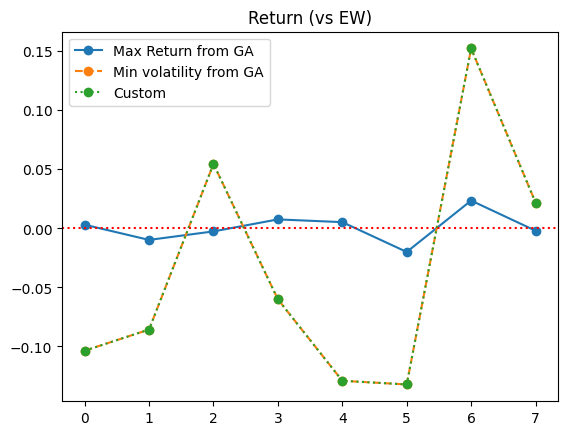

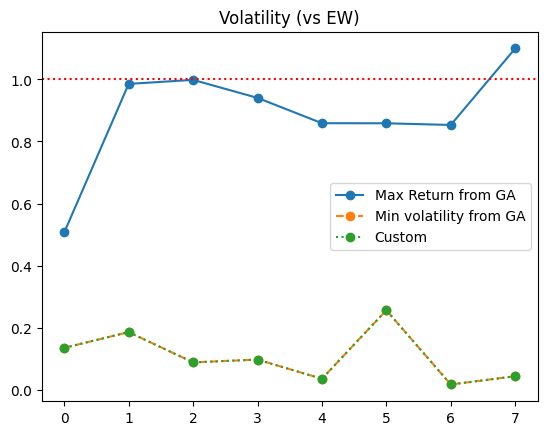

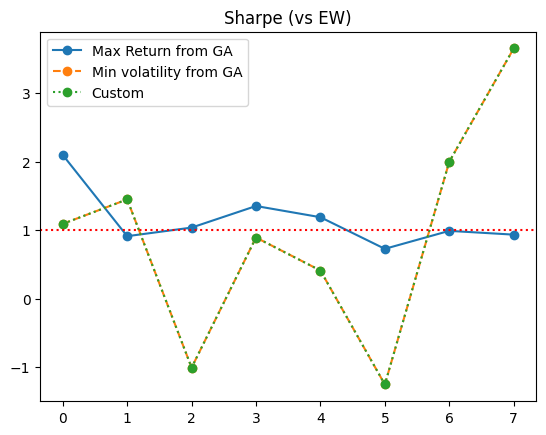

In [71]:
def extract_element(lists, element_index):
    return [[t[element_index] for t in lst] for lst in lists]

a_values = extract_element([ret, vol, cs], 0)
b_values = extract_element([ret, vol, cs], 1)
c_values = extract_element([ret, vol, cs], 2)

# Plotting function
def plot_lines(values, title, labels, benchmark_y):
    line_styles = ['-', '--', ':']
    plt.figure()
    i = 0
    for val, label in zip(values, labels):
        plt.plot(val, label=label, linestyle = line_styles[i], marker='o')
        i += 1
    plt.title(title)
    plt.axhline(y=benchmark_y, color='red', linestyle=':')
    plt.legend()
    plt.show()

line_labels = ['Max Return from GA', 'Min volatility from GA', 'Custom']

# Plotting
plot_lines(a_values, 'Return (vs EW)', line_labels, 0)
plot_lines(b_values, 'Volatility (vs EW)', line_labels, 1)
plot_lines(c_values, 'Sharpe (vs EW)', line_labels, 1)